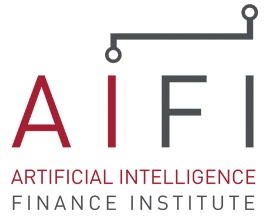


# Bootcamp - Python and Coding - Deep Learning

# Gated Recurrent Unit (GRU)

# About this notebook

The goal of this notebook is to demonstrate how to use `Grid Search CV` and the `scikit learn` wrapper `KerasRegressor` to optimize the hyperparameters of a given model, here we look at a **GRU**. Furthermore, this notebook contains examples on how to validate cross-validation and how to check the model for under- and overfitting. And as a final part, an example is given of how Tensorboard can be used as a callback when training a model and then checking the performance of the model. 

We will use techniques to optimize the training of the network based on the following paper:
- [Practical recommendations for gradient-based training of deep architectures](https://arxiv.org/abs/1206.5533)
- [On the difficulty of training Recurrent Neural Networks](https://arxiv.org/abs/1211.5063)
- [Understanding the exploding gradient problem](https://arxiv.org/abs/1211.5063)
- [Improving neural
networks by preventing co-adaptation of feature](http://arxiv.org/abs/1207.0580)
- [Overfitting in Neural Nets: Backpropagation,
Conjugate Gradient, and Early Stopping](https://proceedings.neurips.cc/paper/2000/file/059fdcd96baeb75112f09fa1dcc740cc-Paper.pdf)
- [Learning curve models and applications: Literature
review and research directions](https://www.sciencedirect.com/science/article/abs/pii/S016981411100062X)

|Input gate  | Forget gate   | Gate  | Output gate   | 
|---|---|---|---|
Write to cell or not? | Erase a cell or not?  | How much to write to cell? | How much to reveal cell?


			
			


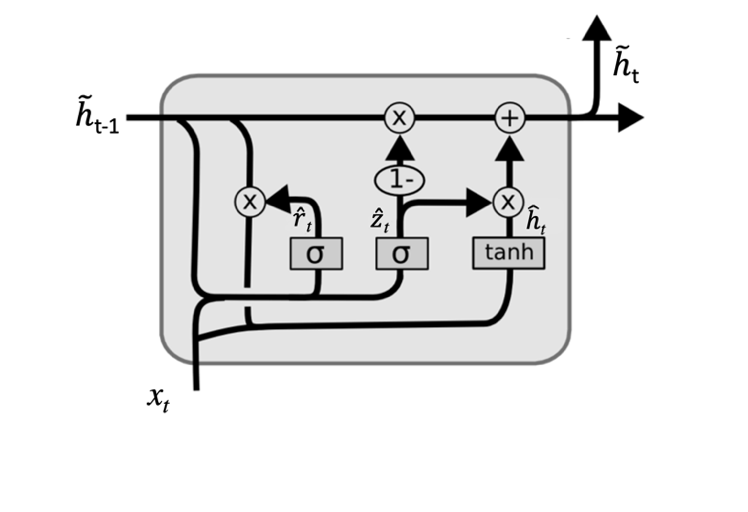

<font size=5>
$$
\begin{aligned}
&z_{t}=\sigma\left(W_{z} \cdot\left[h_{t-1}, x_{t}\right]\right) \\
&r_{t}=\sigma\left(W_{r} \cdot\left[h_{t-1}, x_{t}\right]\right) \\
&\tilde{h}_{t}=\tanh \left(W \cdot\left[r_{t} * h_{t-1}, x_{t}\right]\right) \\
&h_{t}=\left(1-z_{t}\right) * h_{t-1}+z_{t} * \tilde{h}_{t}
\end{aligned}
$$
    </font>

# Imports

In [1]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sys
import os
import time
import random
from datetime import datetime
from importlib import reload
from pprint import pprint
from pathlib import Path
from tqdm.notebook import tqdm

# sklearn imports
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import KFold, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from scipy.stats import t

# tensorflow and keras imports
import tensorflow.keras.initializers
from keras.models import Sequential
from keras.layers import Dense, Layer, GRU, RNN, Dropout
from keras.regularizers import l1
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping


# to make this notebook's output stable across runs
import random
seed = 0
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# surpress scientific notation
pd.options.display.float_format = '{:.8f}'.format

# custom library with functions
py_file_location = '../../'
sys.path.append(os.path.abspath(py_file_location)) # for accessing the path

from customlib import model_analysis as ma
from customlib import preprocessing as pre
from customlib import plotting
from customlib import model_analysis as ma

py_file_location = '../../customlib/'
sys.path.append(os.path.abspath(py_file_location)) # for accessing the path
# custom bootstrapping class
from bootstrap_ts import BootstrappingWrapper

In [2]:
# imports for plotting
from matplotlib import rcParams
import seaborn as sns
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
matplotlib_axes_logger.setLevel('ERROR')


# global custom setting for the running commands matplotlib or sns
plt.rcParams['axes.titlepad'] = 30
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['scatter.marker'] = 'o'

sns.set_style('whitegrid', {'axes.facecolor': '.995'})

# use the custom style sheet 
plt.style.use('../../custom_plot_style.mplstyle')  

# Computing environment
<a id="Versions" > 

In [3]:
%reload_ext watermark
%watermark -a "Author: Nicole Königstein" 
%watermark -d -v -m 
%watermark -v -p numpy,matplotlib,pandas,seaborn


Author: Author: Nicole Königstein

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.4.0

Compiler    : Clang 13.1.6 (clang-1316.0.21.2)
OS          : Darwin
Release     : 21.1.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.4.0

numpy     : 1.22.4
matplotlib: 3.5.2
pandas    : 1.4.3
seaborn   : 0.11.1



## Using CPU or GPU

In [4]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpu_devices, 'GPU')
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print('Using GPU')
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
else:
    print('Using CPU')

Using CPU


# Notebook running settings

### Model training

In [5]:
# Set to False if you don't wish to train the models
do_training = True 

### Cross validation

<font color=red><b>WARNING:</b> Changing this to `True` may take many hours to run, depending on your machine.</font>

In [6]:
cross_val = True 

# if the search will be performed in parallel or not, -1 means parallel choose one to not running parallel
n_jobs = -1  

#### Use cross validation data

In [7]:
# which parameters of the cross validation to use for training the model
run_1 = False
run_2 = False

# if cross validation data should be used
use_cv = True

### Training window

In [8]:
n_steps = 21
n_steps_ahead = 1

### Training settings

In [9]:
max_epochs = 2000
batch_size = 128

es = EarlyStopping(monitor='loss', mode='min', verbose=1,
                   patience=10, min_delta=3e-5, restore_best_weights=True)

### Metrics

In [10]:
metrics = ['mse', 'mae']

# Load data

# The Top 25 Stocks in the S&P 500

- Apple (AAPL): 7.14%
- Microsoft (MSFT): 6.1%
- Amazon (AMZN): 3.8%
- Tesla (TSLA): 2.5%
- Alphabet Class A (GOOGL): 2.2%
- Alphabet Class C (GOOG): 2.1%
- NVIDIA Corporation (NVDA): 1.8%
- Berkshire Hathaway Class B (BRK.B): 1.7%
- Meta (META), formerly Facebook, Class A: 1.4%
- UnitedHealth Group (UNH): 1.2%
- Johnson & Johnson (JNJ): 1.2%
- JPMorgan Chase (JPM): 1.0%
- Visa Class A (V): 1.0%
- Procter & Gamble (PG): 1.0%
- Exxon Mobil (XOM): 0.90% 
- Home Depot (HD): 0.8%
- Chevron Corporation (CVX): 0.80%
- Mastercard Inc. Class A (MA): 0.8%
- Bank of America (BAC): 0.8%
- AbbVie Inc. (ABBV): 0.7%
- Pfizer (PFE): 0.7%
- Broadcom Inc. (AVGO): 0.7%
- Costco (COST): 0.7%
- Walt Disney (DIS): 0.7%
- Coca-Cola Company (KO): 0.6%


**Source:** 
By Nathan Reiff, [investopedia.com](https://www.investopedia.com/ask/answers/08/find-stocks-in-sp500.asp) <br>
Updated April 05, 2022 <br>
Reviewed by Chip Stapleton<br>
Fact checked by Vikki Velasquez 

### Datapath

In [11]:
PATH = '../../'

### Get data

In [12]:
ticker = 'AMZN'

In [13]:
df = pd.read_csv(PATH + 'data/stock_prices_25_SP_500.csv')

data = df.loc[df['ticker'] == ticker]


In [14]:
data.head()

,ticker,date,close
11992,AMZN,1997-05-16,1.72916667
11993,AMZN,1997-05-19,1.70833333
11994,AMZN,1997-05-20,1.63583333
11995,AMZN,1997-05-21,1.42750000
11996,AMZN,1997-05-22,1.39583333


In [15]:
data = data[['close', 'date']]

# convert date object to datetime
format = '%Y-%m-%d'
data['date'] = pd.to_datetime(data['date'], format=format)
data.set_index('date', inplace=True)


data.head()

,close
date,
1997-05-16,1.72916667
1997-05-19,1.70833333
1997-05-20,1.63583333
1997-05-21,1.42750000
1997-05-22,1.39583333


# Prepare dataset

### Split the dataset

In [16]:
mu, sigma, data_train, data_val, data_test =  pre.prepare_data_val_no_split(data, log_=True)

### Get lagged features

In [17]:
x_train, y_train = pre.get_lagged_dataset(data_train, n_steps, n_steps_ahead)
x_val, y_val = pre.get_lagged_dataset(data_val, n_steps, n_steps_ahead)
x_test, y_test = pre.get_lagged_dataset(data_test, n_steps, n_steps_ahead)

# Display the shapes
print([tensor.shape for tensor in (x_train, y_train, x_val, y_val, x_test, y_test)])

[(4099, 21, 1), (4099, 1, 1), (1156, 21, 1), (1156, 1, 1), (568, 21, 1), (568, 1, 1)]


# Model function

In [18]:
init = tf.keras.initializers.glorot_uniform(seed)
recurr_init = tf.keras.initializers.orthogonal(seed)
input_shape = (x_train.shape[1], x_train.shape[-1])  # input lags, features

n_units = 10
l1_reg = 0

# function to create model, which is required for KerasRegressor
def GRU_(n_units=n_units, l1_reg=l1_reg, dropout_rate=0.5, metrics = ['mse']):
    model = Sequential()
    model.add(GRU(n_units, activation='tanh', kernel_initializer=init,
                        bias_initializer=init, recurrent_initializer=recurr_init,
                        kernel_regularizer=l1(l1_reg), input_shape=input_shape,
                        unroll=True, stateful=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_steps_ahead, kernel_initializer=init, bias_initializer=init,
                    kernel_regularizer=l1(l1_reg)))
    model.compile(loss='mean_squared_error', optimizer='adam',  metrics=metrics)
    return model


In [19]:
params = {
    'gru': {
        'model': None, 'network': GRU_, 'l1_reg': 0, 'n_units': 50,
        'dropout_rate': 0.1, 'color': '#d3d1d1', 'label': 'RNN'},
}

# Load pre-trained models


Training the models may take several hours, depending on your computer. To save time, you may load the already fitted models instead. To do so, just set the param for **Model training** at the beginning of this notebook like this:  `do_training = False`.

In [20]:
folder = 'trained-RNNs/{}/'.format(ticker)
model_name = 'RNNs-{}-{}-{}-conv-SAVED-'.format(ticker, n_steps, n_steps_ahead)
lags = str(n_steps)
                                
if not do_training:
    for key in params.keys():
        print('Loading model weights of {}'.format(key))
        params[key]['model'] = load_model(
            '../trained-RNNs/'+ folder + model_name + key + lags + '.hdf5')

# Cross-validation

In [21]:
# we need to reshape the data to fit the model
y_train = y_train.reshape(-1, n_steps_ahead)

In [22]:
# Define model creation function without defaults
def GRU_(n_units, l1_reg, dropout_rate):
    model = Sequential()
    model.add(SimpleRNN(n_units, activation='tanh',
                        kernel_regularizer=l1(l1_reg),
                        input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_steps_ahead,
                    kernel_regularizer=l1(l1_reg)))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
    return model

if do_training and cross_val:
    n_units = [5, 10, 20, 30, 40, 50]
    l1_reg = [1e-4, 1e-3, 0.01, 0.1, 0]
    dropout_rate = [0.1, 0.2, 0.3, 0.4, 0.5]

    # a dictionary containing a list of values to be iterated through
    param_grid = dict(model__n_units=n_units, model__l1_reg=l1_reg, model__dropout_rate=dropout_rate)
    
    # TimeSeriesSplit k folds as training set and the (k+1)th fold as test set.
    tscv = TimeSeriesSplit(n_splits=5)

    # grid search for each param combination
    for key in params.keys():
        networktime = time.time()
        print('Performing cross-validation on model:', key)
        
        model = KerasRegressor(model=params[key]['network'], epochs=max_epochs, batch_size=batch_size, verbose=0)
        
        grid = GridSearchCV(estimator=model, param_grid=param_grid,
                            cv=tscv, n_jobs=n_jobs, verbose=3, return_train_score=True)
        
        grid_result = grid.fit(x_train, y_train, callbacks=[es])
        print('Best score: %f using parameter %s' % (grid_result.best_score_, grid_result.best_params_))
        print('Network Runtime: %0.2f Minutes' % ((time.time() - networktime)/60))
 
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print('%f (%f) with %r' % (mean, stdev, param_))
                
        # Strip off the "model__" prefix
        best_params = {k.replace('model__', ''): v for k, v in grid_result.best_params_.items()}
        params[key].update(best_params)

Performing cross-validation on model: gru
Fitting 5 folds for each of 150 candidates, totalling 750 fits


2022-08-10 06:59:30.415446: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-10 06:59:30.430548: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-10 06:59:30.469530: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Restoring model weights from the end of the best epoch: 21.
Epoch 31: early stopping
Restoring model weights from the end of the best epoch: 39.
Epoch 49: early stopping
Restoring model weights from the end of the best epoch: 77.
Epoch 87: early stopping
Restoring model weights from the end of the best epoch: 55.
Epoch 65: early stopping
Restoring model weights from the end of the best epoch: 32.
Epoch 42: early stopping
Restoring model weights from the end of the best epoch: 81.
Epoch 91: early stopping
Restoring model weights from the end of the best epoch: 54.
Epoch 64: early stopping
Restoring model weights from the end of the best epoch: 87.
Epoch 97: early stopping
Restoring model weights from the end of the best epoch: 84.
Epoch 94: early stopping
Restoring model weights from the end of the best epoch: 50.
Epoch 60: early stopping
Restoring model weights from the end of the best epoch: 61.
Epoch 71: early stopping
Restoring model weights from the end of the best epoch: 49.
Epoch

[CV 5/5] END dropout_rate=0.1, l1_reg=0.001, n_units=20;, score=(train=-0.009, test=-0.015) total time=  56.9s
Restoring model weights from the end of the best epoch: 77.
Epoch 87: early stopping
[CV 2/5] END dropout_rate=0.1, l1_reg=0.001, n_units=50;, score=(train=-0.019, test=-0.016) total time=  54.9s
Restoring model weights from the end of the best epoch: 75.
Epoch 85: early stopping
[CV 5/5] END dropout_rate=0.1, l1_reg=0.0001, n_units=50;, score=(train=-0.004, test=-0.002) total time= 1.6min
Restoring model weights from the end of the best epoch: 103.
Epoch 113: early stopping
[CV 1/5] END dropout_rate=0.1, l1_reg=0.001, n_units=60;, score=(train=-0.025, test=-0.026) total time=  45.1s
Restoring model weights from the end of the best epoch: 126.
Epoch 136: early stopping
[CV 4/5] END dropout_rate=0.1, l1_reg=0.001, n_units=30;, score=(train=-0.010, test=-0.010) total time=  45.7s
Restoring model weights from the end of the best epoch: 99.
Epoch 109: early stopping
[CV 3/5] END d

2022-08-10 07:04:01.594288: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 2/5] END dropout_rate=0.1, l1_reg=0.001, n_units=30;, score=(train=-0.012, test=-0.009) total time=  43.6s
Restoring model weights from the end of the best epoch: 115.
Epoch 125: early stopping
[CV 1/5] END dropout_rate=0.1, l1_reg=0.001, n_units=70;, score=(train=-0.025, test=-0.025) total time= 1.2min
Restoring model weights from the end of the best epoch: 71.
Epoch 81: early stopping
[CV 5/5] END dropout_rate=0.1, l1_reg=0.0001, n_units=70;, score=(train=-0.004, test=-0.002) total time= 2.0min
Restoring model weights from the end of the best epoch: 87.
Epoch 97: early stopping
[CV 2/5] END dropout_rate=0.1, l1_reg=0.001, n_units=40;, score=(train=-0.012, test=-0.009) total time=  59.8s
Restoring model weights from the end of the best epoch: 66.
Epoch 76: early stopping
[CV 2/5] END dropout_rate=0.1, l1_reg=0.001, n_units=70;, score=(train=-0.014, test=-0.011) total time= 2.2min
[CV 3/5] END dropout_rate=0.1, l1_reg=0.001, n_units=70;, score=(train=-0.018, test=-0.016) total time

2022-08-10 07:05:00.520169: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 4/5] END dropout_rate=0.1, l1_reg=0.001, n_units=70;, score=(train=-0.015, test=-0.013) total time= 2.9min
Restoring model weights from the end of the best epoch: 140.
Epoch 150: early stopping
[CV 3/5] END dropout_rate=0.1, l1_reg=0.01, n_units=20;, score=(train=-0.067, test=-0.064) total time= 1.4min
Restoring model weights from the end of the best epoch: 199.
Epoch 209: early stopping


2022-08-10 07:05:17.788782: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 5/5] END dropout_rate=0.1, l1_reg=0.001, n_units=40;, score=(train=-0.009, test=-0.018) total time= 1.5min
Restoring model weights from the end of the best epoch: 341.
Epoch 351: early stopping


2022-08-10 07:05:21.624068: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 4/5] END dropout_rate=0.1, l1_reg=0.001, n_units=50;, score=(train=-0.009, test=-0.014) total time= 1.8min
Restoring model weights from the end of the best epoch: 262.
Epoch 272: early stopping
[CV 1/5] END dropout_rate=0.1, l1_reg=0.01, n_units=30;, score=(train=-0.116, test=-0.109) total time= 1.1min
Restoring model weights from the end of the best epoch: 114.
Epoch 124: early stopping


2022-08-10 07:05:59.165344: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 5/5] END dropout_rate=0.1, l1_reg=0.001, n_units=50;, score=(train=-0.012, test=-0.010) total time= 2.5min
Restoring model weights from the end of the best epoch: 112.
Epoch 122: early stopping
Restoring model weights from the end of the best epoch: 97.
Epoch 107: early stopping
[CV 4/5] END dropout_rate=0.1, l1_reg=0.01, n_units=40;, score=(train=-0.057, test=-0.060) total time= 2.0min
Restoring model weights from the end of the best epoch: 156.
Epoch 166: early stopping
[CV 3/5] END dropout_rate=0.1, l1_reg=0.01, n_units=30;, score=(train=-0.067, test=-0.062) total time= 1.5min
Restoring model weights from the end of the best epoch: 91.
Epoch 101: early stopping
[CV 4/5] END dropout_rate=0.1, l1_reg=0.01, n_units=30;, score=(train=-0.040, test=-0.063) total time= 1.3min
Restoring model weights from the end of the best epoch: 95.
Epoch 105: early stopping
[CV 2/5] END dropout_rate=0.1, l1_reg=0.01, n_units=30;, score=(train=-0.046, test=-0.038) total time= 1.2min
Restoring model w

2022-08-10 07:07:10.335336: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 5/5] END dropout_rate=0.1, l1_reg=0.01, n_units=50;, score=(train=-0.038, test=-0.127) total time= 2.3min
[CV 1/5] END dropout_rate=0.1, l1_reg=0.01, n_units=60;, score=(train=-0.088, test=-0.089) total time= 2.2min
Restoring model weights from the end of the best epoch: 125.
Epoch 135: early stopping
[CV 4/5] END dropout_rate=0.1, l1_reg=0.01, n_units=50;, score=(train=-0.034, test=-0.072) total time= 2.0min
Restoring model weights from the end of the best epoch: 166.
Epoch 176: early stopping


2022-08-10 07:07:33.228447: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 3/5] END dropout_rate=0.1, l1_reg=0.01, n_units=60;, score=(train=-0.058, test=-0.050) total time= 1.5min
Restoring model weights from the end of the best epoch: 83.
Epoch 93: early stopping


2022-08-10 07:07:40.903550: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 2/5] END dropout_rate=0.1, l1_reg=0.01, n_units=40;, score=(train=-0.045, test=-0.036) total time= 1.4min
Restoring model weights from the end of the best epoch: 102.
Epoch 112: early stopping
[CV 5/5] END dropout_rate=0.1, l1_reg=0.01, n_units=30;, score=(train=-0.039, test=-0.077) total time= 2.4min
Restoring model weights from the end of the best epoch: 179.
Epoch 189: early stopping
[CV 5/5] END dropout_rate=0.1, l1_reg=0.01, n_units=40;, score=(train=-0.035, test=-0.112) total time= 1.8min
Restoring model weights from the end of the best epoch: 94.
Epoch 104: early stopping


2022-08-10 07:08:06.360286: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 4/5] END dropout_rate=0.1, l1_reg=0.01, n_units=60;, score=(train=-0.035, test=-0.077) total time= 2.8min
[CV 1/5] END dropout_rate=0.1, l1_reg=0.01, n_units=70;, score=(train=-0.091, test=-0.092) total time= 2.2min


2022-08-10 07:08:10.667583: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 2/5] END dropout_rate=0.1, l1_reg=0.01, n_units=70;, score=(train=-0.045, test=-0.036) total time= 2.1min
[CV 2/5] END dropout_rate=0.1, l1_reg=0.01, n_units=50;, score=(train=-0.043, test=-0.033) total time= 1.7min
Restoring model weights from the end of the best epoch: 130.
Epoch 140: early stopping
Restoring model weights from the end of the best epoch: 98.
Epoch 108: early stopping
[CV 3/5] END dropout_rate=0.1, l1_reg=0.001, n_units=40;, score=(train=-0.011, test=-0.010) total time= 1.1min
Restoring model weights from the end of the best epoch: 154.
Epoch 164: early stopping
[CV 1/5] END dropout_rate=0.1, l1_reg=0.1, n_units=20;, score=(train=-0.210, test=-0.244) total time=  51.8s
Restoring model weights from the end of the best epoch: 71.
Epoch 81: early stopping
[CV 5/5] END dropout_rate=0.1, l1_reg=0.001, n_units=70;, score=(train=-0.012, test=-0.010) total time= 6.5min
[CV 3/5] END dropout_rate=0.1, l1_reg=0.01, n_units=40;, score=(train=-0.040, test=-0.035) total time= 1

2022-08-10 07:08:56.896481: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 2/5] END dropout_rate=0.1, l1_reg=0.01, n_units=60;, score=(train=-0.045, test=-0.035) total time= 1.6min
Restoring model weights from the end of the best epoch: 226.
Epoch 236: early stopping
Restoring model weights from the end of the best epoch: 105.
Epoch 115: early stopping


2022-08-10 07:08:58.468032: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-10 07:08:59.988183: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Restoring model weights from the end of the best epoch: 151.
Epoch 161: early stopping


2022-08-10 07:09:19.046282: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 5/5] END dropout_rate=0.1, l1_reg=0.1, n_units=20;, score=(train=-0.178, test=-0.647) total time= 1.5min
Restoring model weights from the end of the best epoch: 68.
Epoch 78: early stopping
Restoring model weights from the end of the best epoch: 92.
Epoch 102: early stopping
[CV 2/5] END dropout_rate=0.1, l1_reg=0.1, n_units=20;, score=(train=-0.194, test=-0.160) total time=  51.9s
Restoring model weights from the end of the best epoch: 197.
Epoch 207: early stopping


2022-08-10 07:09:28.260525: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 4/5] END dropout_rate=0.1, l1_reg=0.1, n_units=30;, score=(train=-0.172, test=-0.383) total time= 1.1min
Restoring model weights from the end of the best epoch: 93.
Epoch 103: early stopping
[CV 1/5] END dropout_rate=0.1, l1_reg=0.1, n_units=50;, score=(train=-0.282, test=-0.254) total time=  46.9s
Restoring model weights from the end of the best epoch: 108.
Epoch 118: early stopping
[CV 1/5] END dropout_rate=0.1, l1_reg=0.1, n_units=30;, score=(train=-0.241, test=-0.256) total time=  53.8s
Restoring model weights from the end of the best epoch: 85.
Epoch 95: early stopping
Restoring model weights from the end of the best epoch: 103.
Epoch 113: early stopping
[CV 3/5] END dropout_rate=0.1, l1_reg=0.1, n_units=20;, score=(train=-0.177, test=-0.163) total time= 1.1min
Restoring model weights from the end of the best epoch: 114.
Epoch 124: early stopping
Restoring model weights from the end of the best epoch: 114.
Epoch 124: early stopping
[CV 1/5] END dropout_rate=0.1, l1_reg=0.01, n

2022-08-10 07:10:33.830023: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Restoring model weights from the end of the best epoch: 183.
Epoch 193: early stopping
[CV 1/5] END dropout_rate=0.1, l1_reg=0.1, n_units=40;, score=(train=-0.243, test=-0.260) total time=  49.6s
Restoring model weights from the end of the best epoch: 88.
Epoch 98: early stopping
Restoring model weights from the end of the best epoch: 91.
Epoch 101: early stopping
[CV 4/5] END dropout_rate=0.1, l1_reg=0.1, n_units=20;, score=(train=-0.160, test=-0.372) total time= 1.2min
Restoring model weights from the end of the best epoch: 263.
Epoch 273: early stopping
[CV 5/5] END dropout_rate=0.1, l1_reg=0.1, n_units=40;, score=(train=-0.177, test=-0.628) total time= 1.1min
Restoring model weights from the end of the best epoch: 29.
Epoch 39: early stopping
[CV 3/5] END dropout_rate=0.1, l1_reg=0.1, n_units=40;, score=(train=-0.188, test=-0.187) total time=  59.6s
Restoring model weights from the end of the best epoch: 71.
Epoch 81: early stopping


2022-08-10 07:11:18.558471: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 5/5] END dropout_rate=0.1, l1_reg=0.1, n_units=50;, score=(train=-0.184, test=-0.730) total time= 1.5min
Restoring model weights from the end of the best epoch: 61.
Epoch 71: early stopping
[CV 2/5] END dropout_rate=0.1, l1_reg=0.1, n_units=50;, score=(train=-0.186, test=-0.142) total time= 1.5min
Restoring model weights from the end of the best epoch: 33.
Epoch 43: early stopping
[CV 4/5] END dropout_rate=0.1, l1_reg=0.1, n_units=50;, score=(train=-0.164, test=-0.370) total time= 1.6min
Restoring model weights from the end of the best epoch: 91.
Epoch 101: early stopping
[CV 3/5] END dropout_rate=0.1, l1_reg=0.1, n_units=50;, score=(train=-0.167, test=-0.163) total time= 2.2min
Restoring model weights from the end of the best epoch: 68.
Epoch 78: early stopping
[CV 2/5] END dropout_rate=0.1, l1_reg=0.1, n_units=30;, score=(train=-0.184, test=-0.146) total time= 1.1min
Restoring model weights from the end of the best epoch: 324.
Epoch 334: early stopping
[CV 3/5] END dropout_rate=0

2022-08-10 07:13:07.211857: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 5/5] END dropout_rate=0.1, l1_reg=0, n_units=20;, score=(train=-0.002, test=-0.002) total time= 1.6min
Restoring model weights from the end of the best epoch: 61.
Epoch 71: early stopping
[CV 3/5] END dropout_rate=0.1, l1_reg=0, n_units=30;, score=(train=-0.003, test=-0.001) total time= 1.3min
Restoring model weights from the end of the best epoch: 45.
Epoch 55: early stopping


2022-08-10 07:13:15.999563: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 2/5] END dropout_rate=0.1, l1_reg=0.1, n_units=40;, score=(train=-0.193, test=-0.149) total time=  50.6s
Restoring model weights from the end of the best epoch: 129.
Epoch 139: early stopping
[CV 2/5] END dropout_rate=0.1, l1_reg=0, n_units=20;, score=(train=-0.008, test=-0.002) total time= 1.2min
Restoring model weights from the end of the best epoch: 25.
Epoch 35: early stopping
[CV 4/5] END dropout_rate=0.1, l1_reg=0.1, n_units=70;, score=(train=-0.164, test=-0.345) total time= 3.5min
[CV 2/5] END dropout_rate=0.1, l1_reg=0.1, n_units=70;, score=(train=-0.192, test=-0.170) total time= 1.9min
Restoring model weights from the end of the best epoch: 48.
Epoch 58: early stopping
[CV 5/5] END dropout_rate=0.1, l1_reg=0.1, n_units=30;, score=(train=-0.179, test=-0.670) total time= 1.8min
Restoring model weights from the end of the best epoch: 234.
Epoch 244: early stopping
[CV 4/5] END dropout_rate=0.1, l1_reg=0, n_units=30;, score=(train=-0.002, test=-0.001) total time= 1.5min
Restor

2022-08-10 07:14:10.225728: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 5/5] END dropout_rate=0.1, l1_reg=0, n_units=30;, score=(train=-0.002, test=-0.001) total time= 1.3min
Restoring model weights from the end of the best epoch: 89.
Epoch 99: early stopping
[CV 4/5] END dropout_rate=0.1, l1_reg=0.1, n_units=40;, score=(train=-0.167, test=-0.388) total time=  54.4s
Restoring model weights from the end of the best epoch: 368.
Epoch 378: early stopping
[CV 2/5] END dropout_rate=0.1, l1_reg=0, n_units=60;, score=(train=-0.004, test=-0.001) total time= 1.2min
[CV 3/5] END dropout_rate=0.1, l1_reg=0.1, n_units=60;, score=(train=-0.164, test=-0.153) total time= 4.8min


2022-08-10 07:14:21.398438: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 3/5] END dropout_rate=0.1, l1_reg=0, n_units=40;, score=(train=-0.004, test=-0.001) total time=  47.9s
Restoring model weights from the end of the best epoch: 69.
Epoch 79: early stopping
[CV 1/5] END dropout_rate=0.1, l1_reg=0, n_units=40;, score=(train=-0.008, test=-0.008) total time=  47.3s
Restoring model weights from the end of the best epoch: 88.
Epoch 98: early stopping


2022-08-10 07:14:25.754150: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-10 07:14:27.976601: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 2/5] END dropout_rate=0.1, l1_reg=0, n_units=50;, score=(train=-0.004, test=-0.001) total time=  54.6s
Restoring model weights from the end of the best epoch: 44.
Epoch 54: early stopping
[CV 3/5] END dropout_rate=0.1, l1_reg=0, n_units=50;, score=(train=-0.004, test=-0.002) total time=  48.5s
Restoring model weights from the end of the best epoch: 90.
Epoch 100: early stopping
[CV 1/5] END dropout_rate=0.1, l1_reg=0, n_units=70;, score=(train=-0.006, test=-0.006) total time=  42.9s
Restoring model weights from the end of the best epoch: 106.
Epoch 116: early stopping
[CV 4/5] END dropout_rate=0.1, l1_reg=0, n_units=50;, score=(train=-0.002, test=-0.003) total time=  53.6s
Restoring model weights from the end of the best epoch: 48.
Epoch 58: early stopping
[CV 3/5] END dropout_rate=0.1, l1_reg=0, n_units=60;, score=(train=-0.004, test=-0.001) total time=  58.9s
Restoring model weights from the end of the best epoch: 42.
Epoch 52: early stopping


2022-08-10 07:14:43.015816: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 1/5] END dropout_rate=0.1, l1_reg=0, n_units=50;, score=(train=-0.005, test=-0.006) total time=  46.4s
Restoring model weights from the end of the best epoch: 46.
Epoch 56: early stopping


2022-08-10 07:14:43.919872: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 5/5] END dropout_rate=0.1, l1_reg=0, n_units=60;, score=(train=-0.002, test=-0.001) total time= 1.5min
Restoring model weights from the end of the best epoch: 66.
Epoch 76: early stopping
[CV 5/5] END dropout_rate=0.1, l1_reg=0, n_units=50;, score=(train=-0.002, test=-0.001) total time= 1.7min
Restoring model weights from the end of the best epoch: 47.
Epoch 57: early stopping
Restoring model weights from the end of the best epoch: 30.
Epoch 40: early stopping
Restoring model weights from the end of the best epoch: 63.
Epoch 73: early stopping
Restoring model weights from the end of the best epoch: 45.
Epoch 55: early stopping
[CV 4/5] END dropout_rate=0.1, l1_reg=0, n_units=60;, score=(train=-0.003, test=-0.001) total time= 1.2min
Restoring model weights from the end of the best epoch: 55.
Epoch 65: early stopping
[CV 3/5] END dropout_rate=0.2, l1_reg=0.0001, n_units=20;, score=(train=-0.006, test=-0.003) total time=  33.1s
Restoring model weights from the end of the best epoch: 8

2022-08-10 07:15:23.116407: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 2/5] END dropout_rate=0.2, l1_reg=0.0001, n_units=30;, score=(train=-0.006, test=-0.003) total time=  28.3s
Restoring model weights from the end of the best epoch: 65.
Epoch 75: early stopping
[CV 5/5] END dropout_rate=0.1, l1_reg=0, n_units=70;, score=(train=-0.002, test=-0.001) total time= 1.7min
Restoring model weights from the end of the best epoch: 90.
Epoch 100: early stopping
Restoring model weights from the end of the best epoch: 76.
Epoch 86: early stopping
[CV 4/5] END dropout_rate=0.2, l1_reg=0.0001, n_units=20;, score=(train=-0.004, test=-0.007) total time=  44.0s
Restoring model weights from the end of the best epoch: 62.
Epoch 72: early stopping
[CV 1/5] END dropout_rate=0.2, l1_reg=0.0001, n_units=20;, score=(train=-0.010, test=-0.009) total time=  30.3s
Restoring model weights from the end of the best epoch: 75.
Epoch 85: early stopping


2022-08-10 07:15:38.551541: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 4/5] END dropout_rate=0.1, l1_reg=0, n_units=70;, score=(train=-0.002, test=-0.001) total time=  59.9s
Restoring model weights from the end of the best epoch: 38.
Epoch 48: early stopping


2022-08-10 07:15:50.996446: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 2/5] END dropout_rate=0.2, l1_reg=0.0001, n_units=40;, score=(train=-0.005, test=-0.002) total time=  35.8s
Restoring model weights from the end of the best epoch: 36.
Epoch 46: early stopping


2022-08-10 07:15:56.470169: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Restoring model weights from the end of the best epoch: 45.
Epoch 55: early stopping
[CV 1/5] END dropout_rate=0.2, l1_reg=0.0001, n_units=30;, score=(train=-0.010, test=-0.012) total time=  31.1s
Restoring model weights from the end of the best epoch: 62.
Epoch 72: early stopping
[CV 3/5] END dropout_rate=0.2, l1_reg=0.0001, n_units=30;, score=(train=-0.004, test=-0.002) total time=  45.1s
Restoring model weights from the end of the best epoch: 80.
Epoch 90: early stopping
[CV 4/5] END dropout_rate=0.2, l1_reg=0.0001, n_units=30;, score=(train=-0.003, test=-0.003) total time=  50.1s
Restoring model weights from the end of the best epoch: 55.
Epoch 65: early stopping
[CV 5/5] END dropout_rate=0.2, l1_reg=0.0001, n_units=40;, score=(train=-0.003, test=-0.004) total time=  45.4s
Restoring model weights from the end of the best epoch: 35.
Epoch 45: early stopping
Restoring model weights from the end of the best epoch: 60.
Epoch 70: early stopping
[CV 3/5] END dropout_rate=0.2, l1_reg=0.00

2022-08-10 07:17:07.573997: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 1/5] END dropout_rate=0.2, l1_reg=0.0001, n_units=70;, score=(train=-0.006, test=-0.006) total time=  46.8s
Restoring model weights from the end of the best epoch: 76.
Epoch 86: early stopping
Restoring model weights from the end of the best epoch: 42.
Epoch 52: early stopping
[CV 4/5] END dropout_rate=0.2, l1_reg=0.001, n_units=20;, score=(train=-0.010, test=-0.013) total time=  50.3s
Restoring model weights from the end of the best epoch: 45.
Epoch 55: early stopping
[CV 2/5] END dropout_rate=0.2, l1_reg=0.001, n_units=20;, score=(train=-0.017, test=-0.012) total time=  42.1s
Restoring model weights from the end of the best epoch: 92.
Epoch 102: early stopping


2022-08-10 07:17:15.300231: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 1/5] END dropout_rate=0.2, l1_reg=0.001, n_units=30;, score=(train=-0.027, test=-0.021) total time=  38.3s
Restoring model weights from the end of the best epoch: 67.
Epoch 77: early stopping
[CV 3/5] END dropout_rate=0.1, l1_reg=0, n_units=70;, score=(train=-0.003, test=-0.001) total time= 1.9min
Restoring model weights from the end of the best epoch: 68.
Epoch 78: early stopping
[CV 3/5] END dropout_rate=0.2, l1_reg=0.001, n_units=20;, score=(train=-0.011, test=-0.009) total time=  52.2s
Restoring model weights from the end of the best epoch: 75.
Epoch 85: early stopping
[CV 5/5] END dropout_rate=0.2, l1_reg=0.0001, n_units=60;, score=(train=-0.004, test=-0.002) total time= 2.2min
[CV 1/5] END dropout_rate=0.2, l1_reg=0.001, n_units=40;, score=(train=-0.026, test=-0.024) total time=  38.0s
Restoring model weights from the end of the best epoch: 71.
Epoch 81: early stopping
Restoring model weights from the end of the best epoch: 80.
Epoch 90: early stopping
[CV 4/5] END dropout_ra

2022-08-10 07:18:30.207160: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 5/5] END dropout_rate=0.2, l1_reg=0.001, n_units=30;, score=(train=-0.009, test=-0.019) total time=  59.2s
Restoring model weights from the end of the best epoch: 53.
Epoch 63: early stopping
[CV 1/5] END dropout_rate=0.2, l1_reg=0.001, n_units=60;, score=(train=-0.020, test=-0.020) total time=  45.8s
Restoring model weights from the end of the best epoch: 156.
Epoch 166: early stopping
[CV 3/5] END dropout_rate=0.2, l1_reg=0.001, n_units=60;, score=(train=-0.021, test=-0.018) total time= 1.3min
Restoring model weights from the end of the best epoch: 105.
Epoch 115: early stopping
[CV 2/5] END dropout_rate=0.2, l1_reg=0.001, n_units=30;, score=(train=-0.013, test=-0.010) total time=  44.2s
Restoring model weights from the end of the best epoch: 140.
Epoch 150: early stopping
[CV 1/5] END dropout_rate=0.2, l1_reg=0.001, n_units=50;, score=(train=-0.018, test=-0.019) total time=  44.5s
Restoring model weights from the end of the best epoch: 165.
Epoch 175: early stopping
[CV 2/5] END

2022-08-10 07:20:45.790403: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 4/5] END dropout_rate=0.2, l1_reg=0.01, n_units=30;, score=(train=-0.044, test=-0.075) total time= 1.2min
Restoring model weights from the end of the best epoch: 177.
Epoch 187: early stopping


2022-08-10 07:20:55.332609: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-10 07:20:59.233502: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-10 07:21:02.042000: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

[CV 5/5] END dropout_rate=0.2, l1_reg=0.01, n_units=20;, score=(train=-0.038, test=-0.156) total time= 1.1min
Restoring model weights from the end of the best epoch: 104.
Epoch 114: early stopping
[CV 1/5] END dropout_rate=0.2, l1_reg=0.01, n_units=40;, score=(train=-0.114, test=-0.110) total time= 1.1min
Restoring model weights from the end of the best epoch: 83.
Epoch 93: early stopping
[CV 2/5] END dropout_rate=0.2, l1_reg=0.01, n_units=60;, score=(train=-0.061, test=-0.052) total time= 1.6min
[CV 2/5] END dropout_rate=0.2, l1_reg=0.001, n_units=40;, score=(train=-0.017, test=-0.013) total time=  43.5s
Restoring model weights from the end of the best epoch: 121.
Epoch 131: early stopping
[CV 5/5] END dropout_rate=0.2, l1_reg=0.001, n_units=60;, score=(train=-0.009, test=-0.023) total time= 4.5min
[CV 4/5] END dropout_rate=0.2, l1_reg=0.01, n_units=40;, score=(train=-0.068, test=-0.061) total time= 1.4min
Restoring model weights from the end of the best epoch: 76.
Epoch 86: early sto

2022-08-10 07:22:40.836781: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 1/5] END dropout_rate=0.2, l1_reg=0.01, n_units=60;, score=(train=-0.054, test=-0.054) total time= 1.2min
Restoring model weights from the end of the best epoch: 350.
Epoch 360: early stopping


2022-08-10 07:22:45.622373: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 5/5] END dropout_rate=0.2, l1_reg=0.01, n_units=30;, score=(train=-0.036, test=-0.104) total time= 1.5min
Restoring model weights from the end of the best epoch: 111.
Epoch 121: early stopping


2022-08-10 07:22:50.005831: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 2/5] END dropout_rate=0.2, l1_reg=0.01, n_units=70;, score=(train=-0.057, test=-0.048) total time= 1.3min
Restoring model weights from the end of the best epoch: 83.
Epoch 93: early stopping
[CV 3/5] END dropout_rate=0.2, l1_reg=0.01, n_units=60;, score=(train=-0.060, test=-0.077) total time= 2.8min
Restoring model weights from the end of the best epoch: 92.
Epoch 102: early stopping
[CV 2/5] END dropout_rate=0.2, l1_reg=0.1, n_units=20;, score=(train=-0.261, test=-0.211) total time= 1.7min
Restoring model weights from the end of the best epoch: 106.
Epoch 116: early stopping
[CV 5/5] END dropout_rate=0.2, l1_reg=0.01, n_units=50;, score=(train=-0.035, test=-0.097) total time= 2.8min
Restoring model weights from the end of the best epoch: 86.
Epoch 96: early stopping
[CV 3/5] END dropout_rate=0.2, l1_reg=0.01, n_units=50;, score=(train=-0.077, test=-0.071) total time= 1.9min
Restoring model weights from the end of the best epoch: 262.
Epoch 272: early stopping
Restoring model weigh

2022-08-10 07:23:55.564716: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Restoring model weights from the end of the best epoch: 99.
Epoch 109: early stopping
[CV 5/5] END dropout_rate=0.2, l1_reg=0.01, n_units=60;, score=(train=-0.039, test=-0.095) total time= 1.6min
Restoring model weights from the end of the best epoch: 206.
Epoch 216: early stopping
[CV 4/5] END dropout_rate=0.2, l1_reg=0.01, n_units=70;, score=(train=-0.035, test=-0.072) total time= 2.7min
Restoring model weights from the end of the best epoch: 73.
Epoch 83: early stopping
[CV 1/5] END dropout_rate=0.2, l1_reg=0.1, n_units=30;, score=(train=-0.242, test=-0.264) total time=  57.0s
Restoring model weights from the end of the best epoch: 104.
Epoch 114: early stopping
[CV 3/5] END dropout_rate=0.2, l1_reg=0.01, n_units=30;, score=(train=-0.078, test=-0.073) total time= 1.2min
Restoring model weights from the end of the best epoch: 437.
Epoch 447: early stopping
Restoring model weights from the end of the best epoch: 83.
Epoch 93: early stopping
[CV 4/5] END dropout_rate=0.2, l1_reg=0.1, n

2022-08-10 07:26:07.760658: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-10 07:26:14.627155: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 3/5] END dropout_rate=0.2, l1_reg=0.1, n_units=50;, score=(train=-0.179, test=-0.164) total time= 2.2min
Restoring model weights from the end of the best epoch: 50.
Epoch 60: early stopping
[CV 1/5] END dropout_rate=0.2, l1_reg=0, n_units=20;, score=(train=-0.009, test=-0.008) total time=  53.8s
[CV 2/5] END dropout_rate=0.2, l1_reg=0.1, n_units=50;, score=(train=-0.264, test=-0.215) total time= 2.5min
Restoring model weights from the end of the best epoch: 45.
Epoch 55: early stopping
[CV 4/5] END dropout_rate=0.2, l1_reg=0.1, n_units=20;, score=(train=-0.167, test=-0.382) total time= 2.3min
Restoring model weights from the end of the best epoch: 89.
Epoch 99: early stopping
[CV 2/5] END dropout_rate=0.2, l1_reg=0.1, n_units=40;, score=(train=-0.179, test=-0.139) total time= 1.4min
Restoring model weights from the end of the best epoch: 105.
Epoch 115: early stopping
[CV 5/5] END dropout_rate=0.2, l1_reg=0.1, n_units=50;, score=(train=-0.182, test=-0.684) total time= 3.1min
[CV 1/

2022-08-10 07:27:06.383309: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Restoring model weights from the end of the best epoch: 33.
Epoch 43: early stopping


2022-08-10 07:27:15.474274: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-10 07:27:19.341849: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 1/5] END dropout_rate=0.2, l1_reg=0, n_units=30;, score=(train=-0.010, test=-0.005) total time= 1.1min
Restoring model weights from the end of the best epoch: 58.
Epoch 68: early stopping
[CV 4/5] END dropout_rate=0.2, l1_reg=0, n_units=20;, score=(train=-0.002, test=-0.003) total time= 1.2min
Restoring model weights from the end of the best epoch: 48.
Epoch 58: early stopping
[CV 2/5] END dropout_rate=0.2, l1_reg=0, n_units=20;, score=(train=-0.005, test=-0.001) total time= 1.1min
Restoring model weights from the end of the best epoch: 97.
Epoch 107: early stopping


2022-08-10 07:27:24.538894: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 4/5] END dropout_rate=0.2, l1_reg=0.1, n_units=50;, score=(train=-0.163, test=-0.379) total time= 3.3min
Restoring model weights from the end of the best epoch: 57.
Epoch 67: early stopping


2022-08-10 07:27:25.542433: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 1/5] END dropout_rate=0.2, l1_reg=0.1, n_units=60;, score=(train=-0.374, test=-0.389) total time= 1.3min
Restoring model weights from the end of the best epoch: 60.
Epoch 70: early stopping
[CV 3/5] END dropout_rate=0.2, l1_reg=0.1, n_units=70;, score=(train=-0.176, test=-0.179) total time= 2.6min
[CV 3/5] END dropout_rate=0.2, l1_reg=0, n_units=20;, score=(train=-0.005, test=-0.003) total time=  58.3s
Restoring model weights from the end of the best epoch: 44.
Epoch 54: early stopping
[CV 2/5] END dropout_rate=0.2, l1_reg=0, n_units=30;, score=(train=-0.004, test=-0.001) total time= 1.3min
Restoring model weights from the end of the best epoch: 63.
Epoch 73: early stopping
Restoring model weights from the end of the best epoch: 66.
Epoch 76: early stopping
Restoring model weights from the end of the best epoch: 27.
Epoch 37: early stopping
Restoring model weights from the end of the best epoch: 61.
Epoch 71: early stopping
Restoring model weights from the end of the best epoch: 69

2022-08-10 07:28:26.979939: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 2/5] END dropout_rate=0.2, l1_reg=0, n_units=40;, score=(train=-0.005, test=-0.001) total time=  34.4s
Restoring model weights from the end of the best epoch: 62.
Epoch 72: early stopping
[CV 3/5] END dropout_rate=0.2, l1_reg=0, n_units=60;, score=(train=-0.003, test=-0.001) total time= 1.2min
[CV 3/5] END dropout_rate=0.2, l1_reg=0, n_units=30;, score=(train=-0.003, test=-0.001) total time=  55.5s
Restoring model weights from the end of the best epoch: 81.
Epoch 91: early stopping
[CV 5/5] END dropout_rate=0.2, l1_reg=0, n_units=30;, score=(train=-0.002, test=-0.005) total time=  48.6s
Restoring model weights from the end of the best epoch: 34.
Epoch 44: early stopping
[CV 1/5] END dropout_rate=0.2, l1_reg=0, n_units=40;, score=(train=-0.010, test=-0.008) total time=  33.0s
Restoring model weights from the end of the best epoch: 39.
Epoch 49: early stopping
[CV 3/5] END dropout_rate=0.2, l1_reg=0, n_units=50;, score=(train=-0.003, test=-0.001) total time=  42.4s
Restoring model we

2022-08-10 07:29:21.570594: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 3/5] END dropout_rate=0.3, l1_reg=0.0001, n_units=20;, score=(train=-0.004, test=-0.003) total time=  57.8s
[CV 4/5] END dropout_rate=0.2, l1_reg=0, n_units=60;, score=(train=-0.003, test=-0.005) total time= 1.1min
Restoring model weights from the end of the best epoch: 22.
Epoch 32: early stopping


2022-08-10 07:29:27.171559: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 2/5] END dropout_rate=0.2, l1_reg=0, n_units=70;, score=(train=-0.004, test=-0.001) total time=  55.8s
Restoring model weights from the end of the best epoch: 39.
Epoch 49: early stopping


2022-08-10 07:29:31.199757: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 1/5] END dropout_rate=0.3, l1_reg=0.0001, n_units=20;, score=(train=-0.009, test=-0.008) total time=  47.1s
Restoring model weights from the end of the best epoch: 46.
Epoch 56: early stopping
[CV 1/5] END dropout_rate=0.2, l1_reg=0, n_units=70;, score=(train=-0.006, test=-0.005) total time= 1.2min
Restoring model weights from the end of the best epoch: 30.
Epoch 40: early stopping
[CV 3/5] END dropout_rate=0.2, l1_reg=0, n_units=40;, score=(train=-0.003, test=-0.001) total time=  49.6s
Restoring model weights from the end of the best epoch: 55.
Epoch 65: early stopping
[CV 1/5] END dropout_rate=0.2, l1_reg=0, n_units=50;, score=(train=-0.005, test=-0.006) total time=  50.0s
Restoring model weights from the end of the best epoch: 36.
Epoch 46: early stopping
Restoring model weights from the end of the best epoch: 41.
Epoch 51: early stopping
[CV 3/5] END dropout_rate=0.3, l1_reg=0.0001, n_units=30;, score=(train=-0.006, test=-0.004) total time=  32.1s
[CV 2/5] END dropout_rate=0.3,

2022-08-10 07:29:41.394189: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-10 07:29:45.417150: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Restoring model weights from the end of the best epoch: 35.
Epoch 45: early stopping
[CV 3/5] END dropout_rate=0.2, l1_reg=0, n_units=70;, score=(train=-0.003, test=-0.001) total time= 1.2min
Restoring model weights from the end of the best epoch: 76.
Epoch 86: early stopping
Restoring model weights from the end of the best epoch: 37.
Epoch 47: early stopping
[CV 4/5] END dropout_rate=0.3, l1_reg=0.0001, n_units=20;, score=(train=-0.004, test=-0.013) total time=  42.5s
Restoring model weights from the end of the best epoch: 54.
Epoch 64: early stopping
Restoring model weights from the end of the best epoch: 50.
Epoch 60: early stopping


2022-08-10 07:30:09.369089: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 2/5] END dropout_rate=0.3, l1_reg=0.0001, n_units=30;, score=(train=-0.015, test=-0.005) total time=  32.1s
Restoring model weights from the end of the best epoch: 64.
Epoch 74: early stopping
[CV 1/5] END dropout_rate=0.3, l1_reg=0.0001, n_units=40;, score=(train=-0.008, test=-0.008) total time=  30.5s
Restoring model weights from the end of the best epoch: 75.
Epoch 85: early stopping
[CV 1/5] END dropout_rate=0.3, l1_reg=0.0001, n_units=30;, score=(train=-0.029, test=-0.015) total time=  31.4s
Restoring model weights from the end of the best epoch: 106.
Epoch 116: early stopping
Restoring model weights from the end of the best epoch: 57.
Epoch 67: early stopping
Restoring model weights from the end of the best epoch: 46.
Epoch 56: early stopping
[CV 5/5] END dropout_rate=0.2, l1_reg=0, n_units=70;, score=(train=-0.002, test=-0.002) total time= 1.4min
Restoring model weights from the end of the best epoch: 54.
Epoch 64: early stopping
[CV 4/5] END dropout_rate=0.2, l1_reg=0, n_un

2022-08-10 07:31:49.675072: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 2/5] END dropout_rate=0.3, l1_reg=0.0001, n_units=60;, score=(train=-0.005, test=-0.002) total time= 1.1min
Restoring model weights from the end of the best epoch: 76.
Epoch 86: early stopping
[CV 5/5] END dropout_rate=0.3, l1_reg=0.0001, n_units=40;, score=(train=-0.004, test=-0.005) total time= 1.2min
Restoring model weights from the end of the best epoch: 90.
Epoch 100: early stopping
[CV 1/5] END dropout_rate=0.3, l1_reg=0.0001, n_units=70;, score=(train=-0.010, test=-0.009) total time= 1.1min
Restoring model weights from the end of the best epoch: 48.
Epoch 58: early stopping


2022-08-10 07:31:55.433349: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 2/5] END dropout_rate=0.3, l1_reg=0.0001, n_units=50;, score=(train=-0.011, test=-0.004) total time=  40.3s
Restoring model weights from the end of the best epoch: 60.
Epoch 70: early stopping
[CV 4/5] END dropout_rate=0.3, l1_reg=0.0001, n_units=60;, score=(train=-0.004, test=-0.004) total time= 1.2min
Restoring model weights from the end of the best epoch: 68.
Epoch 78: early stopping
[CV 3/5] END dropout_rate=0.3, l1_reg=0.0001, n_units=70;, score=(train=-0.005, test=-0.003) total time= 1.7min
[CV 4/5] END dropout_rate=0.3, l1_reg=0.0001, n_units=30;, score=(train=-0.004, test=-0.008) total time=  30.6s
Restoring model weights from the end of the best epoch: 92.
Epoch 102: early stopping
[CV 4/5] END dropout_rate=0.3, l1_reg=0.0001, n_units=40;, score=(train=-0.006, test=-0.003) total time=  55.8s
Restoring model weights from the end of the best epoch: 28.
Epoch 38: early stopping
[CV 5/5] END dropout_rate=0.3, l1_reg=0.0001, n_units=70;, score=(train=-0.004, test=-0.003) total 

2022-08-10 07:32:15.292250: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 1/5] END dropout_rate=0.3, l1_reg=0.001, n_units=20;, score=(train=-0.025, test=-0.018) total time= 1.0min
Restoring model weights from the end of the best epoch: 63.
Epoch 73: early stopping
Restoring model weights from the end of the best epoch: 67.
Epoch 77: early stopping
[CV 3/5] END dropout_rate=0.3, l1_reg=0.001, n_units=20;, score=(train=-0.013, test=-0.010) total time=  55.1s
Restoring model weights from the end of the best epoch: 69.
Epoch 79: early stopping
Restoring model weights from the end of the best epoch: 67.
Epoch 77: early stopping
[CV 2/5] END dropout_rate=0.3, l1_reg=0.0001, n_units=70;, score=(train=-0.006, test=-0.003) total time= 1.2min
Restoring model weights from the end of the best epoch: 140.
Epoch 150: early stopping


2022-08-10 07:32:33.649307: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 2/5] END dropout_rate=0.3, l1_reg=0.001, n_units=20;, score=(train=-0.023, test=-0.015) total time=  51.0s
Restoring model weights from the end of the best epoch: 72.
Epoch 82: early stopping
[CV 5/5] END dropout_rate=0.3, l1_reg=0.001, n_units=20;, score=(train=-0.011, test=-0.025) total time=  46.6s
Restoring model weights from the end of the best epoch: 46.
Epoch 56: early stopping
[CV 1/5] END dropout_rate=0.3, l1_reg=0.001, n_units=30;, score=(train=-0.022, test=-0.020) total time=  38.3s
Restoring model weights from the end of the best epoch: 63.
Epoch 73: early stopping
[CV 3/5] END dropout_rate=0.3, l1_reg=0.001, n_units=40;, score=(train=-0.017, test=-0.014) total time=  47.9s


2022-08-10 07:32:40.399010: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 4/5] END dropout_rate=0.3, l1_reg=0.001, n_units=20;, score=(train=-0.011, test=-0.018) total time=  49.6s
Restoring model weights from the end of the best epoch: 59.
Epoch 69: early stopping
Restoring model weights from the end of the best epoch: 32.
Epoch 42: early stopping
[CV 1/5] END dropout_rate=0.3, l1_reg=0.001, n_units=40;, score=(train=-0.017, test=-0.017) total time=  36.4s
Restoring model weights from the end of the best epoch: 94.
Epoch 104: early stopping
[CV 1/5] END dropout_rate=0.3, l1_reg=0.001, n_units=50;, score=(train=-0.020, test=-0.020) total time=  32.9s
Restoring model weights from the end of the best epoch: 69.
Epoch 79: early stopping
[CV 4/5] END dropout_rate=0.3, l1_reg=0.001, n_units=30;, score=(train=-0.009, test=-0.014) total time= 1.1min
Restoring model weights from the end of the best epoch: 45.
Epoch 55: early stopping
[CV 3/5] END dropout_rate=0.3, l1_reg=0.001, n_units=30;, score=(train=-0.013, test=-0.012) total time=  43.3s
Restoring model wei

2022-08-10 07:33:39.150313: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Restoring model weights from the end of the best epoch: 77.
Epoch 87: early stopping
[CV 3/5] END dropout_rate=0.3, l1_reg=0.001, n_units=60;, score=(train=-0.014, test=-0.012) total time= 1.4min
Restoring model weights from the end of the best epoch: 88.
Epoch 98: early stopping
[CV 3/5] END dropout_rate=0.3, l1_reg=0.001, n_units=50;, score=(train=-0.017, test=-0.014) total time=  55.3s
Restoring model weights from the end of the best epoch: 85.
Epoch 95: early stopping
[CV 4/5] END dropout_rate=0.3, l1_reg=0.001, n_units=40;, score=(train=-0.013, test=-0.015) total time=  42.4s
Restoring model weights from the end of the best epoch: 82.
Epoch 92: early stopping
[CV 5/5] END dropout_rate=0.3, l1_reg=0.001, n_units=30;, score=(train=-0.011, test=-0.011) total time=  52.6s
Restoring model weights from the end of the best epoch: 102.
Epoch 112: early stopping
[CV 5/5] END dropout_rate=0.3, l1_reg=0.0001, n_units=60;, score=(train=-0.003, test=-0.002) total time= 2.1min
Restoring model w

2022-08-10 07:34:27.171531: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 3/5] END dropout_rate=0.3, l1_reg=0.001, n_units=70;, score=(train=-0.020, test=-0.017) total time= 1.1min
Restoring model weights from the end of the best epoch: 98.
Epoch 108: early stopping
[CV 2/5] END dropout_rate=0.3, l1_reg=0.01, n_units=20;, score=(train=-0.100, test=-0.092) total time= 1.2min
Restoring model weights from the end of the best epoch: 216.
Epoch 226: early stopping


2022-08-10 07:34:58.204225: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 4/5] END dropout_rate=0.3, l1_reg=0.001, n_units=50;, score=(train=-0.011, test=-0.016) total time= 1.2min
Restoring model weights from the end of the best epoch: 184.
Epoch 194: early stopping
[CV 3/5] END dropout_rate=0.3, l1_reg=0.01, n_units=20;, score=(train=-0.068, test=-0.062) total time= 1.3min
Restoring model weights from the end of the best epoch: 128.
Epoch 138: early stopping


2022-08-10 07:35:02.020040: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-10 07:35:04.753915: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 1/5] END dropout_rate=0.3, l1_reg=0.001, n_units=70;, score=(train=-0.026, test=-0.026) total time=  41.2s
Restoring model weights from the end of the best epoch: 223.
Epoch 233: early stopping


2022-08-10 07:35:06.634400: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 2/5] END dropout_rate=0.3, l1_reg=0.001, n_units=60;, score=(train=-0.015, test=-0.012) total time= 1.3min
Restoring model weights from the end of the best epoch: 128.
Epoch 138: early stopping
[CV 4/5] END dropout_rate=0.3, l1_reg=0.01, n_units=20;, score=(train=-0.070, test=-0.073) total time= 1.2min
Restoring model weights from the end of the best epoch: 60.
Epoch 70: early stopping
Restoring model weights from the end of the best epoch: 72.
Epoch 82: early stopping
Restoring model weights from the end of the best epoch: 70.
Epoch 80: early stopping
[CV 1/5] END dropout_rate=0.3, l1_reg=0.01, n_units=40;, score=(train=-0.064, test=-0.061) total time=  50.3s
Restoring model weights from the end of the best epoch: 120.
Epoch 130: early stopping
Restoring model weights from the end of the best epoch: 143.
Epoch 153: early stopping
[CV 3/5] END dropout_rate=0.3, l1_reg=0.01, n_units=30;, score=(train=-0.050, test=-0.043) total time= 1.3min
Restoring model weights from the end of the

2022-08-10 07:37:55.186759: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 5/5] END dropout_rate=0.3, l1_reg=0.01, n_units=50;, score=(train=-0.057, test=-0.074) total time= 3.4min
[CV 4/5] END dropout_rate=0.3, l1_reg=0.01, n_units=50;, score=(train=-0.044, test=-0.069) total time= 2.1min
Restoring model weights from the end of the best epoch: 94.
Epoch 104: early stopping
[CV 5/5] END dropout_rate=0.3, l1_reg=0.01, n_units=20;, score=(train=-0.039, test=-0.122) total time= 2.0min
Restoring model weights from the end of the best epoch: 101.
Epoch 111: early stopping
[CV 4/5] END dropout_rate=0.3, l1_reg=0.01, n_units=60;, score=(train=-0.038, test=-0.070) total time= 3.1min
[CV 5/5] END dropout_rate=0.3, l1_reg=0.01, n_units=40;, score=(train=-0.035, test=-0.094) total time= 1.5min
Restoring model weights from the end of the best epoch: 309.
Epoch 319: early stopping
[CV 3/5] END dropout_rate=0.3, l1_reg=0.01, n_units=50;, score=(train=-0.045, test=-0.042) total time= 1.5min
Restoring model weights from the end of the best epoch: 166.
Epoch 176: early st

2022-08-10 07:38:49.165216: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 5/5] END dropout_rate=0.3, l1_reg=0.01, n_units=30;, score=(train=-0.037, test=-0.111) total time= 1.2min
Restoring model weights from the end of the best epoch: 142.
Epoch 152: early stopping
[CV 4/5] END dropout_rate=0.3, l1_reg=0.001, n_units=70;, score=(train=-0.010, test=-0.015) total time= 6.2min
[CV 1/5] END dropout_rate=0.3, l1_reg=0.01, n_units=60;, score=(train=-0.060, test=-0.062) total time= 1.3min
Restoring model weights from the end of the best epoch: 73.
Epoch 83: early stopping
[CV 1/5] END dropout_rate=0.3, l1_reg=0.1, n_units=20;, score=(train=-0.562, test=-0.513) total time= 1.5min
Restoring model weights from the end of the best epoch: 134.
Epoch 144: early stopping
[CV 2/5] END dropout_rate=0.3, l1_reg=0.01, n_units=70;, score=(train=-0.062, test=-0.053) total time= 2.5min
Restoring model weights from the end of the best epoch: 61.
Epoch 71: early stopping


2022-08-10 07:38:58.027159: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Restoring model weights from the end of the best epoch: 44.
Epoch 54: early stopping
[CV 5/5] END dropout_rate=0.3, l1_reg=0.01, n_units=60;, score=(train=-0.034, test=-0.137) total time= 3.7min
[CV 3/5] END dropout_rate=0.3, l1_reg=0.01, n_units=70;, score=(train=-0.047, test=-0.044) total time= 2.6min


2022-08-10 07:39:03.171407: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 2/5] END dropout_rate=0.3, l1_reg=0.1, n_units=20;, score=(train=-0.217, test=-0.167) total time= 1.9min
Restoring model weights from the end of the best epoch: 86.
Epoch 96: early stopping
[CV 1/5] END dropout_rate=0.3, l1_reg=0.01, n_units=50;, score=(train=-0.063, test=-0.064) total time= 1.3min
Restoring model weights from the end of the best epoch: 98.
Epoch 108: early stopping
[CV 4/5] END dropout_rate=0.3, l1_reg=0.01, n_units=70;, score=(train=-0.045, test=-0.065) total time= 2.8min


2022-08-10 07:39:17.531127: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 4/5] END dropout_rate=0.3, l1_reg=0.1, n_units=20;, score=(train=-0.169, test=-0.349) total time= 2.0min
Restoring model weights from the end of the best epoch: 62.
Epoch 72: early stopping


2022-08-10 07:39:23.076557: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Restoring model weights from the end of the best epoch: 79.
Epoch 89: early stopping


2022-08-10 07:39:35.174891: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 2/5] END dropout_rate=0.3, l1_reg=0.1, n_units=30;, score=(train=-0.200, test=-0.154) total time=  56.5s
Restoring model weights from the end of the best epoch: 95.
Epoch 105: early stopping


2022-08-10 07:39:40.253031: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Restoring model weights from the end of the best epoch: 74.
Epoch 84: early stopping
Restoring model weights from the end of the best epoch: 77.
Epoch 87: early stopping
[CV 5/5] END dropout_rate=0.3, l1_reg=0.1, n_units=20;, score=(train=-0.194, test=-0.707) total time= 1.1min
Restoring model weights from the end of the best epoch: 57.
Epoch 67: early stopping
[CV 1/5] END dropout_rate=0.3, l1_reg=0.1, n_units=30;, score=(train=-0.471, test=-0.452) total time= 1.0min
Restoring model weights from the end of the best epoch: 73.
Epoch 83: early stopping


2022-08-10 07:39:53.501225: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 1/5] END dropout_rate=0.3, l1_reg=0.1, n_units=40;, score=(train=-0.224, test=-0.259) total time=  40.0s
Restoring model weights from the end of the best epoch: 135.
Epoch 145: early stopping
Restoring model weights from the end of the best epoch: 58.
Epoch 68: early stopping
[CV 3/5] END dropout_rate=0.3, l1_reg=0.1, n_units=20;, score=(train=-0.190, test=-0.183) total time= 1.7min
Restoring model weights from the end of the best epoch: 290.
Epoch 300: early stopping
Restoring model weights from the end of the best epoch: 105.
Epoch 115: early stopping
[CV 2/5] END dropout_rate=0.3, l1_reg=0.1, n_units=40;, score=(train=-0.212, test=-0.168) total time=  41.8s
Restoring model weights from the end of the best epoch: 56.
Epoch 66: early stopping
[CV 4/5] END dropout_rate=0.3, l1_reg=0.01, n_units=40;, score=(train=-0.039, test=-0.069) total time= 1.4min
Restoring model weights from the end of the best epoch: 109.
Epoch 119: early stopping
Restoring model weights from the end of the b

2022-08-10 07:41:49.241141: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 5/5] END dropout_rate=0.3, l1_reg=0.1, n_units=50;, score=(train=-0.186, test=-0.737) total time= 1.4min
Restoring model weights from the end of the best epoch: 44.
Epoch 54: early stopping
[CV 4/5] END dropout_rate=0.3, l1_reg=0.1, n_units=50;, score=(train=-0.167, test=-0.367) total time= 1.4min
Restoring model weights from the end of the best epoch: 97.
Epoch 107: early stopping
[CV 1/5] END dropout_rate=0.3, l1_reg=0, n_units=20;, score=(train=-0.034, test=-0.006) total time= 1.1min
Restoring model weights from the end of the best epoch: 27.
Epoch 37: early stopping
[CV 3/5] END dropout_rate=0.3, l1_reg=0.1, n_units=70;, score=(train=-0.191, test=-0.200) total time= 1.8min
Restoring model weights from the end of the best epoch: 40.
Epoch 50: early stopping
[CV 3/5] END dropout_rate=0.3, l1_reg=0, n_units=20;, score=(train=-0.005, test=-0.001) total time= 1.1min
Restoring model weights from the end of the best epoch: 47.
Epoch 57: early stopping
[CV 2/5] END dropout_rate=0.3, l1

2022-08-10 07:43:17.793044: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 4/5] END dropout_rate=0.3, l1_reg=0, n_units=30;, score=(train=-0.003, test=-0.007) total time=  49.9s
Restoring model weights from the end of the best epoch: 38.
Epoch 48: early stopping
[CV 5/5] END dropout_rate=0.3, l1_reg=0.1, n_units=40;, score=(train=-0.202, test=-0.720) total time=  50.6s
Restoring model weights from the end of the best epoch: 98.
Epoch 108: early stopping
[CV 4/5] END dropout_rate=0.3, l1_reg=0.1, n_units=70;, score=(train=-0.166, test=-0.387) total time= 3.5min
[CV 3/5] END dropout_rate=0.3, l1_reg=0, n_units=40;, score=(train=-0.004, test=-0.001) total time=  51.2s
Restoring model weights from the end of the best epoch: 28.
Epoch 38: early stopping


2022-08-10 07:43:27.628125: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 2/5] END dropout_rate=0.3, l1_reg=0.1, n_units=70;, score=(train=-0.262, test=-0.219) total time= 2.1min
Restoring model weights from the end of the best epoch: 123.
Epoch 133: early stopping
[CV 5/5] END dropout_rate=0.3, l1_reg=0, n_units=40;, score=(train=-0.002, test=-0.004) total time= 1.8min


2022-08-10 07:43:43.398121: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 3/5] END dropout_rate=0.3, l1_reg=0, n_units=30;, score=(train=-0.005, test=-0.003) total time=  49.1s
Restoring model weights from the end of the best epoch: 55.
Epoch 65: early stopping
Restoring model weights from the end of the best epoch: 44.
Epoch 54: early stopping
[CV 1/5] END dropout_rate=0.3, l1_reg=0, n_units=40;, score=(train=-0.019, test=-0.007) total time=  42.9s
Restoring model weights from the end of the best epoch: 51.
Epoch 61: early stopping
[CV 2/5] END dropout_rate=0.3, l1_reg=0, n_units=60;, score=(train=-0.004, test=-0.001) total time=  48.4s
Restoring model weights from the end of the best epoch: 69.
Epoch 79: early stopping
[CV 5/5] END dropout_rate=0.3, l1_reg=0, n_units=50;, score=(train=-0.004, test=-0.001) total time= 1.7min
[CV 4/5] END dropout_rate=0.3, l1_reg=0, n_units=40;, score=(train=-0.003, test=-0.007) total time=  52.8s
Restoring model weights from the end of the best epoch: 37.
Epoch 47: early stopping
[CV 2/5] END dropout_rate=0.3, l1_reg=0,

2022-08-10 07:44:12.102358: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 4/5] END dropout_rate=0.3, l1_reg=0, n_units=50;, score=(train=-0.003, test=-0.003) total time= 1.1min
Restoring model weights from the end of the best epoch: 81.
Epoch 91: early stopping
Restoring model weights from the end of the best epoch: 48.
Epoch 58: early stopping
[CV 1/5] END dropout_rate=0.3, l1_reg=0.1, n_units=50;, score=(train=-0.505, test=-0.505) total time=  43.7s
Restoring model weights from the end of the best epoch: 169.
Epoch 179: early stopping
[CV 3/5] END dropout_rate=0.3, l1_reg=0, n_units=60;, score=(train=-0.005, test=-0.002) total time=  52.2s
Restoring model weights from the end of the best epoch: 75.
Epoch 85: early stopping
[CV 5/5] END dropout_rate=0.3, l1_reg=0.1, n_units=60;, score=(train=-0.193, test=-0.625) total time= 4.7min
Restoring model weights from the end of the best epoch: 50.
Epoch 60: early stopping


2022-08-10 07:44:26.675142: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 4/5] END dropout_rate=0.3, l1_reg=0, n_units=60;, score=(train=-0.003, test=-0.002) total time= 1.3min
Restoring model weights from the end of the best epoch: 96.
Epoch 106: early stopping


2022-08-10 07:44:38.251750: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 3/5] END dropout_rate=0.3, l1_reg=0, n_units=70;, score=(train=-0.003, test=-0.001) total time= 1.3min
Restoring model weights from the end of the best epoch: 31.
Epoch 41: early stopping
[CV 2/5] END dropout_rate=0.4, l1_reg=0.0001, n_units=20;, score=(train=-0.016, test=-0.007) total time=  47.8s
Restoring model weights from the end of the best epoch: 52.
Epoch 62: early stopping
[CV 5/5] END dropout_rate=0.3, l1_reg=0, n_units=60;, score=(train=-0.002, test=-0.004) total time= 1.5min
Restoring model weights from the end of the best epoch: 30.
Epoch 40: early stopping
[CV 1/5] END dropout_rate=0.3, l1_reg=0, n_units=70;, score=(train=-0.004, test=-0.005) total time=  46.0s
Restoring model weights from the end of the best epoch: 89.
Epoch 99: early stopping
Restoring model weights from the end of the best epoch: 55.
Epoch 65: early stopping
[CV 1/5] END dropout_rate=0.3, l1_reg=0, n_units=60;, score=(train=-0.006, test=-0.005) total time=  43.8s
Restoring model weights from the en

2022-08-10 07:44:56.168420: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 5/5] END dropout_rate=0.3, l1_reg=0, n_units=70;, score=(train=-0.003, test=-0.002) total time= 1.8min
Restoring model weights from the end of the best epoch: 75.
Epoch 85: early stopping
[CV 2/5] END dropout_rate=0.3, l1_reg=0, n_units=70;, score=(train=-0.004, test=-0.001) total time=  58.1s
Restoring model weights from the end of the best epoch: 27.
Epoch 37: early stopping
[CV 1/5] END dropout_rate=0.4, l1_reg=0.0001, n_units=20;, score=(train=-0.014, test=-0.010) total time=  45.1s
Restoring model weights from the end of the best epoch: 59.
Epoch 69: early stopping
Restoring model weights from the end of the best epoch: 59.
Epoch 69: early stopping
[CV 4/5] END dropout_rate=0.4, l1_reg=0.0001, n_units=20;, score=(train=-0.004, test=-0.006) total time=  56.6s
Restoring model weights from the end of the best epoch: 51.
Epoch 61: early stopping
[CV 3/5] END dropout_rate=0.4, l1_reg=0.0001, n_units=30;, score=(train=-0.005, test=-0.002) total time=  42.9s
Restoring model weights f

2022-08-10 07:45:30.667457: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Restoring model weights from the end of the best epoch: 40.
Epoch 50: early stopping
[CV 1/5] END dropout_rate=0.4, l1_reg=0.0001, n_units=60;, score=(train=-0.008, test=-0.007) total time=  43.8s


2022-08-10 07:45:37.813460: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 4/5] END dropout_rate=0.4, l1_reg=0.0001, n_units=30;, score=(train=-0.005, test=-0.005) total time=  38.6s
Restoring model weights from the end of the best epoch: 41.
Epoch 51: early stopping
[CV 1/5] END dropout_rate=0.4, l1_reg=0.0001, n_units=40;, score=(train=-0.029, test=-0.012) total time=  33.4s
Restoring model weights from the end of the best epoch: 55.
Epoch 65: early stopping
[CV 4/5] END dropout_rate=0.4, l1_reg=0.0001, n_units=40;, score=(train=-0.007, test=-0.006) total time=  38.5s
Restoring model weights from the end of the best epoch: 60.
Epoch 70: early stopping
[CV 2/5] END dropout_rate=0.4, l1_reg=0.0001, n_units=30;, score=(train=-0.007, test=-0.002) total time=  38.2s
Restoring model weights from the end of the best epoch: 27.
Epoch 37: early stopping
[CV 5/5] END dropout_rate=0.4, l1_reg=0.0001, n_units=20;, score=(train=-0.004, test=-0.015) total time=  39.2s
Restoring model weights from the end of the best epoch: 92.
Epoch 102: early stopping
[CV 4/5] END d

2022-08-10 07:46:18.761709: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Restoring model weights from the end of the best epoch: 35.
Epoch 45: early stopping
[CV 1/5] END dropout_rate=0.4, l1_reg=0.0001, n_units=50;, score=(train=-0.008, test=-0.010) total time=  38.7s
Restoring model weights from the end of the best epoch: 66.
Epoch 76: early stopping
[CV 3/5] END dropout_rate=0.4, l1_reg=0.0001, n_units=50;, score=(train=-0.005, test=-0.003) total time=  49.7s
Restoring model weights from the end of the best epoch: 150.
Epoch 160: early stopping
[CV 5/5] END dropout_rate=0.4, l1_reg=0.0001, n_units=50;, score=(train=-0.004, test=-0.006) total time=  55.0s
Restoring model weights from the end of the best epoch: 65.
Epoch 75: early stopping
Restoring model weights from the end of the best epoch: 48.
Epoch 58: early stopping
[CV 3/5] END dropout_rate=0.4, l1_reg=0.0001, n_units=40;, score=(train=-0.005, test=-0.004) total time=  38.5s
Restoring model weights from the end of the best epoch: 75.
Epoch 85: early stopping
[CV 2/5] END dropout_rate=0.4, l1_reg=0.

2022-08-10 07:46:41.988277: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 4/5] END dropout_rate=0.4, l1_reg=0.0001, n_units=60;, score=(train=-0.004, test=-0.003) total time= 1.8min
[CV 1/5] END dropout_rate=0.4, l1_reg=0.0001, n_units=70;, score=(train=-0.007, test=-0.007) total time=  51.6s
Restoring model weights from the end of the best epoch: 69.
Epoch 79: early stopping
[CV 3/5] END dropout_rate=0.4, l1_reg=0.0001, n_units=70;, score=(train=-0.006, test=-0.003) total time=  51.6s
Restoring model weights from the end of the best epoch: 53.
Epoch 63: early stopping
[CV 2/5] END dropout_rate=0.4, l1_reg=0.001, n_units=20;, score=(train=-0.036, test=-0.020) total time=  43.3s
Restoring model weights from the end of the best epoch: 54.
Epoch 64: early stopping
[CV 3/5] END dropout_rate=0.4, l1_reg=0.0001, n_units=60;, score=(train=-0.004, test=-0.003) total time= 1.1min
Restoring model weights from the end of the best epoch: 75.
Epoch 85: early stopping
Restoring model weights from the end of the best epoch: 37.
Epoch 47: early stopping
[CV 2/5] END dro

2022-08-10 07:47:22.626398: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 5/5] END dropout_rate=0.4, l1_reg=0.001, n_units=30;, score=(train=-0.011, test=-0.025) total time= 1.3min
[CV 3/5] END dropout_rate=0.4, l1_reg=0.001, n_units=30;, score=(train=-0.015, test=-0.012) total time=  56.1s
Restoring model weights from the end of the best epoch: 43.
Epoch 53: early stopping
[CV 3/5] END dropout_rate=0.4, l1_reg=0.001, n_units=20;, score=(train=-0.015, test=-0.011) total time= 1.1min
Restoring model weights from the end of the best epoch: 77.
Epoch 87: early stopping


2022-08-10 07:47:48.624857: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 2/5] END dropout_rate=0.4, l1_reg=0.001, n_units=40;, score=(train=-0.024, test=-0.021) total time=  48.3s
Restoring model weights from the end of the best epoch: 49.
Epoch 59: early stopping
[CV 4/5] END dropout_rate=0.4, l1_reg=0.001, n_units=40;, score=(train=-0.017, test=-0.018) total time=  43.8s
Restoring model weights from the end of the best epoch: 59.
Epoch 69: early stopping
[CV 5/5] END dropout_rate=0.4, l1_reg=0.0001, n_units=70;, score=(train=-0.005, test=-0.004) total time= 1.4min
Restoring model weights from the end of the best epoch: 65.
Epoch 75: early stopping
[CV 4/5] END dropout_rate=0.4, l1_reg=0.001, n_units=30;, score=(train=-0.011, test=-0.014) total time= 1.1min
Restoring model weights from the end of the best epoch: 47.
Epoch 57: early stopping


2022-08-10 07:48:09.042205: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 1/5] END dropout_rate=0.4, l1_reg=0.001, n_units=40;, score=(train=-0.018, test=-0.018) total time=  40.3s
Restoring model weights from the end of the best epoch: 26.
Epoch 36: early stopping
[CV 2/5] END dropout_rate=0.4, l1_reg=0.001, n_units=30;, score=(train=-0.026, test=-0.019) total time=  53.0s
Restoring model weights from the end of the best epoch: 53.
Epoch 63: early stopping
[CV 2/5] END dropout_rate=0.4, l1_reg=0.001, n_units=50;, score=(train=-0.019, test=-0.016) total time=  51.7s
Restoring model weights from the end of the best epoch: 77.
Epoch 87: early stopping
[CV 5/5] END dropout_rate=0.4, l1_reg=0.001, n_units=20;, score=(train=-0.012, test=-0.033) total time=  46.4s
Restoring model weights from the end of the best epoch: 83.
Epoch 93: early stopping
Restoring model weights from the end of the best epoch: 42.
Epoch 52: early stopping
[CV 1/5] END dropout_rate=0.4, l1_reg=0.001, n_units=60;, score=(train=-0.031, test=-0.026) total time=  41.6s
Restoring model weig

2022-08-10 07:49:38.486829: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 5/5] END dropout_rate=0.4, l1_reg=0.001, n_units=50;, score=(train=-0.013, test=-0.023) total time= 1.0min
Restoring model weights from the end of the best epoch: 143.
Epoch 153: early stopping
[CV 3/5] END dropout_rate=0.4, l1_reg=0.001, n_units=40;, score=(train=-0.013, test=-0.012) total time=  44.8s
Restoring model weights from the end of the best epoch: 111.
Epoch 121: early stopping


2022-08-10 07:49:51.336734: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 5/5] END dropout_rate=0.4, l1_reg=0.001, n_units=60;, score=(train=-0.013, test=-0.012) total time= 2.6min
[CV 1/5] END dropout_rate=0.4, l1_reg=0.01, n_units=20;, score=(train=-0.080, test=-0.077) total time=  49.8s
Restoring model weights from the end of the best epoch: 177.
Epoch 187: early stopping
[CV 1/5] END dropout_rate=0.4, l1_reg=0.01, n_units=30;, score=(train=-0.117, test=-0.112) total time=  40.9s
Restoring model weights from the end of the best epoch: 135.
Epoch 145: early stopping
[CV 4/5] END dropout_rate=0.4, l1_reg=0.01, n_units=40;, score=(train=-0.058, test=-0.078) total time= 1.8min
[CV 2/5] END dropout_rate=0.4, l1_reg=0.01, n_units=30;, score=(train=-0.113, test=-0.103) total time=  44.7s
Restoring model weights from the end of the best epoch: 132.
Epoch 142: early stopping
[CV 4/5] END dropout_rate=0.4, l1_reg=0.01, n_units=30;, score=(train=-0.042, test=-0.073) total time= 1.1min
Restoring model weights from the end of the best epoch: 140.
Epoch 150: early 

2022-08-10 07:51:13.982453: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 1/5] END dropout_rate=0.4, l1_reg=0.001, n_units=50;, score=(train=-0.017, test=-0.018) total time=  46.7s
Restoring model weights from the end of the best epoch: 109.
Epoch 119: early stopping
[CV 3/5] END dropout_rate=0.4, l1_reg=0.01, n_units=20;, score=(train=-0.046, test=-0.043) total time= 1.1min
Restoring model weights from the end of the best epoch: 216.
Epoch 226: early stopping
[CV 4/5] END dropout_rate=0.4, l1_reg=0.001, n_units=70;, score=(train=-0.012, test=-0.017) total time= 4.0min
[CV 5/5] END dropout_rate=0.4, l1_reg=0.01, n_units=40;, score=(train=-0.034, test=-0.108) total time= 2.6min
[CV 5/5] END dropout_rate=0.4, l1_reg=0.01, n_units=30;, score=(train=-0.046, test=-0.115) total time= 1.8min
Restoring model weights from the end of the best epoch: 53.
Epoch 63: early stopping


2022-08-10 07:51:31.489675: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Restoring model weights from the end of the best epoch: 81.
Epoch 91: early stopping


2022-08-10 07:51:34.959145: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-10 07:51:37.002628: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-10 07:51:40.140966: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

[CV 3/5] END dropout_rate=0.4, l1_reg=0.01, n_units=50;, score=(train=-0.055, test=-0.048) total time= 2.1min
Restoring model weights from the end of the best epoch: 53.
Epoch 63: early stopping


2022-08-10 07:52:01.457768: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-10 07:52:08.695823: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 3/5] END dropout_rate=0.4, l1_reg=0.01, n_units=40;, score=(train=-0.056, test=-0.051) total time= 1.4min
Restoring model weights from the end of the best epoch: 101.
Epoch 111: early stopping
[CV 1/5] END dropout_rate=0.4, l1_reg=0.01, n_units=70;, score=(train=-0.158, test=-0.156) total time= 1.3min
Restoring model weights from the end of the best epoch: 163.
Epoch 173: early stopping
[CV 5/5] END dropout_rate=0.4, l1_reg=0.001, n_units=70;, score=(train=-0.010, test=-0.019) total time= 3.1min
Restoring model weights from the end of the best epoch: 230.
Epoch 240: early stopping
[CV 4/5] END dropout_rate=0.4, l1_reg=0.01, n_units=60;, score=(train=-0.035, test=-0.090) total time= 2.6min
Restoring model weights from the end of the best epoch: 123.
Epoch 133: early stopping
Restoring model weights from the end of the best epoch: 165.
Epoch 175: early stopping
Restoring model weights from the end of the best epoch: 132.
Epoch 142: early stopping
[CV 4/5] END dropout_rate=0.4, l1_reg

2022-08-10 07:53:28.963653: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 1/5] END dropout_rate=0.4, l1_reg=0.1, n_units=30;, score=(train=-0.255, test=-0.249) total time=  56.7s
Restoring model weights from the end of the best epoch: 39.
Epoch 49: early stopping
[CV 3/5] END dropout_rate=0.4, l1_reg=0.1, n_units=20;, score=(train=-0.197, test=-0.173) total time= 1.4min
Restoring model weights from the end of the best epoch: 93.
Epoch 103: early stopping
[CV 5/5] END dropout_rate=0.4, l1_reg=0.01, n_units=20;, score=(train=-0.042, test=-0.115) total time= 1.9min
Restoring model weights from the end of the best epoch: 87.
Epoch 97: early stopping
[CV 2/5] END dropout_rate=0.4, l1_reg=0.01, n_units=40;, score=(train=-0.062, test=-0.052) total time= 1.2min
Restoring model weights from the end of the best epoch: 162.
Epoch 172: early stopping
[CV 5/5] END dropout_rate=0.4, l1_reg=0.01, n_units=60;, score=(train=-0.057, test=-0.085) total time= 4.0min
[CV 3/5] END dropout_rate=0.4, l1_reg=0.01, n_units=60;, score=(train=-0.039, test=-0.032) total time= 4.4min

2022-08-10 07:55:08.302922: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-10 07:55:10.874137: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 5/5] END dropout_rate=0.4, l1_reg=0.1, n_units=30;, score=(train=-0.195, test=-0.791) total time= 1.3min
Restoring model weights from the end of the best epoch: 121.
Epoch 131: early stopping
[CV 1/5] END dropout_rate=0.4, l1_reg=0.1, n_units=60;, score=(train=-0.228, test=-0.284) total time= 1.5min


2022-08-10 07:55:28.344862: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 3/5] END dropout_rate=0.4, l1_reg=0.01, n_units=70;, score=(train=-0.043, test=-0.038) total time= 1.9min
Restoring model weights from the end of the best epoch: 191.
Epoch 201: early stopping
[CV 4/5] END dropout_rate=0.4, l1_reg=0.1, n_units=40;, score=(train=-0.165, test=-0.361) total time= 1.8min
Restoring model weights from the end of the best epoch: 76.
Epoch 86: early stopping
[CV 2/5] END dropout_rate=0.4, l1_reg=0.1, n_units=30;, score=(train=-0.196, test=-0.148) total time= 1.3min
Restoring model weights from the end of the best epoch: 167.
Epoch 177: early stopping
[CV 1/5] END dropout_rate=0.4, l1_reg=0.01, n_units=50;, score=(train=-0.067, test=-0.067) total time= 1.4min
Restoring model weights from the end of the best epoch: 128.
Epoch 138: early stopping
[CV 1/5] END dropout_rate=0.4, l1_reg=0.1, n_units=40;, score=(train=-0.215, test=-0.226) total time= 1.1min
Restoring model weights from the end of the best epoch: 81.
Epoch 91: early stopping
[CV 5/5] END dropout_r

2022-08-10 07:56:41.668482: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Restoring model weights from the end of the best epoch: 71.
Epoch 81: early stopping
[CV 5/5] END dropout_rate=0.4, l1_reg=0.1, n_units=40;, score=(train=-0.184, test=-0.683) total time= 1.7min
Restoring model weights from the end of the best epoch: 93.
Epoch 103: early stopping
[CV 2/5] END dropout_rate=0.4, l1_reg=0.1, n_units=50;, score=(train=-0.254, test=-0.198) total time= 2.4min
Restoring model weights from the end of the best epoch: 39.
Epoch 49: early stopping
[CV 3/5] END dropout_rate=0.4, l1_reg=0.1, n_units=70;, score=(train=-0.176, test=-0.176) total time= 2.3min
[CV 1/5] END dropout_rate=0.4, l1_reg=0.1, n_units=70;, score=(train=-0.217, test=-0.201) total time= 1.2min
Restoring model weights from the end of the best epoch: 39.
Epoch 49: early stopping
[CV 4/5] END dropout_rate=0.4, l1_reg=0.01, n_units=70;, score=(train=-0.039, test=-0.079) total time= 1.9min
Restoring model weights from the end of the best epoch: 141.
Epoch 151: early stopping


2022-08-10 07:57:14.367618: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Restoring model weights from the end of the best epoch: 90.
Epoch 100: early stopping


2022-08-10 07:57:16.007125: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Restoring model weights from the end of the best epoch: 57.
Epoch 67: early stopping
[CV 3/5] END dropout_rate=0.4, l1_reg=0.1, n_units=50;, score=(train=-0.176, test=-0.166) total time= 3.3min
Restoring model weights from the end of the best epoch: 38.
Epoch 48: early stopping
[CV 4/5] END dropout_rate=0.4, l1_reg=0.1, n_units=50;, score=(train=-0.165, test=-0.351) total time= 2.7min
Restoring model weights from the end of the best epoch: 97.
Epoch 107: early stopping
[CV 1/5] END dropout_rate=0.4, l1_reg=0, n_units=20;, score=(train=-0.035, test=-0.010) total time= 1.3min
Restoring model weights from the end of the best epoch: 39.
Epoch 49: early stopping
[CV 4/5] END dropout_rate=0.4, l1_reg=0.1, n_units=60;, score=(train=-0.174, test=-0.379) total time= 1.8min
Restoring model weights from the end of the best epoch: 61.
Epoch 71: early stopping
[CV 3/5] END dropout_rate=0.4, l1_reg=0.1, n_units=60;, score=(train=-0.183, test=-0.163) total time= 1.6min
Restoring model weights from th

2022-08-10 07:57:43.105433: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Restoring model weights from the end of the best epoch: 74.
Epoch 84: early stopping
[CV 3/5] END dropout_rate=0.4, l1_reg=0, n_units=20;, score=(train=-0.004, test=-0.003) total time= 1.3min
Restoring model weights from the end of the best epoch: 31.
Epoch 41: early stopping
Restoring model weights from the end of the best epoch: 73.
Epoch 83: early stopping
[CV 4/5] END dropout_rate=0.4, l1_reg=0, n_units=20;, score=(train=-0.006, test=-0.004) total time= 1.3min
Restoring model weights from the end of the best epoch: 71.
Epoch 81: early stopping
[CV 2/5] END dropout_rate=0.4, l1_reg=0.1, n_units=70;, score=(train=-0.200, test=-0.165) total time= 1.8min
Restoring model weights from the end of the best epoch: 63.
Epoch 73: early stopping
[CV 2/5] END dropout_rate=0.4, l1_reg=0, n_units=20;, score=(train=-0.009, test=-0.002) total time=  51.7s
Restoring model weights from the end of the best epoch: 62.
Epoch 72: early stopping
[CV 3/5] END dropout_rate=0.4, l1_reg=0.1, n_units=40;, scor

2022-08-10 07:59:10.992153: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 2/5] END dropout_rate=0.4, l1_reg=0, n_units=40;, score=(train=-0.015, test=-0.003) total time=  51.4s
Restoring model weights from the end of the best epoch: 23.
Epoch 33: early stopping
[CV 4/5] END dropout_rate=0.4, l1_reg=0, n_units=40;, score=(train=-0.002, test=-0.004) total time= 1.0min
Restoring model weights from the end of the best epoch: 49.
Epoch 59: early stopping
[CV 1/5] END dropout_rate=0.4, l1_reg=0, n_units=30;, score=(train=-0.008, test=-0.007) total time=  45.9s
Restoring model weights from the end of the best epoch: 63.
Epoch 73: early stopping
[CV 2/5] END dropout_rate=0.4, l1_reg=0, n_units=30;, score=(train=-0.006, test=-0.001) total time=  49.7s
Restoring model weights from the end of the best epoch: 48.
Epoch 58: early stopping
[CV 3/5] END dropout_rate=0.4, l1_reg=0, n_units=60;, score=(train=-0.004, test=-0.001) total time= 1.5min
[CV 5/5] END dropout_rate=0.4, l1_reg=0.1, n_units=70;, score=(train=-0.199, test=-0.879) total time= 4.3min
[CV 1/5] END dro

2022-08-10 07:59:55.206440: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 2/5] END dropout_rate=0.4, l1_reg=0.1, n_units=40;, score=(train=-0.196, test=-0.153) total time= 1.4min
Restoring model weights from the end of the best epoch: 166.
Epoch 176: early stopping
[CV 5/5] END dropout_rate=0.4, l1_reg=0, n_units=40;, score=(train=-0.002, test=-0.005) total time= 1.4min
Restoring model weights from the end of the best epoch: 33.
Epoch 43: early stopping
[CV 4/5] END dropout_rate=0.4, l1_reg=0, n_units=50;, score=(train=-0.006, test=-0.002) total time= 1.2min
Restoring model weights from the end of the best epoch: 175.
Epoch 185: early stopping
[CV 4/5] END dropout_rate=0.4, l1_reg=0.1, n_units=70;, score=(train=-0.163, test=-0.366) total time= 5.1min
[CV 3/5] END dropout_rate=0.4, l1_reg=0, n_units=50;, score=(train=-0.005, test=-0.001) total time= 1.3min
Restoring model weights from the end of the best epoch: 129.
Epoch 139: early stopping
[CV 2/5] END dropout_rate=0.5, l1_reg=0.0001, n_units=20;, score=(train=-0.022, test=-0.005) total time=  45.0s
Res

2022-08-10 08:00:09.319285: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-10 08:00:10.500175: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 4/5] END dropout_rate=0.4, l1_reg=0, n_units=70;, score=(train=-0.003, test=-0.001) total time= 1.5min
[CV 4/5] END dropout_rate=0.4, l1_reg=0, n_units=60;, score=(train=-0.002, test=-0.002) total time= 1.5min
Restoring model weights from the end of the best epoch: 83.
Epoch 93: early stopping
[CV 2/5] END dropout_rate=0.4, l1_reg=0, n_units=70;, score=(train=-0.004, test=-0.001) total time= 1.6min
Restoring model weights from the end of the best epoch: 45.
Epoch 55: early stopping
Restoring model weights from the end of the best epoch: 53.
Epoch 63: early stopping
[CV 5/5] END dropout_rate=0.4, l1_reg=0, n_units=60;, score=(train=-0.002, test=-0.001) total time= 1.4min
Restoring model weights from the end of the best epoch: 93.
Epoch 103: early stopping
[CV 3/5] END dropout_rate=0.4, l1_reg=0, n_units=70;, score=(train=-0.003, test=-0.002) total time= 1.3min
Restoring model weights from the end of the best epoch: 60.
Epoch 70: early stopping
[CV 1/5] END dropout_rate=0.5, l1_reg=0

2022-08-10 08:00:46.262792: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Restoring model weights from the end of the best epoch: 39.
Epoch 49: early stopping


2022-08-10 08:00:50.394090: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 4/5] END dropout_rate=0.5, l1_reg=0.0001, n_units=20;, score=(train=-0.007, test=-0.005) total time= 1.3min
Restoring model weights from the end of the best epoch: 36.
Epoch 46: early stopping
[CV 2/5] END dropout_rate=0.5, l1_reg=0.0001, n_units=30;, score=(train=-0.008, test=-0.002) total time=  40.1s
Restoring model weights from the end of the best epoch: 26.
Epoch 36: early stopping
[CV 5/5] END dropout_rate=0.5, l1_reg=0.0001, n_units=20;, score=(train=-0.009, test=-0.009) total time= 1.3min
Restoring model weights from the end of the best epoch: 37.
Epoch 47: early stopping
[CV 4/5] END dropout_rate=0.5, l1_reg=0.0001, n_units=30;, score=(train=-0.006, test=-0.011) total time=  55.3s
Restoring model weights from the end of the best epoch: 39.
Epoch 49: early stopping
[CV 4/5] END dropout_rate=0.5, l1_reg=0.0001, n_units=50;, score=(train=-0.005, test=-0.004) total time= 1.2min
[CV 4/5] END dropout_rate=0.5, l1_reg=0.0001, n_units=40;, score=(train=-0.006, test=-0.003) total t

2022-08-10 08:01:30.843342: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Restoring model weights from the end of the best epoch: 53.
Epoch 63: early stopping
[CV 2/5] END dropout_rate=0.5, l1_reg=0.0001, n_units=40;, score=(train=-0.007, test=-0.002) total time=  39.3s
Restoring model weights from the end of the best epoch: 41.
Epoch 51: early stopping
[CV 1/5] END dropout_rate=0.5, l1_reg=0.0001, n_units=70;, score=(train=-0.011, test=-0.008) total time=  59.8s
[CV 3/5] END dropout_rate=0.5, l1_reg=0.0001, n_units=20;, score=(train=-0.014, test=-0.006) total time=  59.4s
Restoring model weights from the end of the best epoch: 194.
Epoch 204: early stopping
Restoring model weights from the end of the best epoch: 38.
Epoch 48: early stopping
[CV 2/5] END dropout_rate=0.5, l1_reg=0.0001, n_units=50;, score=(train=-0.008, test=-0.003) total time=  49.2s
Restoring model weights from the end of the best epoch: 33.
Epoch 43: early stopping
[CV 1/5] END dropout_rate=0.5, l1_reg=0.0001, n_units=40;, score=(train=-0.007, test=-0.007) total time=  38.5s
Restoring mod

2022-08-10 08:02:08.310088: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-10 08:02:09.725016: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-10 08:02:16.668732: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

[CV 1/5] END dropout_rate=0.5, l1_reg=0.001, n_units=20;, score=(train=-0.037, test=-0.019) total time=  52.9s
Restoring model weights from the end of the best epoch: 59.
Epoch 69: early stopping
[CV 5/5] END dropout_rate=0.5, l1_reg=0.0001, n_units=30;, score=(train=-0.005, test=-0.012) total time= 1.0min
Restoring model weights from the end of the best epoch: 61.
Epoch 71: early stopping
[CV 5/5] END dropout_rate=0.5, l1_reg=0.0001, n_units=40;, score=(train=-0.003, test=-0.003) total time= 2.0min
Restoring model weights from the end of the best epoch: 33.
Epoch 43: early stopping
[CV 5/5] END dropout_rate=0.5, l1_reg=0.0001, n_units=60;, score=(train=-0.004, test=-0.002) total time= 1.8min
[CV 3/5] END dropout_rate=0.5, l1_reg=0.0001, n_units=70;, score=(train=-0.006, test=-0.004) total time= 1.1min
Restoring model weights from the end of the best epoch: 44.
Epoch 54: early stopping
[CV 1/5] END dropout_rate=0.5, l1_reg=0.0001, n_units=60;, score=(train=-0.007, test=-0.007) total ti

2022-08-10 08:03:12.537061: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 3/5] END dropout_rate=0.5, l1_reg=0.001, n_units=30;, score=(train=-0.016, test=-0.013) total time=  39.8s
Restoring model weights from the end of the best epoch: 32.
Epoch 42: early stopping
[CV 5/5] END dropout_rate=0.5, l1_reg=0.0001, n_units=70;, score=(train=-0.004, test=-0.006) total time= 1.1min
Restoring model weights from the end of the best epoch: 33.
Epoch 43: early stopping
[CV 1/5] END dropout_rate=0.5, l1_reg=0.001, n_units=40;, score=(train=-0.040, test=-0.024) total time=  39.0s
Restoring model weights from the end of the best epoch: 43.
Epoch 53: early stopping
[CV 2/5] END dropout_rate=0.5, l1_reg=0.001, n_units=40;, score=(train=-0.016, test=-0.012) total time=  42.8s
Restoring model weights from the end of the best epoch: 33.
Epoch 43: early stopping
[CV 2/5] END dropout_rate=0.5, l1_reg=0.001, n_units=20;, score=(train=-0.017, test=-0.012) total time=  56.6s
Restoring model weights from the end of the best epoch: 126.
Epoch 136: early stopping
[CV 4/5] END drop

2022-08-10 08:04:53.551982: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 1/5] END dropout_rate=0.5, l1_reg=0.001, n_units=70;, score=(train=-0.026, test=-0.025) total time= 1.2min
Restoring model weights from the end of the best epoch: 83.
Epoch 93: early stopping
[CV 3/5] END dropout_rate=0.5, l1_reg=0.001, n_units=40;, score=(train=-0.017, test=-0.014) total time= 1.2min
Restoring model weights from the end of the best epoch: 47.
Epoch 57: early stopping
[CV 4/5] END dropout_rate=0.5, l1_reg=0.001, n_units=60;, score=(train=-0.016, test=-0.016) total time= 1.4min
Restoring model weights from the end of the best epoch: 97.
Epoch 107: early stopping
[CV 3/5] END dropout_rate=0.5, l1_reg=0.001, n_units=70;, score=(train=-0.017, test=-0.015) total time= 2.1min
[CV 2/5] END dropout_rate=0.5, l1_reg=0.001, n_units=70;, score=(train=-0.021, test=-0.017) total time= 1.3min
Restoring model weights from the end of the best epoch: 93.
Epoch 103: early stopping
[CV 3/5] END dropout_rate=0.5, l1_reg=0.0001, n_units=40;, score=(train=-0.008, test=-0.005) total time

2022-08-10 08:06:20.199829: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 5/5] END dropout_rate=0.5, l1_reg=0.001, n_units=40;, score=(train=-0.010, test=-0.016) total time= 2.4min
Restoring model weights from the end of the best epoch: 189.
Epoch 199: early stopping
[CV 5/5] END dropout_rate=0.4, l1_reg=0, n_units=70;, score=(train=-0.002, test=-0.001) total time= 7.7min


2022-08-10 08:06:33.723326: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 1/5] END dropout_rate=0.5, l1_reg=0.01, n_units=30;, score=(train=-0.098, test=-0.098) total time=  50.9s
Restoring model weights from the end of the best epoch: 87.
Epoch 97: early stopping
[CV 5/5] END dropout_rate=0.5, l1_reg=0.001, n_units=60;, score=(train=-0.014, test=-0.028) total time= 2.7min
Restoring model weights from the end of the best epoch: 101.
Epoch 111: early stopping
[CV 5/5] END dropout_rate=0.5, l1_reg=0.01, n_units=20;, score=(train=-0.041, test=-0.146) total time= 1.9min
Restoring model weights from the end of the best epoch: 71.
Epoch 81: early stopping
[CV 1/5] END dropout_rate=0.5, l1_reg=0.01, n_units=40;, score=(train=-0.110, test=-0.109) total time= 1.1min
Restoring model weights from the end of the best epoch: 91.
Epoch 101: early stopping
[CV 3/5] END dropout_rate=0.5, l1_reg=0.01, n_units=30;, score=(train=-0.088, test=-0.081) total time= 1.2min
Restoring model weights from the end of the best epoch: 105.
Epoch 115: early stopping
Restoring model wei

2022-08-10 08:07:57.859721: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 2/5] END dropout_rate=0.5, l1_reg=0.01, n_units=40;, score=(train=-0.051, test=-0.042) total time= 1.3min
Restoring model weights from the end of the best epoch: 95.
Epoch 105: early stopping
[CV 4/5] END dropout_rate=0.5, l1_reg=0.01, n_units=20;, score=(train=-0.040, test=-0.089) total time= 1.3min
Restoring model weights from the end of the best epoch: 285.
Epoch 295: early stopping
[CV 2/5] END dropout_rate=0.5, l1_reg=0.01, n_units=30;, score=(train=-0.055, test=-0.046) total time= 1.0min
Restoring model weights from the end of the best epoch: 208.
Epoch 218: early stopping
[CV 2/5] END dropout_rate=0.5, l1_reg=0.01, n_units=60;, score=(train=-0.048, test=-0.039) total time= 2.0min
[CV 3/5] END dropout_rate=0.5, l1_reg=0.01, n_units=20;, score=(train=-0.050, test=-0.046) total time= 1.4min
Restoring model weights from the end of the best epoch: 79.
Epoch 89: early stopping
Restoring model weights from the end of the best epoch: 76.
Epoch 86: early stopping
[CV 5/5] END dropout

2022-08-10 08:09:02.388889: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 3/5] END dropout_rate=0.5, l1_reg=0.01, n_units=70;, score=(train=-0.106, test=-0.102) total time= 1.9min
[CV 1/5] END dropout_rate=0.5, l1_reg=0.01, n_units=50;, score=(train=-0.068, test=-0.068) total time= 1.7min
Restoring model weights from the end of the best epoch: 228.
Epoch 238: early stopping
[CV 4/5] END dropout_rate=0.5, l1_reg=0.01, n_units=60;, score=(train=-0.050, test=-0.068) total time= 2.0min
Restoring model weights from the end of the best epoch: 60.
Epoch 70: early stopping
[CV 4/5] END dropout_rate=0.5, l1_reg=0.01, n_units=40;, score=(train=-0.037, test=-0.074) total time= 3.2min
Restoring model weights from the end of the best epoch: 125.
Epoch 135: early stopping


2022-08-10 08:09:29.442380: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-10 08:09:32.578909: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 1/5] END dropout_rate=0.5, l1_reg=0.1, n_units=20;, score=(train=-0.257, test=-0.251) total time= 1.0min
Restoring model weights from the end of the best epoch: 71.
Epoch 81: early stopping


2022-08-10 08:09:44.839513: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 5/5] END dropout_rate=0.5, l1_reg=0.01, n_units=50;, score=(train=-0.039, test=-0.111) total time= 2.3min
Restoring model weights from the end of the best epoch: 200.
Epoch 210: early stopping
Restoring model weights from the end of the best epoch: 52.
Epoch 62: early stopping


2022-08-10 08:09:47.465826: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 5/5] END dropout_rate=0.5, l1_reg=0.01, n_units=40;, score=(train=-0.040, test=-0.125) total time= 2.6min
Restoring model weights from the end of the best epoch: 300.
Epoch 310: early stopping
[CV 1/5] END dropout_rate=0.5, l1_reg=0.01, n_units=70;, score=(train=-0.063, test=-0.066) total time= 1.2min
Restoring model weights from the end of the best epoch: 122.
Epoch 132: early stopping
[CV 4/5] END dropout_rate=0.5, l1_reg=0.01, n_units=30;, score=(train=-0.046, test=-0.081) total time= 1.8min
Restoring model weights from the end of the best epoch: 71.
Epoch 81: early stopping
[CV 5/5] END dropout_rate=0.5, l1_reg=0.01, n_units=60;, score=(train=-0.048, test=-0.154) total time= 3.5min
[CV 2/5] END dropout_rate=0.5, l1_reg=0.1, n_units=20;, score=(train=-0.239, test=-0.180) total time= 1.1min
Restoring model weights from the end of the best epoch: 40.
Epoch 50: early stopping
Restoring model weights from the end of the best epoch: 41.
Epoch 51: early stopping
[CV 1/5] END dropout_r

2022-08-10 08:10:57.421713: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 5/5] END dropout_rate=0.5, l1_reg=0.001, n_units=70;, score=(train=-0.010, test=-0.016) total time= 7.4min
[CV 2/5] END dropout_rate=0.5, l1_reg=0.1, n_units=40;, score=(train=-0.208, test=-0.167) total time=  50.5s
Restoring model weights from the end of the best epoch: 80.
Epoch 90: early stopping
[CV 3/5] END dropout_rate=0.5, l1_reg=0.1, n_units=20;, score=(train=-0.202, test=-0.177) total time= 1.6min
Restoring model weights from the end of the best epoch: 56.
Epoch 66: early stopping
[CV 4/5] END dropout_rate=0.5, l1_reg=0.1, n_units=40;, score=(train=-0.185, test=-0.422) total time=  53.0s
Restoring model weights from the end of the best epoch: 87.
Epoch 97: early stopping
[CV 4/5] END dropout_rate=0.5, l1_reg=0.1, n_units=50;, score=(train=-0.184, test=-0.344) total time= 1.8min
[CV 4/5] END dropout_rate=0.5, l1_reg=0.1, n_units=20;, score=(train=-0.181, test=-0.399) total time= 1.0min
Restoring model weights from the end of the best epoch: 185.
Epoch 195: early stopping
[C

2022-08-10 08:12:27.640173: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 5/5] END dropout_rate=0.5, l1_reg=0.1, n_units=20;, score=(train=-0.199, test=-0.730) total time=  48.4s
Restoring model weights from the end of the best epoch: 133.
Epoch 143: early stopping
Restoring model weights from the end of the best epoch: 99.
Epoch 109: early stopping
[CV 1/5] END dropout_rate=0.5, l1_reg=0.1, n_units=50;, score=(train=-0.292, test=-0.276) total time=  55.1s
Restoring model weights from the end of the best epoch: 83.
Epoch 93: early stopping
[CV 1/5] END dropout_rate=0.5, l1_reg=0.01, n_units=60;, score=(train=-0.143, test=-0.142) total time= 1.2min
Restoring model weights from the end of the best epoch: 133.
Epoch 143: early stopping
[CV 1/5] END dropout_rate=0.5, l1_reg=0.1, n_units=70;, score=(train=-0.390, test=-0.353) total time=  59.4s
Restoring model weights from the end of the best epoch: 71.
Epoch 81: early stopping


2022-08-10 08:13:06.802496: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 4/5] END dropout_rate=0.5, l1_reg=0.1, n_units=60;, score=(train=-0.174, test=-0.383) total time= 2.6min
[CV 4/5] END dropout_rate=0.5, l1_reg=0.01, n_units=70;, score=(train=-0.035, test=-0.079) total time= 5.8min


2022-08-10 08:13:19.445614: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 1/5] END dropout_rate=0.5, l1_reg=0, n_units=20;, score=(train=-0.009, test=-0.007) total time= 1.4min
Restoring model weights from the end of the best epoch: 49.
Epoch 59: early stopping
Restoring model weights from the end of the best epoch: 59.
Epoch 69: early stopping
[CV 2/5] END dropout_rate=0.5, l1_reg=0.1, n_units=70;, score=(train=-0.282, test=-0.219) total time= 1.8min
Restoring model weights from the end of the best epoch: 58.
Epoch 68: early stopping
[CV 2/5] END dropout_rate=0.5, l1_reg=0.1, n_units=60;, score=(train=-0.432, test=-0.367) total time= 1.7min
Restoring model weights from the end of the best epoch: 190.
Epoch 200: early stopping
[CV 5/5] END dropout_rate=0.5, l1_reg=0.1, n_units=50;, score=(train=-0.183, test=-0.685) total time= 2.7min
Restoring model weights from the end of the best epoch: 79.
Epoch 89: early stopping
Restoring model weights from the end of the best epoch: 40.
Epoch 50: early stopping


2022-08-10 08:14:13.075277: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 3/5] END dropout_rate=0.5, l1_reg=0, n_units=20;, score=(train=-0.005, test=-0.004) total time= 1.5min
Restoring model weights from the end of the best epoch: 74.
Epoch 84: early stopping
[CV 5/5] END dropout_rate=0.5, l1_reg=0.1, n_units=30;, score=(train=-0.201, test=-0.687) total time=  55.9s
Restoring model weights from the end of the best epoch: 138.
Epoch 148: early stopping


2022-08-10 08:14:18.770931: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Restoring model weights from the end of the best epoch: 23.
Epoch 33: early stopping
[CV 5/5] END dropout_rate=0.5, l1_reg=0.1, n_units=60;, score=(train=-0.182, test=-0.701) total time= 3.9min
[CV 3/5] END dropout_rate=0.5, l1_reg=0.1, n_units=60;, score=(train=-0.196, test=-0.196) total time= 2.1min
Restoring model weights from the end of the best epoch: 89.
Epoch 99: early stopping
[CV 2/5] END dropout_rate=0.5, l1_reg=0, n_units=20;, score=(train=-0.008, test=-0.002) total time= 1.1min
Restoring model weights from the end of the best epoch: 64.
Epoch 74: early stopping
[CV 4/5] END dropout_rate=0.5, l1_reg=0.1, n_units=30;, score=(train=-0.174, test=-0.390) total time= 1.2min
Restoring model weights from the end of the best epoch: 192.
Epoch 202: early stopping
[CV 3/5] END dropout_rate=0.5, l1_reg=0.1, n_units=70;, score=(train=-0.185, test=-0.161) total time= 4.0min
Restoring model weights from the end of the best epoch: 44.
Epoch 54: early stopping
[CV 4/5] END dropout_rate=0.5,

2022-08-10 08:15:17.407350: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 3/5] END dropout_rate=0.5, l1_reg=0, n_units=30;, score=(train=-0.006, test=-0.003) total time= 1.2min
Restoring model weights from the end of the best epoch: 50.
Epoch 60: early stopping
[CV 5/5] END dropout_rate=0.5, l1_reg=0, n_units=20;, score=(train=-0.007, test=-0.044) total time= 1.2min
Restoring model weights from the end of the best epoch: 49.
Epoch 59: early stopping
[CV 2/5] END dropout_rate=0.5, l1_reg=0, n_units=30;, score=(train=-0.006, test=-0.001) total time= 1.1min
Restoring model weights from the end of the best epoch: 114.
Epoch 124: early stopping
[CV 5/5] END dropout_rate=0.5, l1_reg=0, n_units=30;, score=(train=-0.003, test=-0.007) total time= 1.5min
Restoring model weights from the end of the best epoch: 41.
Epoch 51: early stopping


2022-08-10 08:15:33.937627: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 5/5] END dropout_rate=0.5, l1_reg=0, n_units=40;, score=(train=-0.005, test=-0.002) total time= 2.0min
[CV 2/5] END dropout_rate=0.5, l1_reg=0, n_units=40;, score=(train=-0.005, test=-0.001) total time=  55.5s
Restoring model weights from the end of the best epoch: 38.
Epoch 48: early stopping
[CV 1/5] END dropout_rate=0.5, l1_reg=0, n_units=40;, score=(train=-0.015, test=-0.008) total time= 1.1min
Restoring model weights from the end of the best epoch: 64.
Epoch 74: early stopping
[CV 1/5] END dropout_rate=0.5, l1_reg=0, n_units=50;, score=(train=-0.009, test=-0.006) total time= 1.1min
Restoring model weights from the end of the best epoch: 47.
Epoch 57: early stopping
Restoring model weights from the end of the best epoch: 38.
Epoch 48: early stopping
[CV 3/5] END dropout_rate=0.5, l1_reg=0, n_units=40;, score=(train=-0.006, test=-0.003) total time=  53.2s
Restoring model weights from the end of the best epoch: 33.
Epoch 43: early stopping
[CV 2/5] END dropout_rate=0.5, l1_reg=0,

2022-08-10 08:19:03.390531: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 4/5] END dropout_rate=0.5, l1_reg=0.1, n_units=70;, score=(train=-0.173, test=-0.350) total time= 8.2min
Restoring model weights from the end of the best epoch: 56.
Epoch 66: early stopping
Best score: -0.001634 using parameter {'dropout_rate': 0.1, 'l1_reg': 0, 'n_units': 60}
Network Runtime: 80.11 Minutes
-0.005060 (0.002488) with {'dropout_rate': 0.1, 'l1_reg': 0.0001, 'n_units': 20}
-0.005128 (0.003161) with {'dropout_rate': 0.1, 'l1_reg': 0.0001, 'n_units': 30}
-0.003961 (0.002078) with {'dropout_rate': 0.1, 'l1_reg': 0.0001, 'n_units': 40}
-0.003785 (0.002174) with {'dropout_rate': 0.1, 'l1_reg': 0.0001, 'n_units': 50}
-0.003425 (0.001738) with {'dropout_rate': 0.1, 'l1_reg': 0.0001, 'n_units': 60}
-0.003568 (0.001897) with {'dropout_rate': 0.1, 'l1_reg': 0.0001, 'n_units': 70}
-0.012561 (0.003210) with {'dropout_rate': 0.1, 'l1_reg': 0.001, 'n_units': 20}
-0.010958 (0.003090) with {'dropout_rate': 0.1, 'l1_reg': 0.001, 'n_units': 30}
-0.013955 (0.004487) with {'dropout_rate'

## Save or load the CV results

In [23]:
# which run of the cross validation to use as a basis
if run_1: 
    cv_folder = '{}/run_1/'.format(ticker)
    
elif run_2:
    cv_folder = '{}/run_2/'.format(ticker)

else:
    cv_folder = '{}/'.format(ticker)

print('Using Cross validation from folder: {}'.format(cv_folder))        

Using Cross validation from folder: AMZN/


In [24]:
for key in params.keys():
    
    cv_path = '../../cross_val/'
    
    # save or load the performance metrics from the CV
    file_name = 'cv_results_df-price-{}-{}-n_steps.csv'.format(
        ticker, n_steps)


    if cross_val:
        results_df = pd.DataFrame.from_dict(grid.cv_results_)
        results_df.to_csv(cv_path + cv_folder +
                          key + '_' + file_name, index=None)
    else:
        results_df = pd.read_csv(
            cv_path + cv_folder + key + '_' + file_name)

In [25]:
if not cross_val and use_cv:
    best_results = results_df.sort_values(by='rank_test_score').iloc[0, :]

    for param_key in params[key]:
        if 'param_' + param_key in best_results:
            params[key][param_key] = best_results['param_' + param_key]

            
params_df = pd.DataFrame.from_dict(params)

params_path = '../../params/'
params_folder = '{}/'.format(ticker)

params_file_name = '_params_df-price-{}-{}-n_steps.csv'.format(ticker, n_steps)


# save the params    
print('saving params...')
params_df.to_csv(params_path + params_folder + key + params_file_name)            
            
print('Using params: \n')            
pprint(params)           

saving params...
Using params: 

{'gru': {'color': '#d3d1d1',
         'dropout_rate': 0.1,
         'l1_reg': 0,
         'label': 'RNN',
         'model': None,
         'n_units': 60,
         'network': <function GRU_ at 0x1620fe3a0>}}


# Train models with selected parameters

In [26]:
lags = str(n_steps)

!rm -rf ../../logs/fit/

log_dir = '../../logs/fit/'+ ticker +'_' + lags + '_uni_'+ key
    
    
tf_board = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [27]:
y_val = y_val.reshape(-1, n_steps_ahead)
hist_folder = 'history/{}/'.format(ticker)

if do_training:
    for key in params.keys():
        tf.random.set_seed(0)
        print('Training', key, 'model')
        model = params[key]['network'](
            params[key]['n_units'], params[key]['l1_reg'], params[key]['dropout_rate'], metrics = metrics)
        history = model.fit(x_train, y_train, epochs=max_epochs, validation_data=(x_val, y_val), verbose=0,
          batch_size=batch_size, callbacks=[es, tf_board], shuffle=False)
        params[key]['model'] = model
        
        history_name = key + '-{}-{}-{}-price-history'.format(ticker, n_steps, n_steps_ahead)


        np.save(PATH + hist_folder + history_name, history.history)
        print('Saved history of', key)
        

Training gru model
Restoring model weights from the end of the best epoch: 56.
Epoch 66: early stopping
Saved history of gru


Saving figure:  gru_train_val_los_plot_price_AMZN_n_steps_21_n_steps_ahead_1


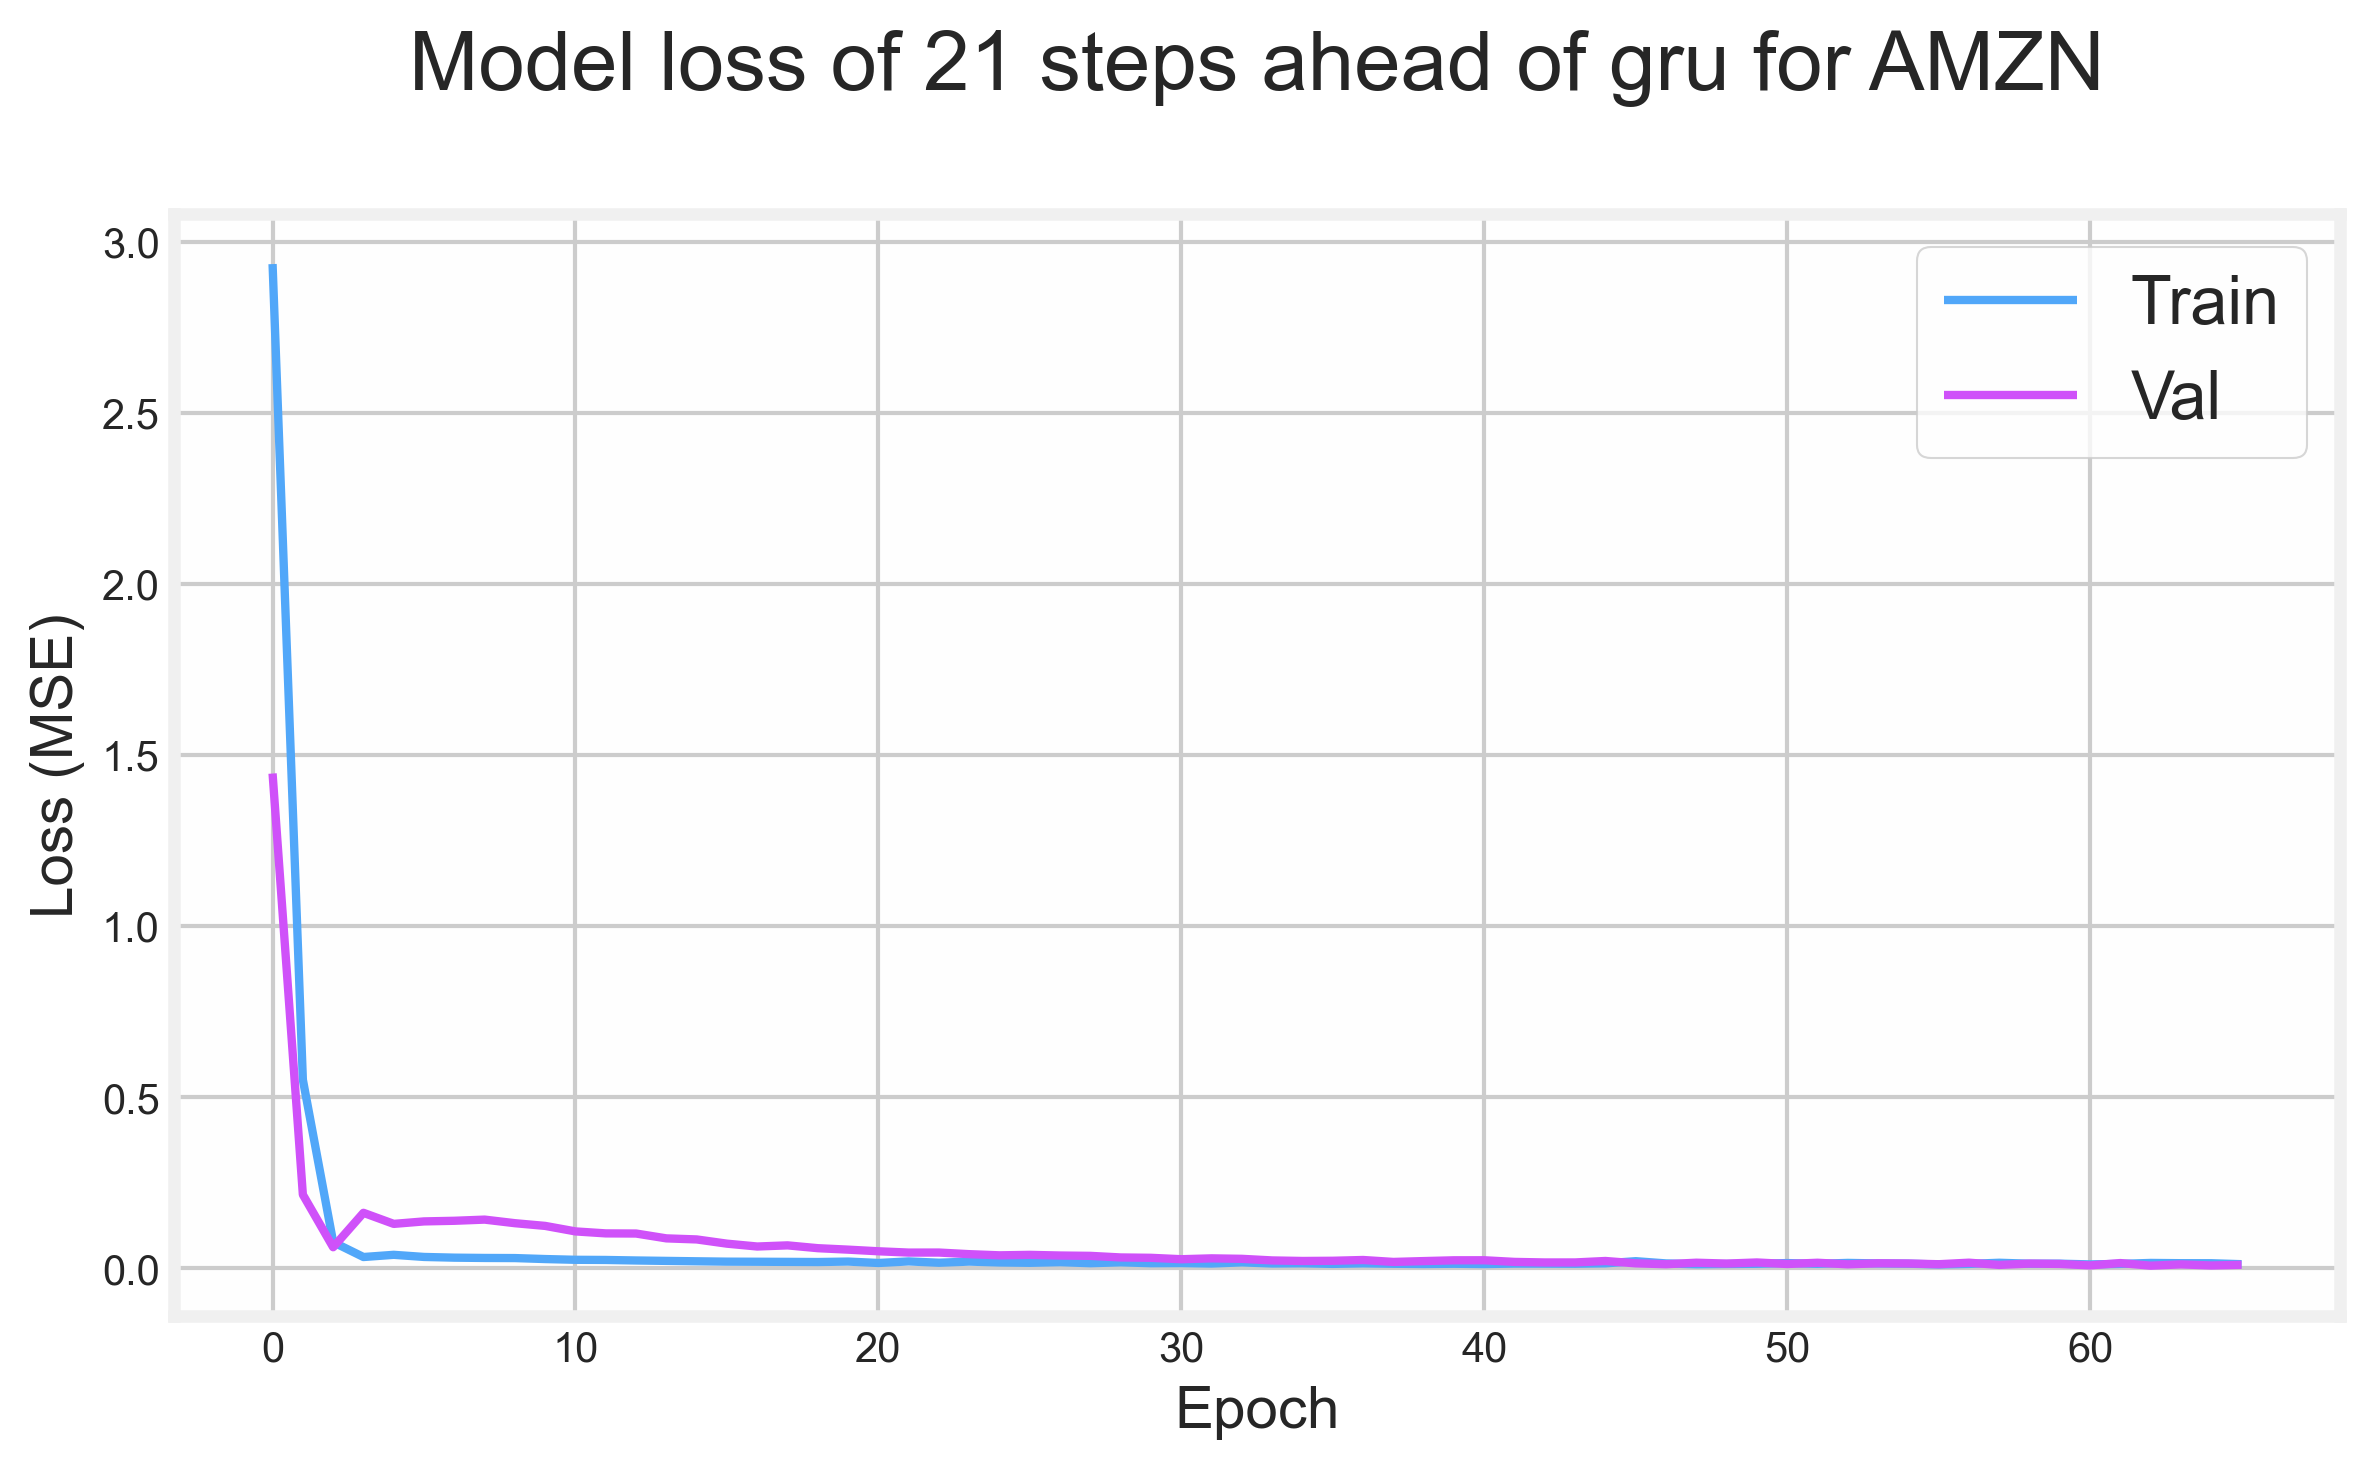

In [28]:
for key in params.keys():
    history = np.load(PATH + hist_folder + history_name +
                      '.npy', allow_pickle='TRUE').item()

    plotting.plot_train_val_loss(
        history, key, ticker, n_steps, n_steps_ahead)

## Save the fitted models

In [29]:
lags = str(n_steps)

if do_training:
    for key in params.keys():
        params[key]['model'].save('../../trained-RNNs/' + folder + model_name + key + lags +
                                  '.hdf5', overwrite=True)

## Prediction

In [30]:
y_test = y_test.reshape(-1, n_steps_ahead)

for key in params.keys():
    model = params[key]['model']
    model.summary()

    params[key]['pred_train'] = model.predict(x_train, verbose=True)
    for i in range(n_steps_ahead):
        params[key]['MSE_train steps ahead: ' + str(i+1)] = mean_squared_error(y_train[:, i],
                                                                               params[key]['pred_train'][:, i])
    params[key]['pred_val'] = model.predict(x_val, verbose=True)    

    params[key]['pred_test'] = model.predict(x_test, verbose=True)
    for i in range(n_steps_ahead):
        params[key]['MSE_test steps ahead:' +
                    str(i+1)] = mean_squared_error(y_test[:, i], params[key]['pred_test'][:, i])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 60)                11340     
                                                                 
 dropout_1 (Dropout)         (None, 60)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 61        
                                                                 
Total params: 11,401
Trainable params: 11,401
Non-trainable params: 0
_________________________________________________________________
18/18 [==============================] - 0s 1ms/step


In [31]:
# get the results
compare = params.keys() 

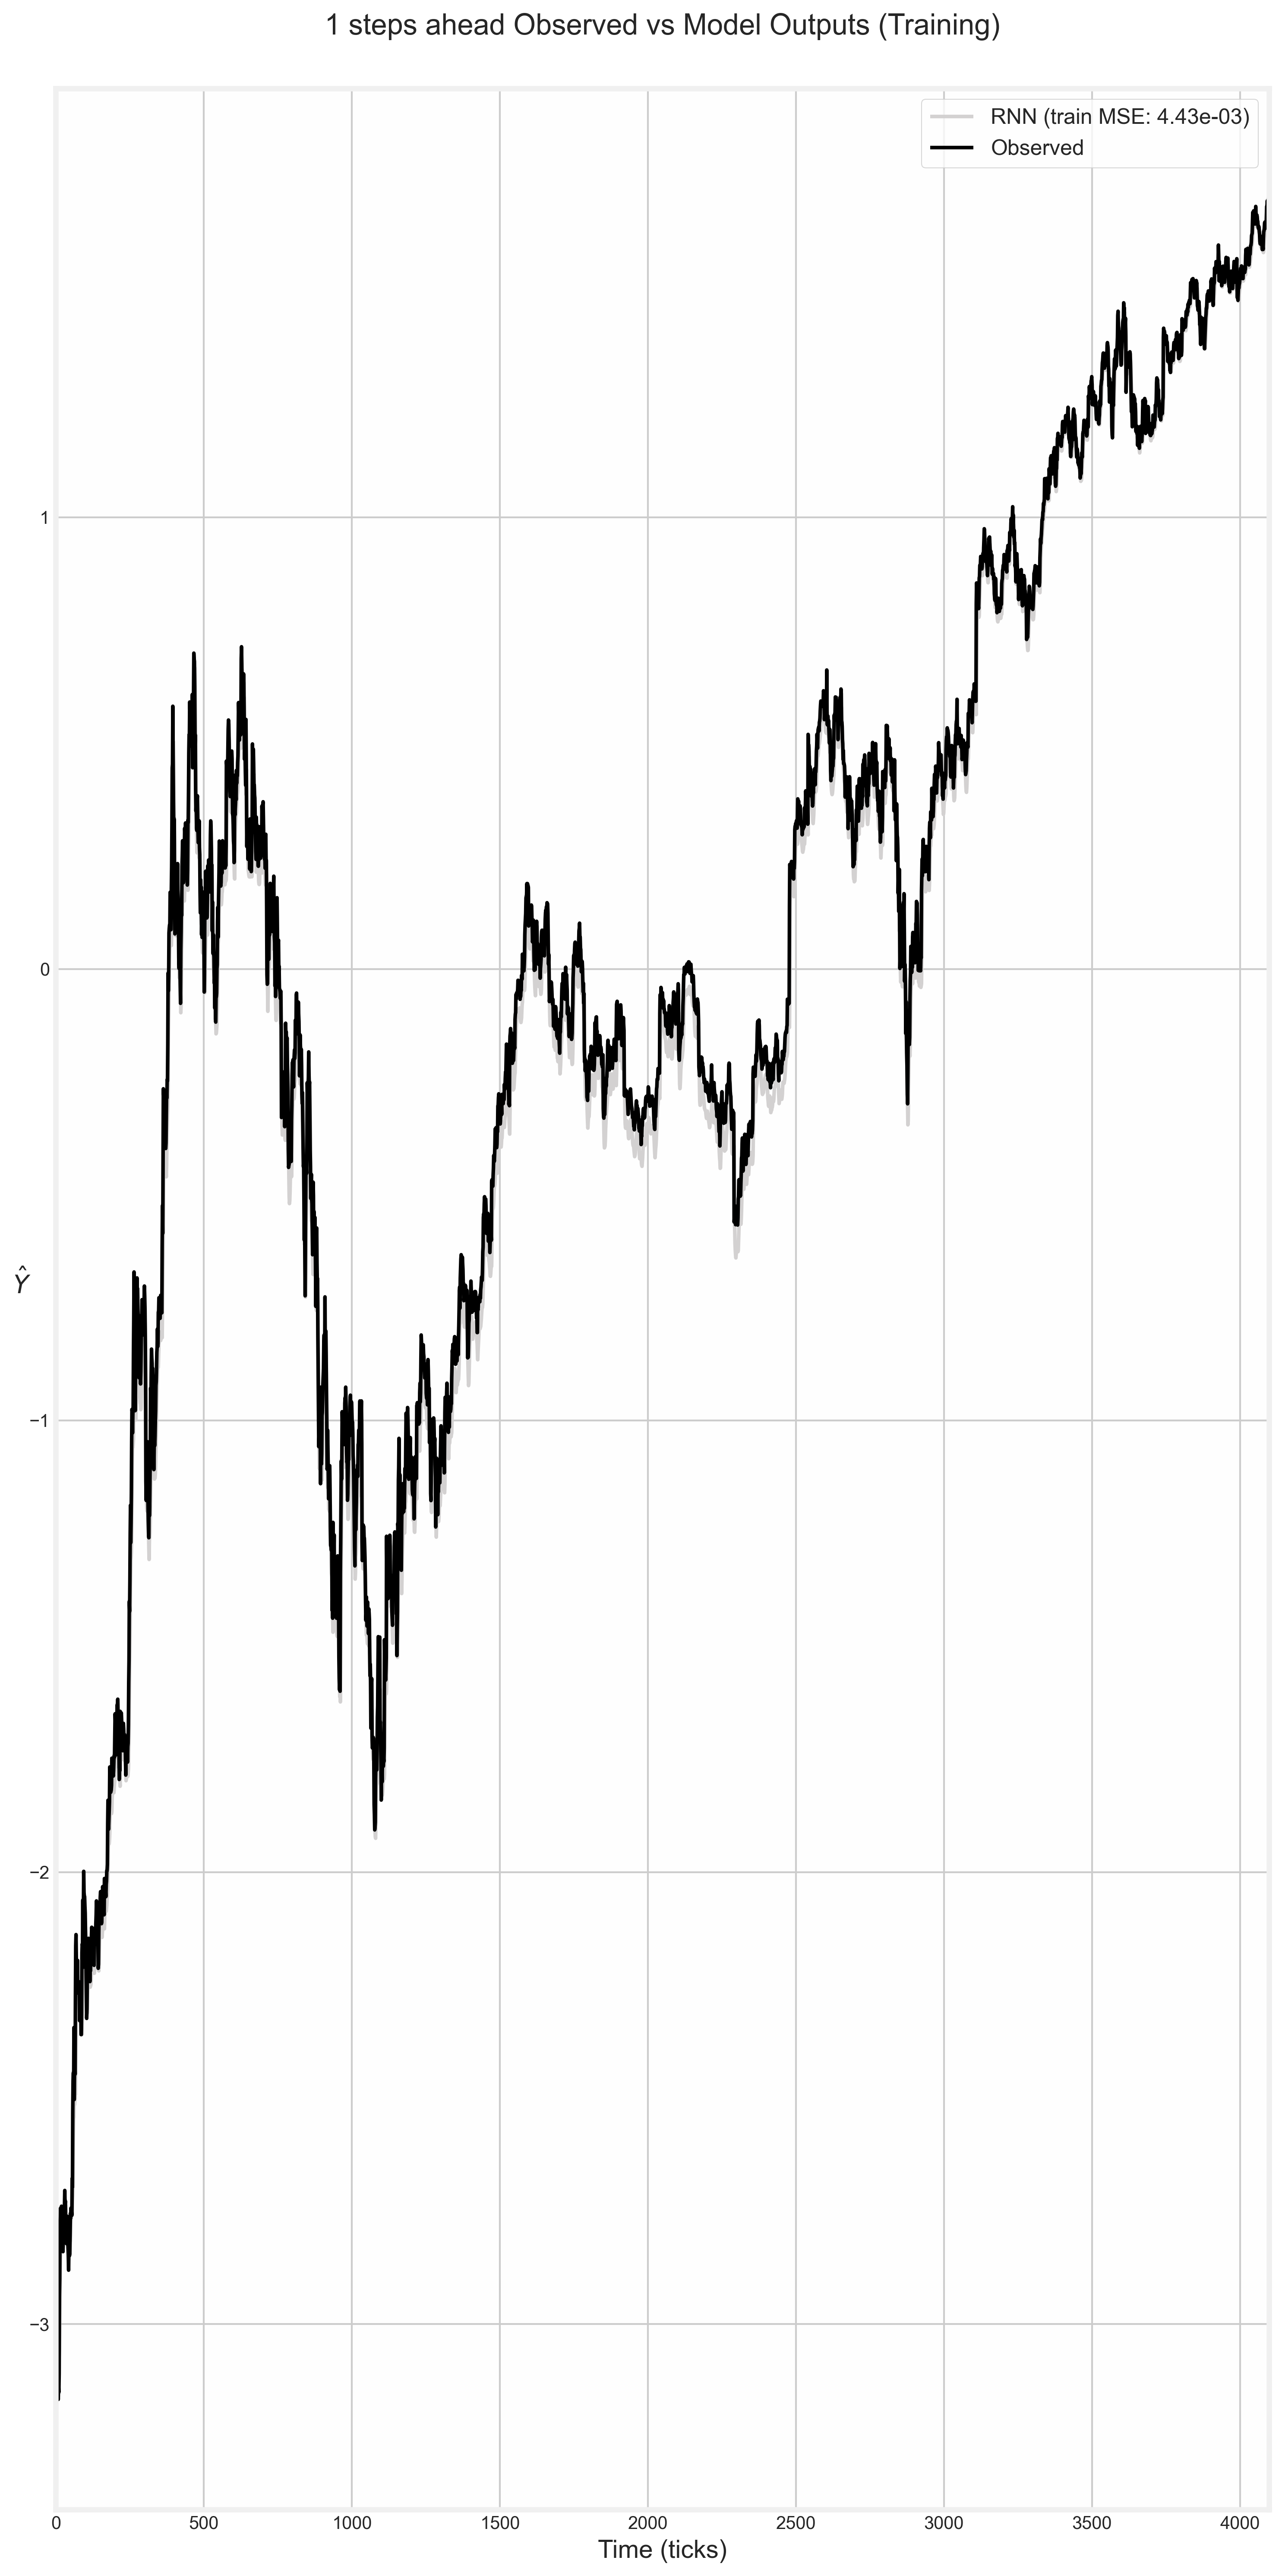

In [32]:
title_train = ' steps ahead Observed vs Model Outputs (Training)'
plotting.prediction_vs_observed_plot(
    compare, params, n_steps_ahead, y_train, y_test, title=title_train, trainplot=True)

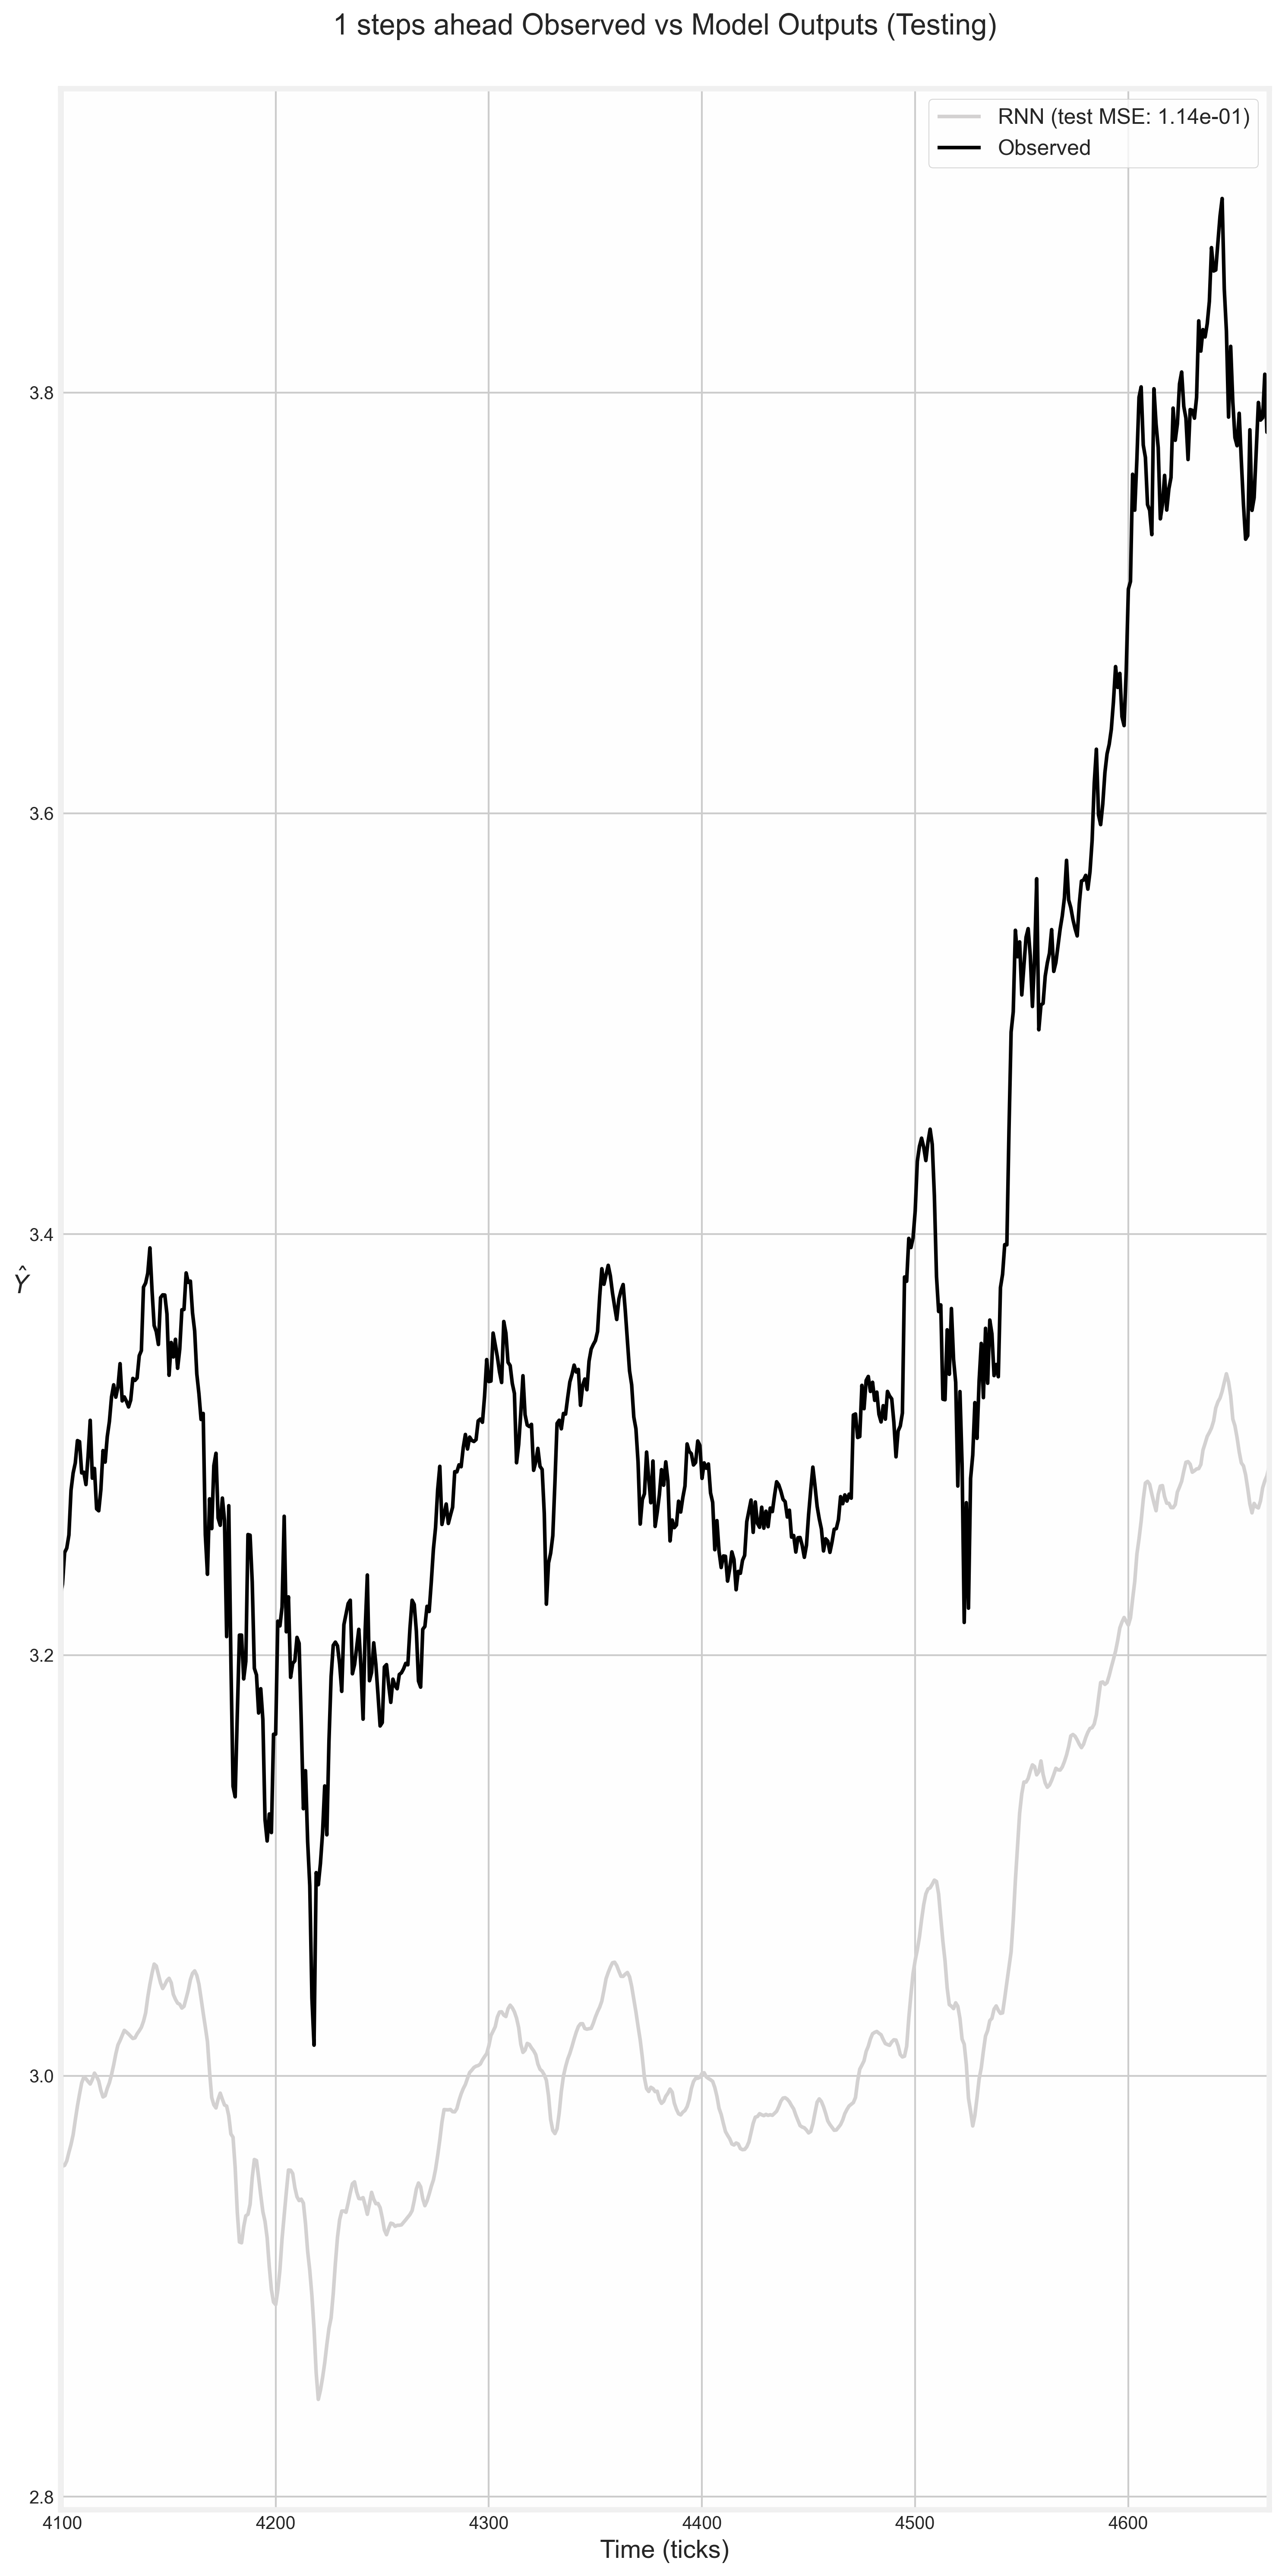

In [33]:
title_test = ' steps ahead Observed vs Model Outputs (Testing)'
plotting.prediction_vs_observed_plot(
    compare, params, n_steps_ahead, y_train, y_test, title=title_test, trainplot=False)

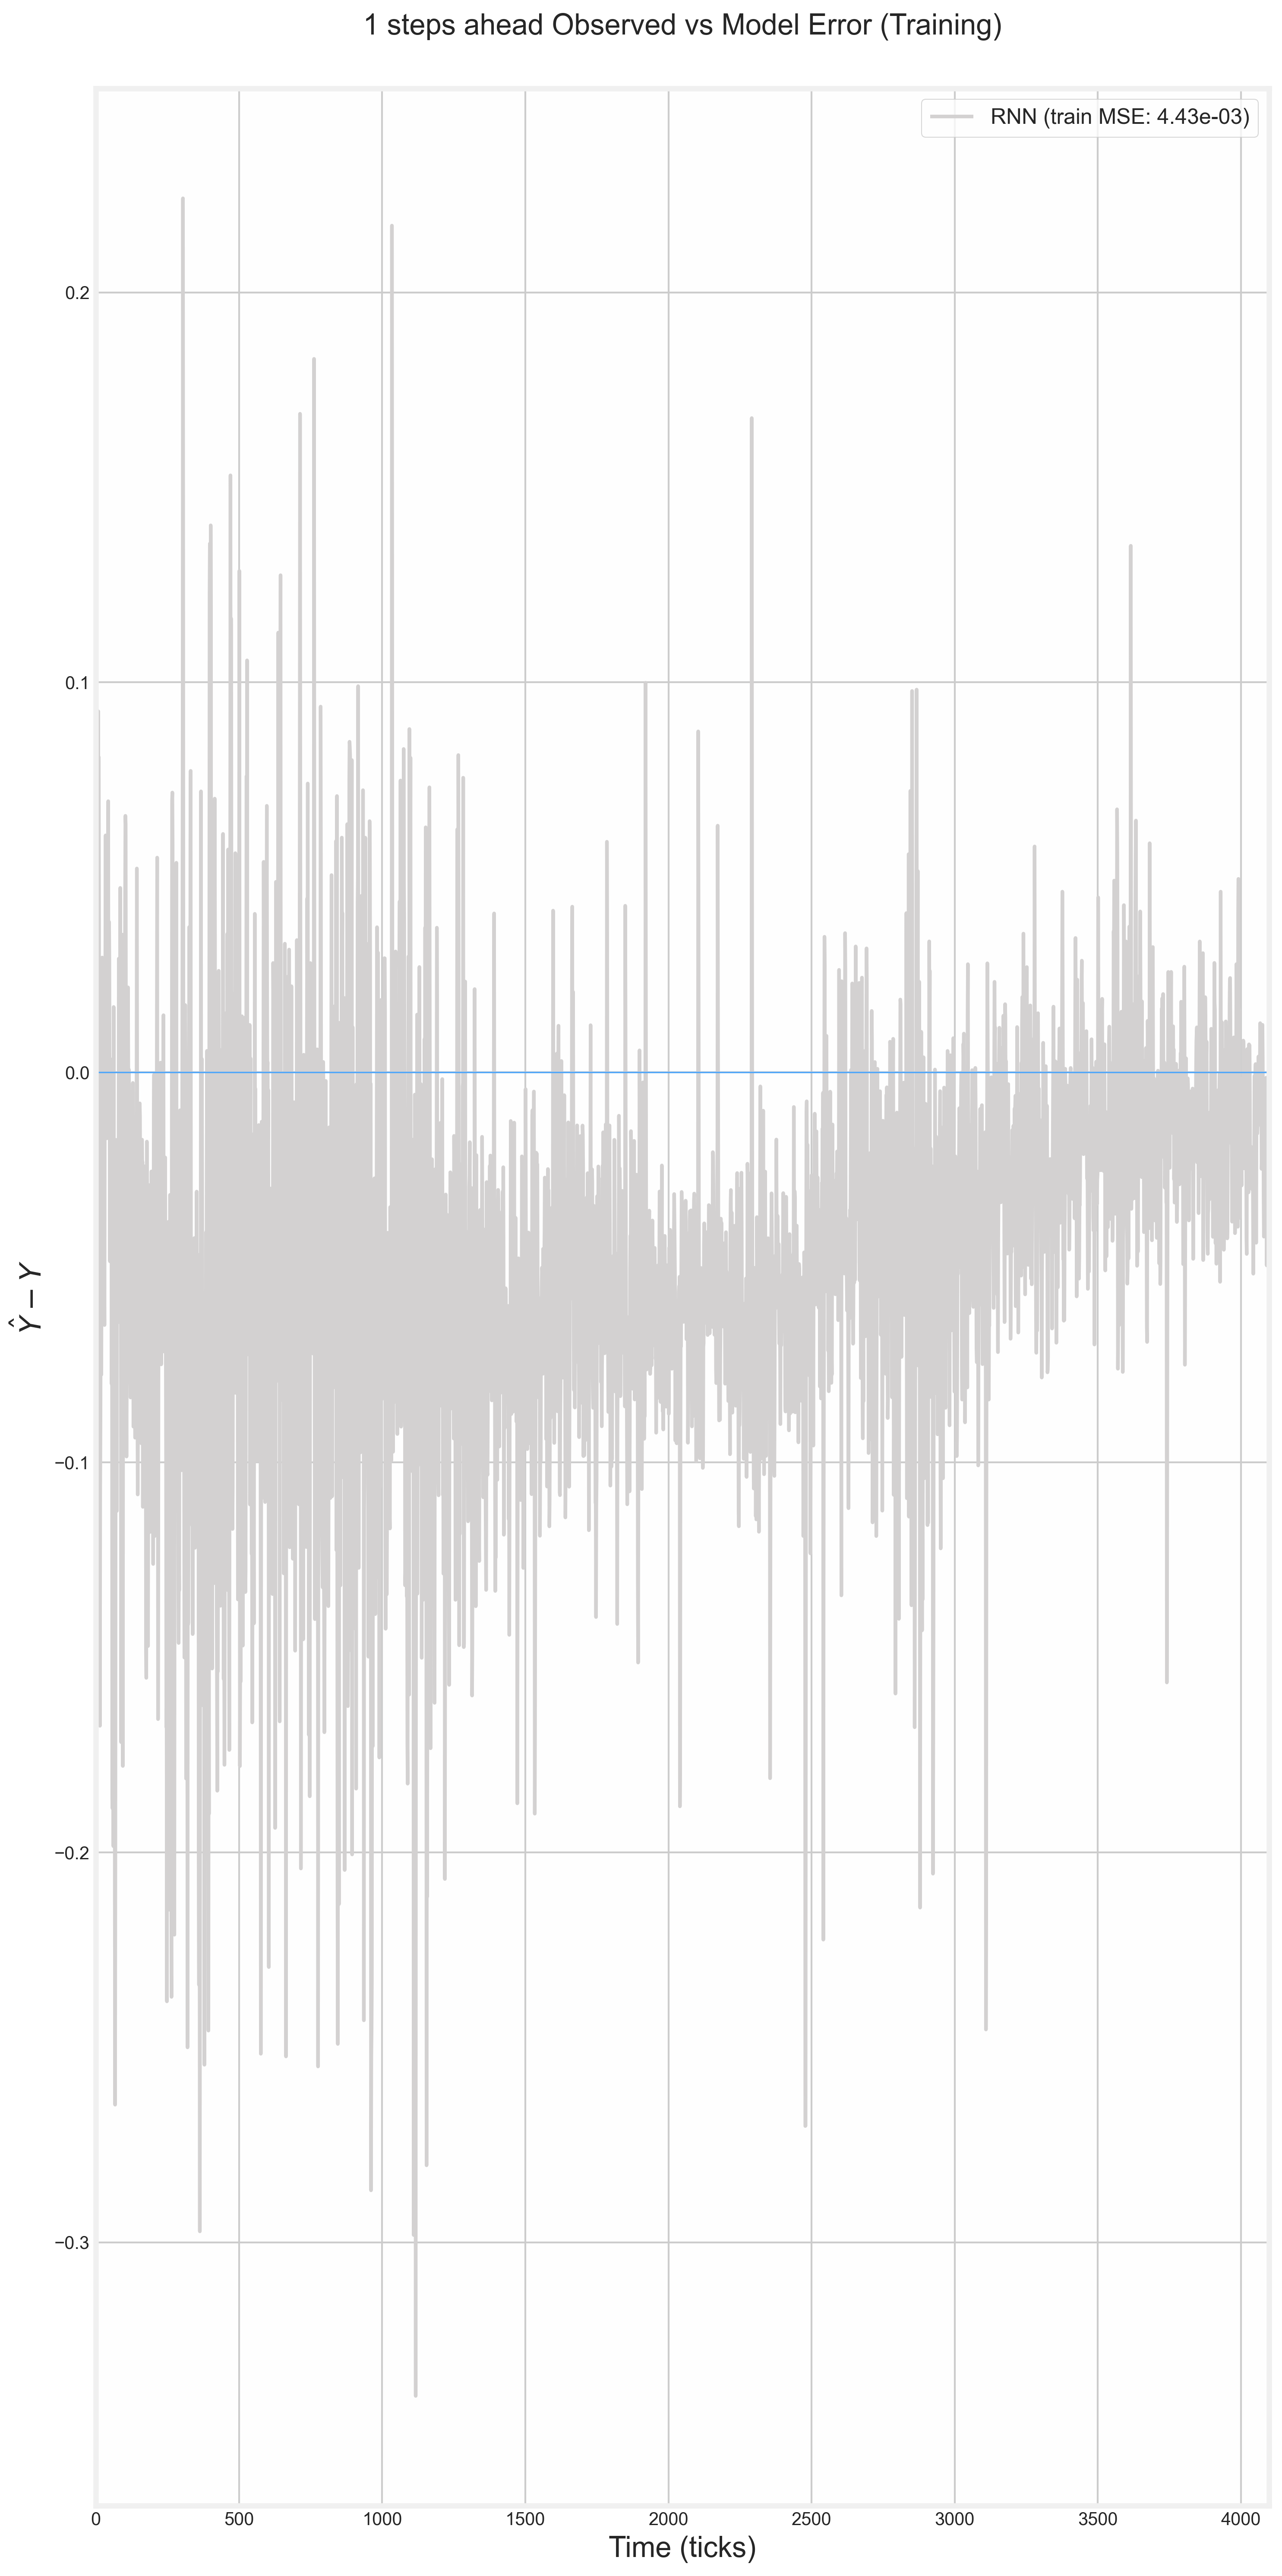

In [34]:
title_train = 'steps ahead Observed vs Model Error (Training)'
plotting.error_plot_timeline(
    compare, params, n_steps_ahead, y_train, y_test, title=title_train, trainplot=True)

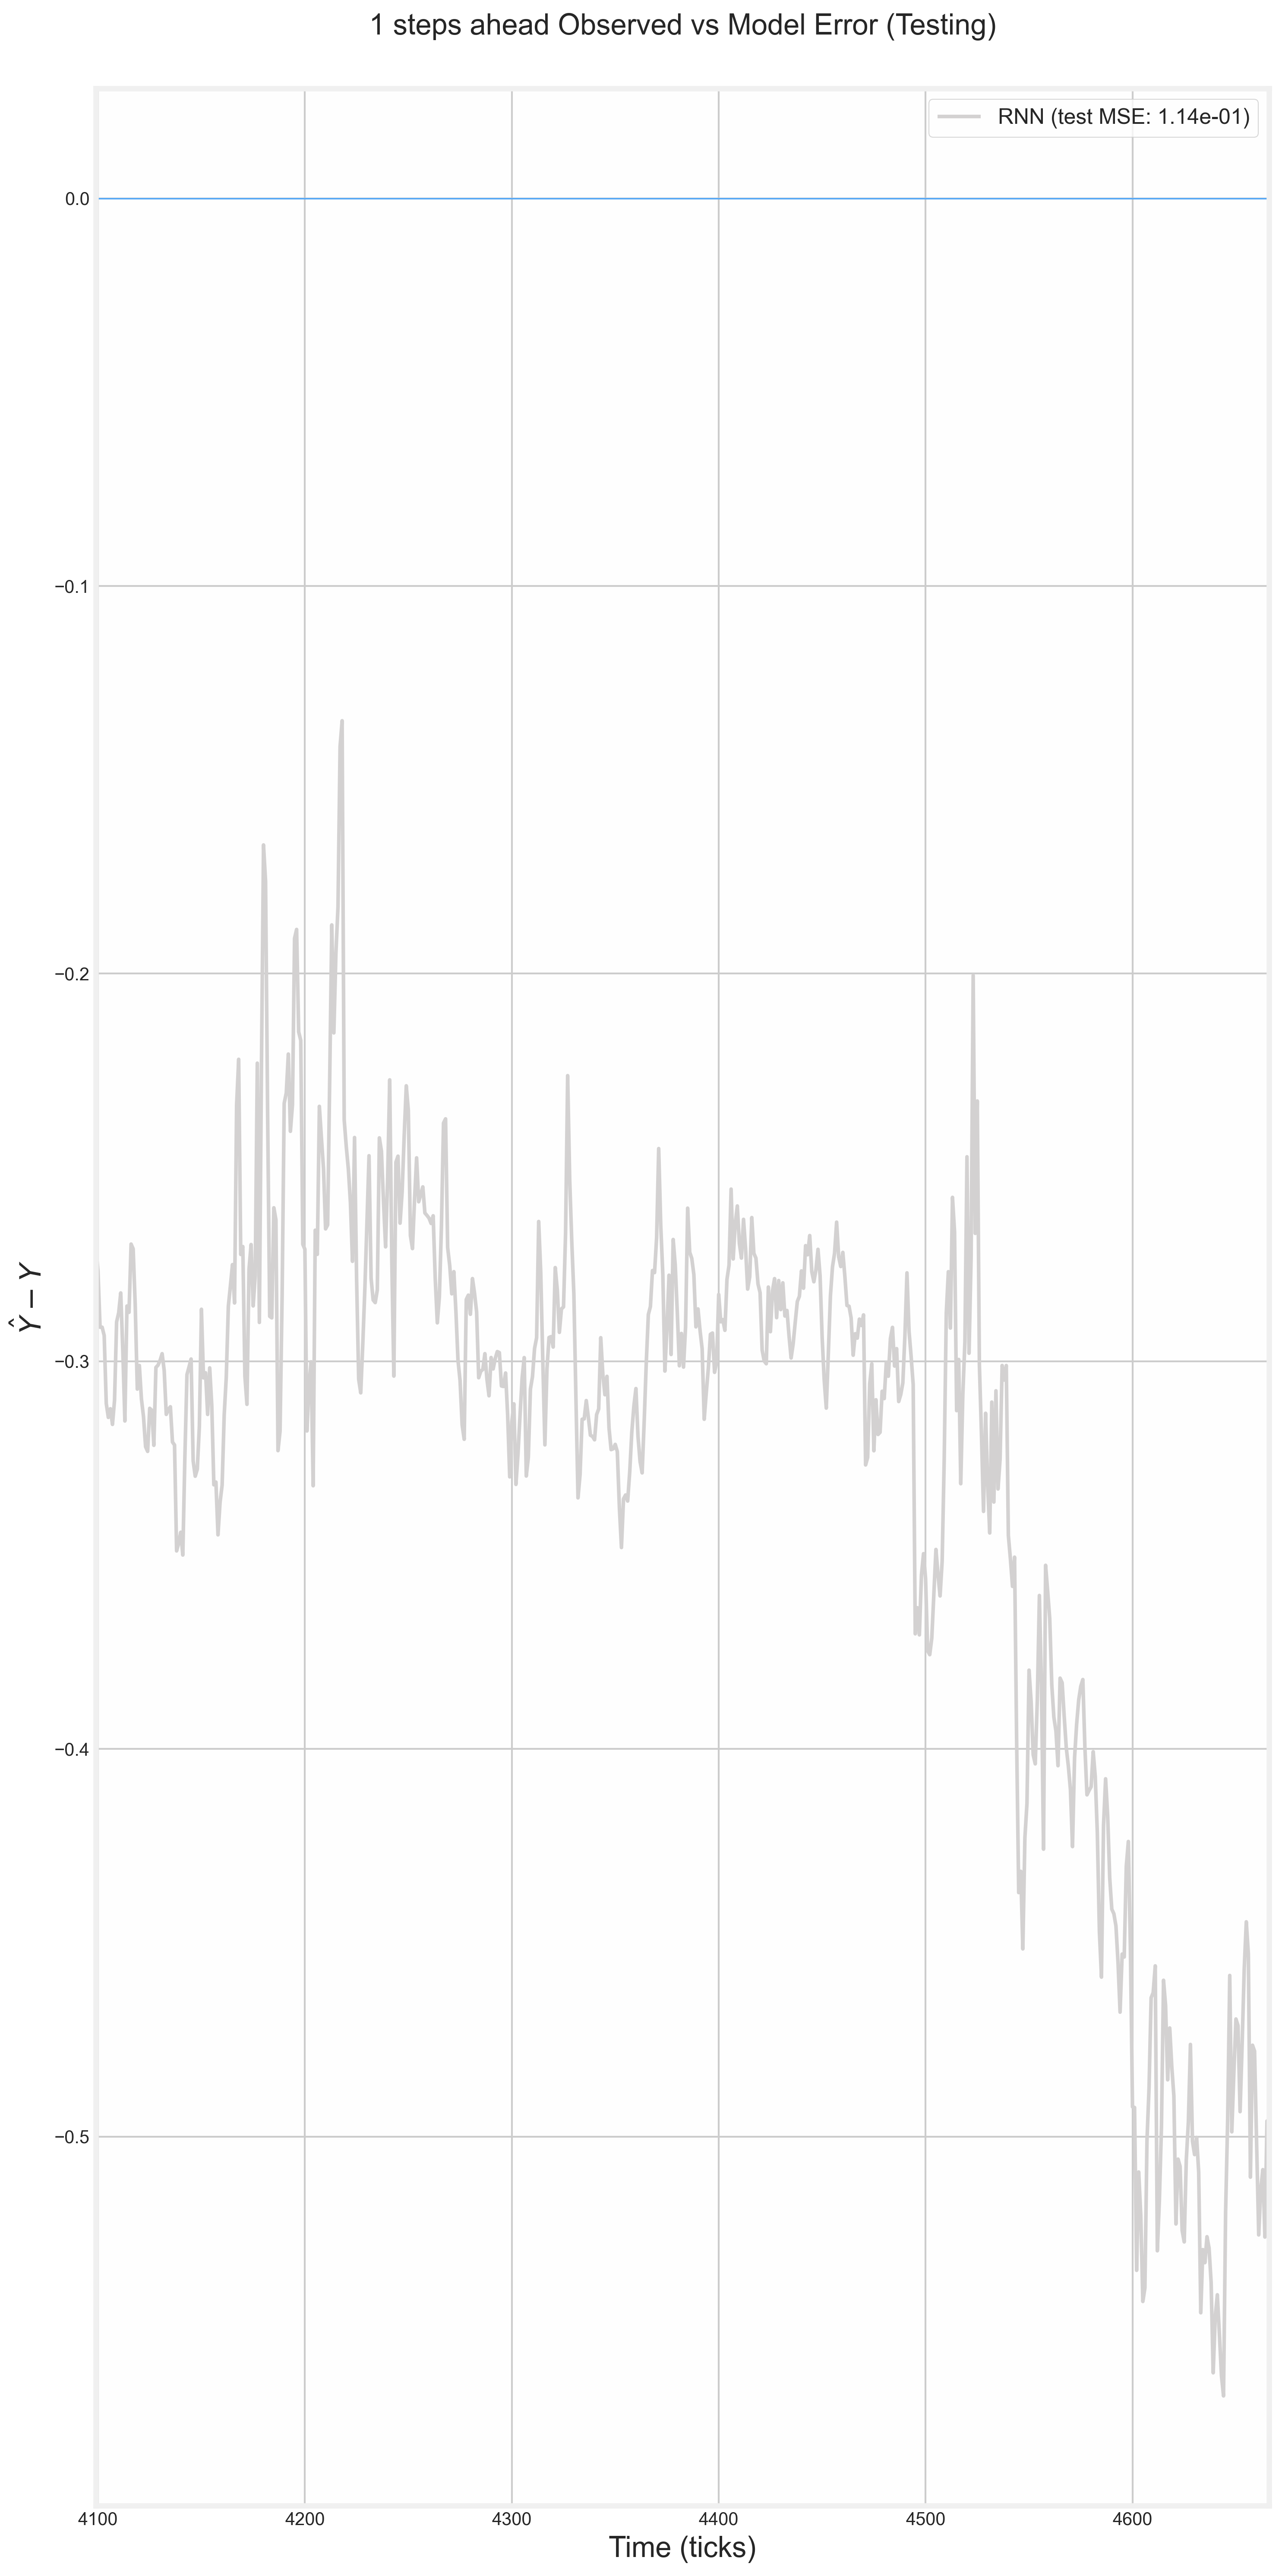

In [35]:
title_test = 'steps ahead Observed vs Model Error (Testing)'
plotting.error_plot_timeline(
    compare, params, n_steps_ahead, y_train, y_test, title=title_test, trainplot=False)

[0.11380883695270608]


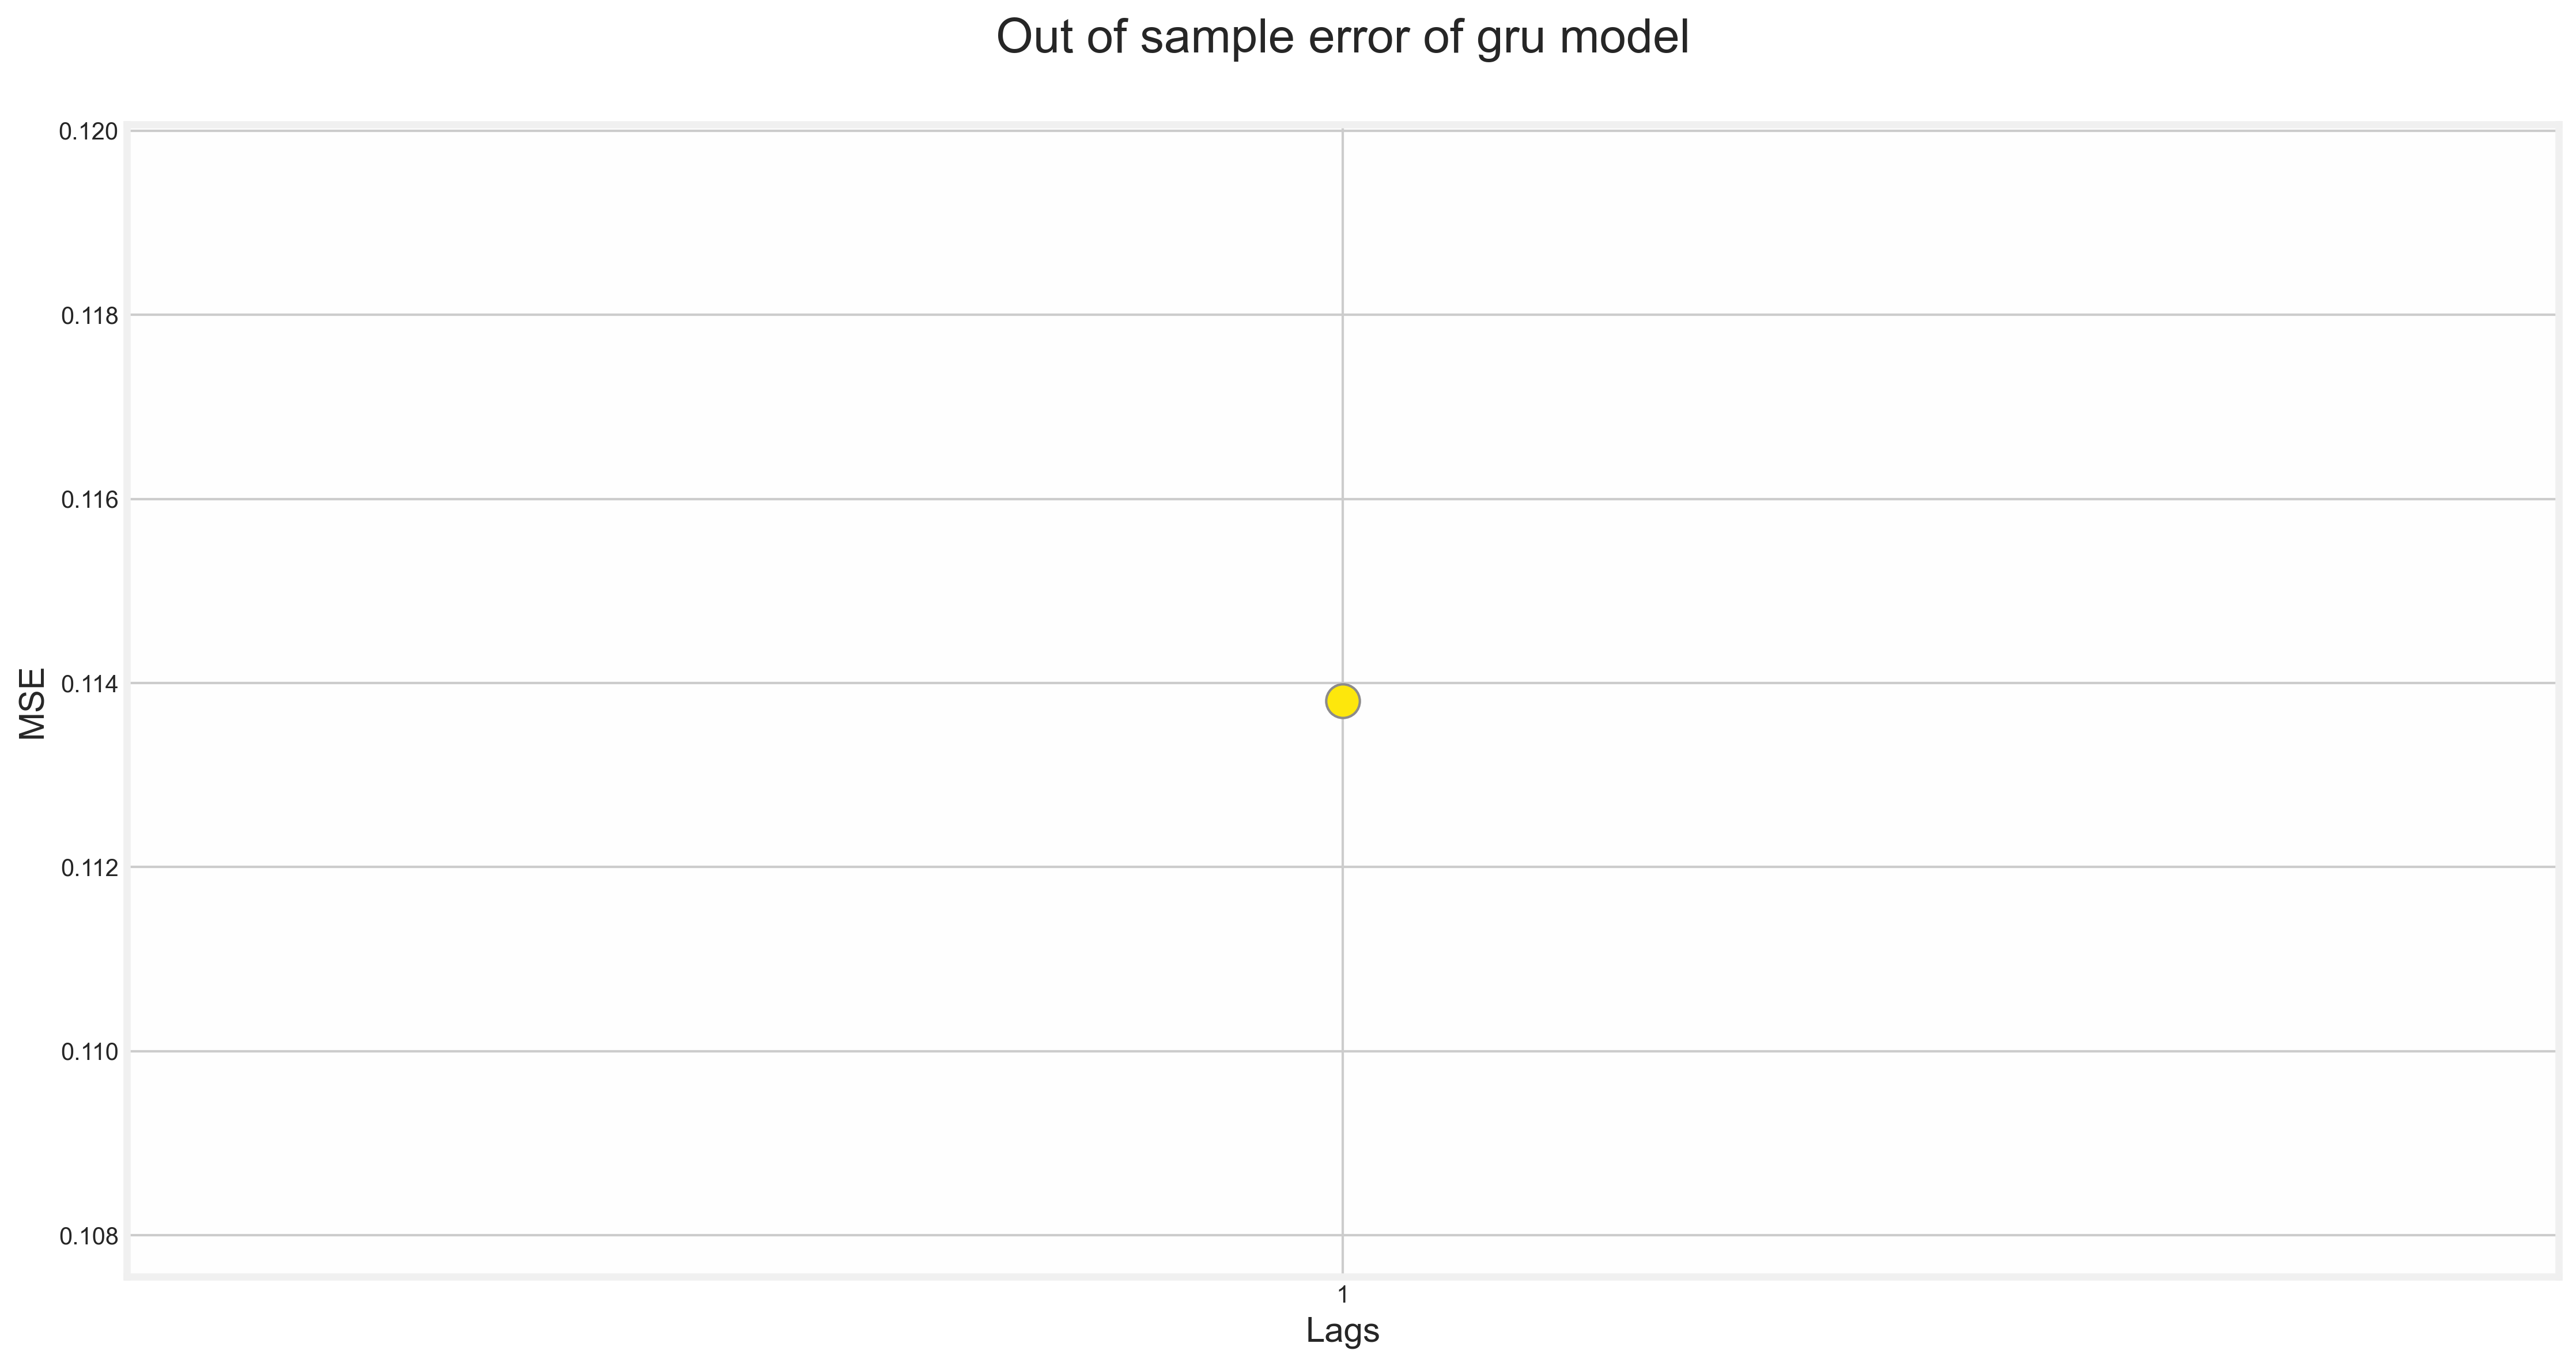

In [36]:
for key in compare:
    plt.figure(figsize=(15, 8))
    title = 'Out of sample error of ' + key + ' model'
    plotting.error_plot(y_test, params[key]['pred_test'], n_steps_ahead, title)

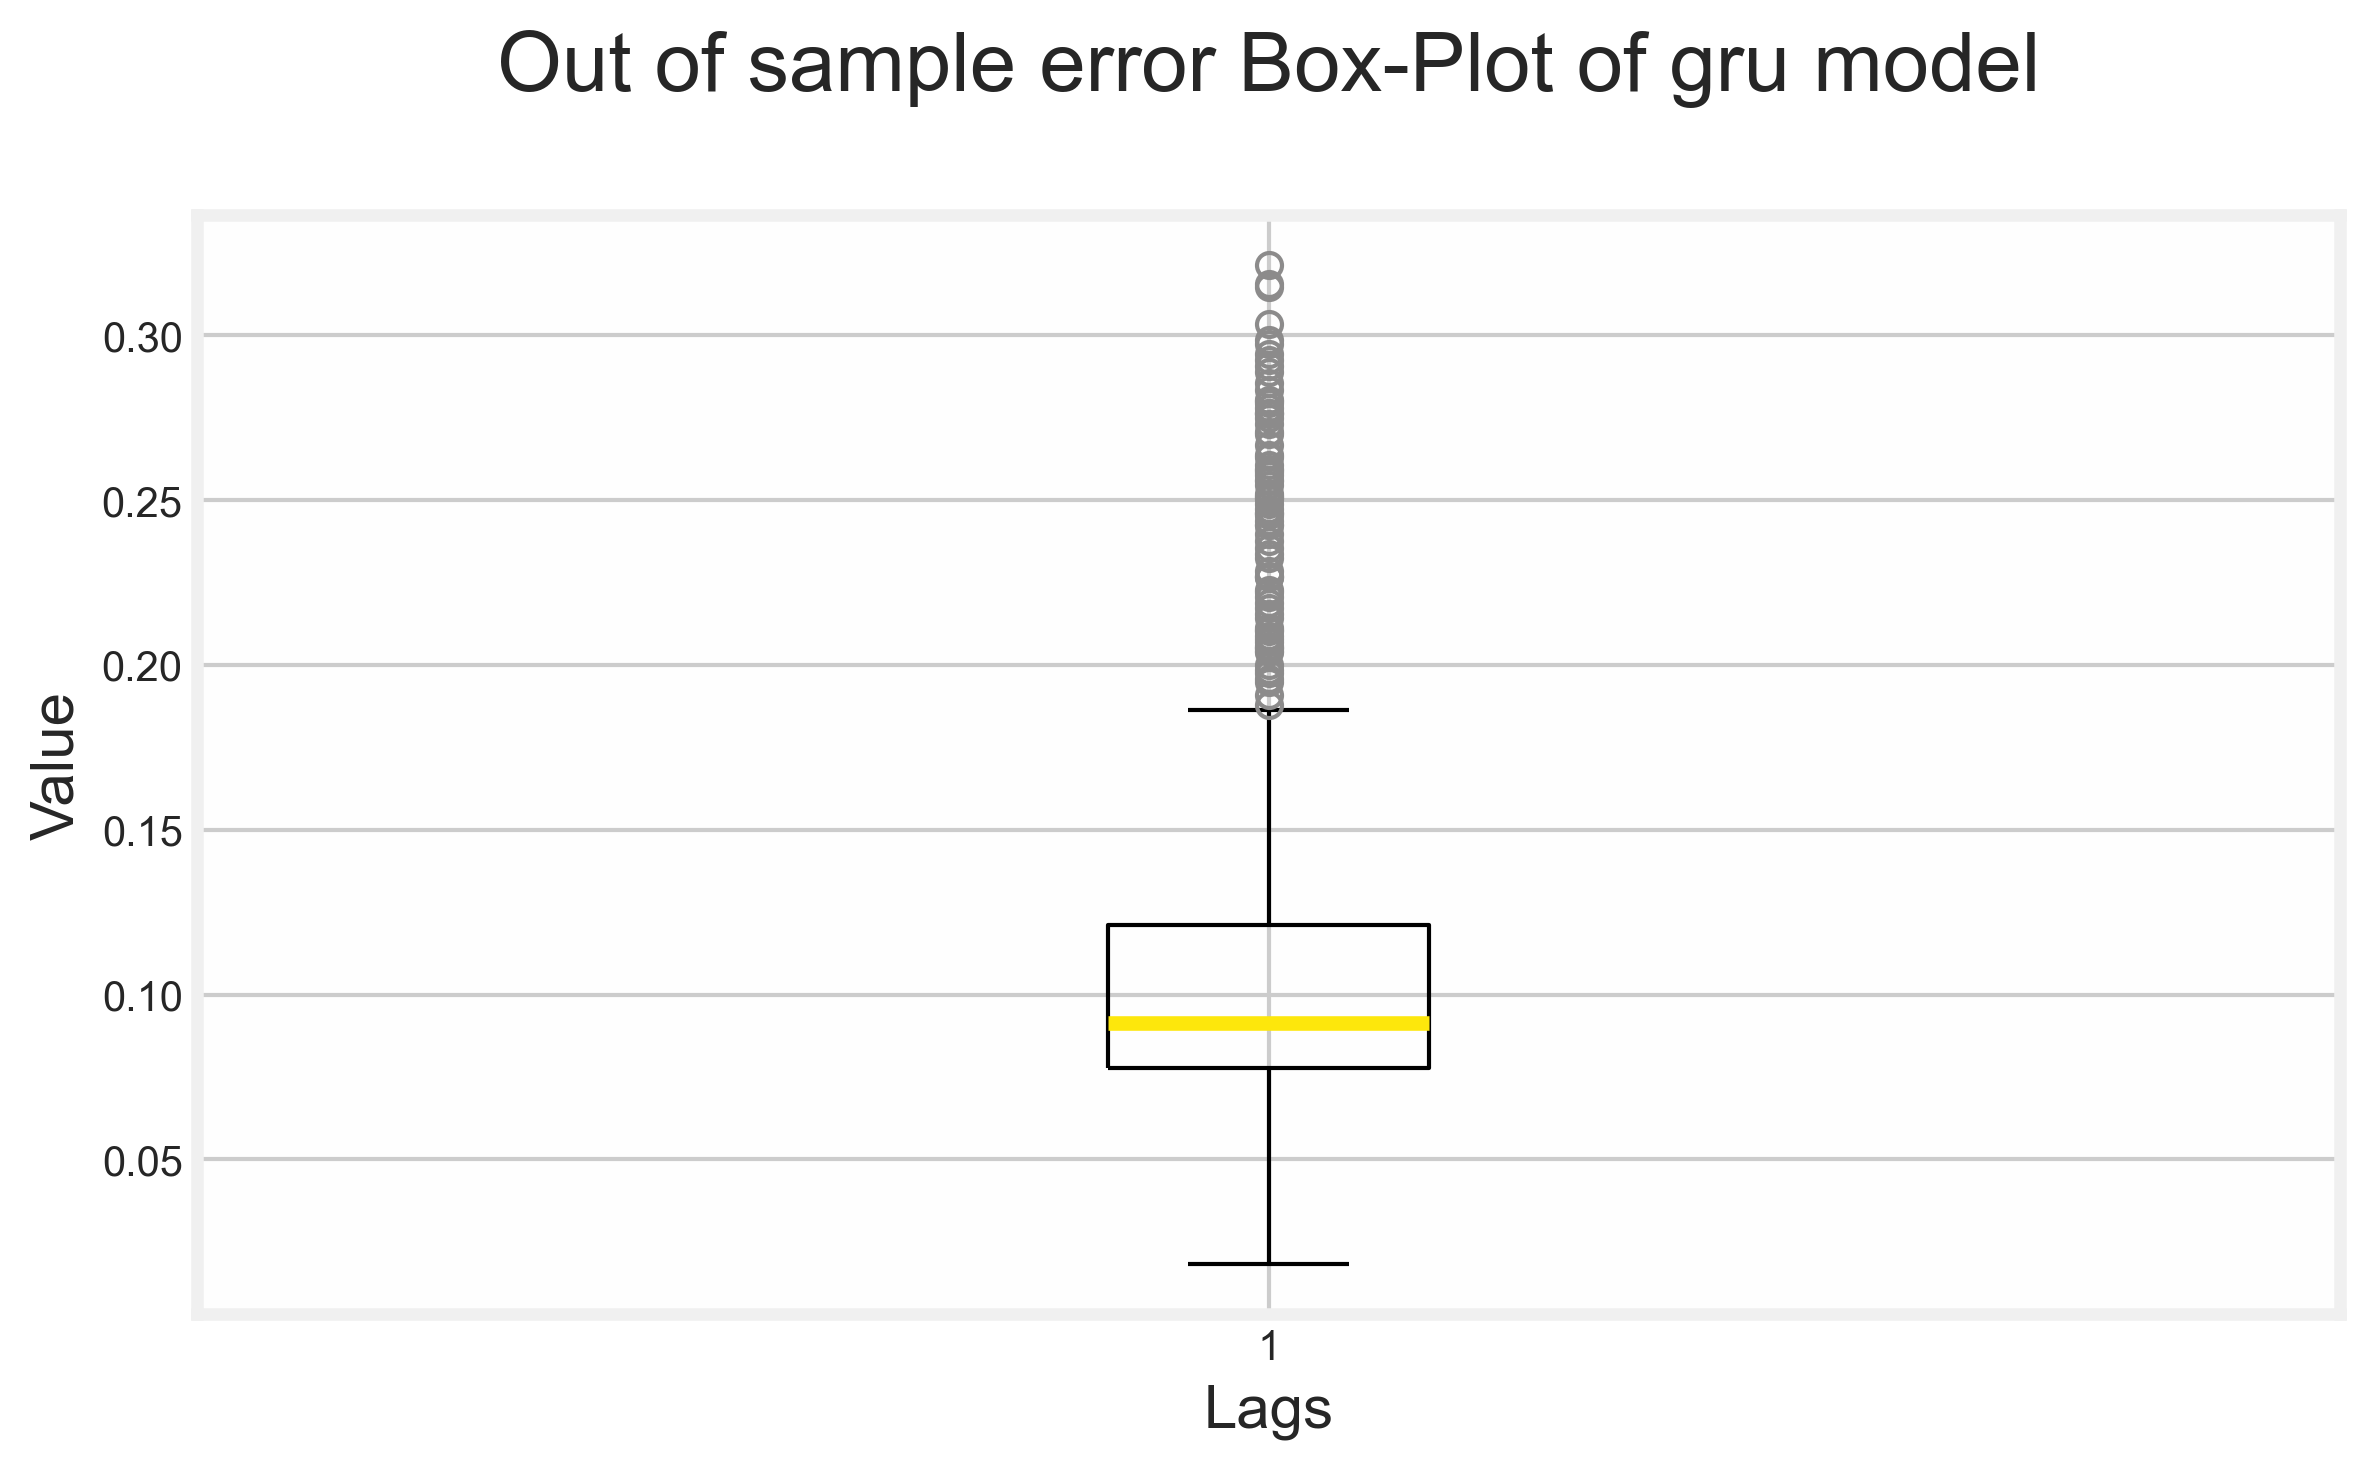

In [37]:
for key in compare:
    title = 'Out of sample error Box-Plot of ' + key + ' model'
    plotting.error_boxplot(
        y_test, params[key]['pred_test'], n_steps_ahead, title)

# Model Diagnostics

## Evaluate model

To gain more insights about the overall performance of the model, we use tensorflow's `evaluate()` function. 

In [38]:
# store the model performance
model_performance = {}

lags = str(n_steps)

# init the names

performance_name_train = key + '_' + ticker + '_' + lags + '_train_price'
performance_name_val = key + '_' + ticker + '_' + lags + '_val_price'
performance_name_test = key + '_' + ticker + '_' + lags + '_test_price'


# eval the model
for key in params.keys():
    model = params[key]['model']
    
    model_performance[performance_name_train] = model.evaluate(x_train, y_train)
    model_performance[performance_name_val] = model.evaluate(x_val, y_val)
    model_performance[performance_name_test] = model.evaluate(x_test, y_test)

    
metrics_evaluate = ma.get_eval_df(model_performance)
metrics_evaluate

18/18 [==============================] - 0s 1ms/step - loss: 0.1138 - mse: 0.1138 - mae: 0.3276


,MSE,MAE
gru_AMZN_21_train_price,0.00443251,0.05231054
gru_AMZN_21_val_price,0.01114547,0.08133493
gru_AMZN_21_test_price,0.11380883,0.32755587


In [39]:
# save the date frame
evaluate_path = '../../model_evaluate/'
evaluate_folder = '{}/'.format(ticker)

evaluate_file_name = '_evaluate_df-price-{}-{}-n_steps.csv'.format(
    ticker, n_steps)


metrics_evaluate.to_csv(
    evaluate_path + evaluate_folder + key + evaluate_file_name)

## Grid search

In [40]:
model_scores = results_df.filter(regex=r'split\d*_test_score')
model_1_scores = model_scores.iloc[0].values  # scores of the best model
model_2_scores = model_scores.iloc[1].values  # scores of the second-best model

differences = model_1_scores - model_2_scores
tscv = TimeSeriesSplit(n_splits=5)

n = differences.shape[0]  # number of test sets
df = n - 1
n_train = len(list(tscv.split(x_train, y_train))[0][0])
n_test = len(list(tscv.split(x_train, y_train))[0][1])

t_stat, p_val = ma.compute_corrected_ttest(differences, df, n_train, n_test)
print(f"Corrected t-value: {t_stat:.3f}\n"
      f"Corrected p-value: {p_val:.3f}")

Corrected t-value: 0.057
Corrected p-value: 0.479


In [41]:
t_stat_uncorrected = (
    np.mean(differences) / np.sqrt(np.var(differences, ddof=1) / n)
)
p_val_uncorrected = t.sf(np.abs(t_stat_uncorrected), df)

print(f"Uncorrected t-value: {t_stat_uncorrected:.3f}\n"
      f"Uncorrected p-value: {p_val_uncorrected:.3f}")


Uncorrected t-value: 0.128
Uncorrected p-value: 0.452


In [42]:
# intitialize random variable
t_post = t(
    df, loc=np.mean(differences),
    scale=ma.corrected_std(differences, n_train, n_test)
)

Saving figure:  post_dist_plot_price_AMZN_n_steps_21_n_steps_ahead_1


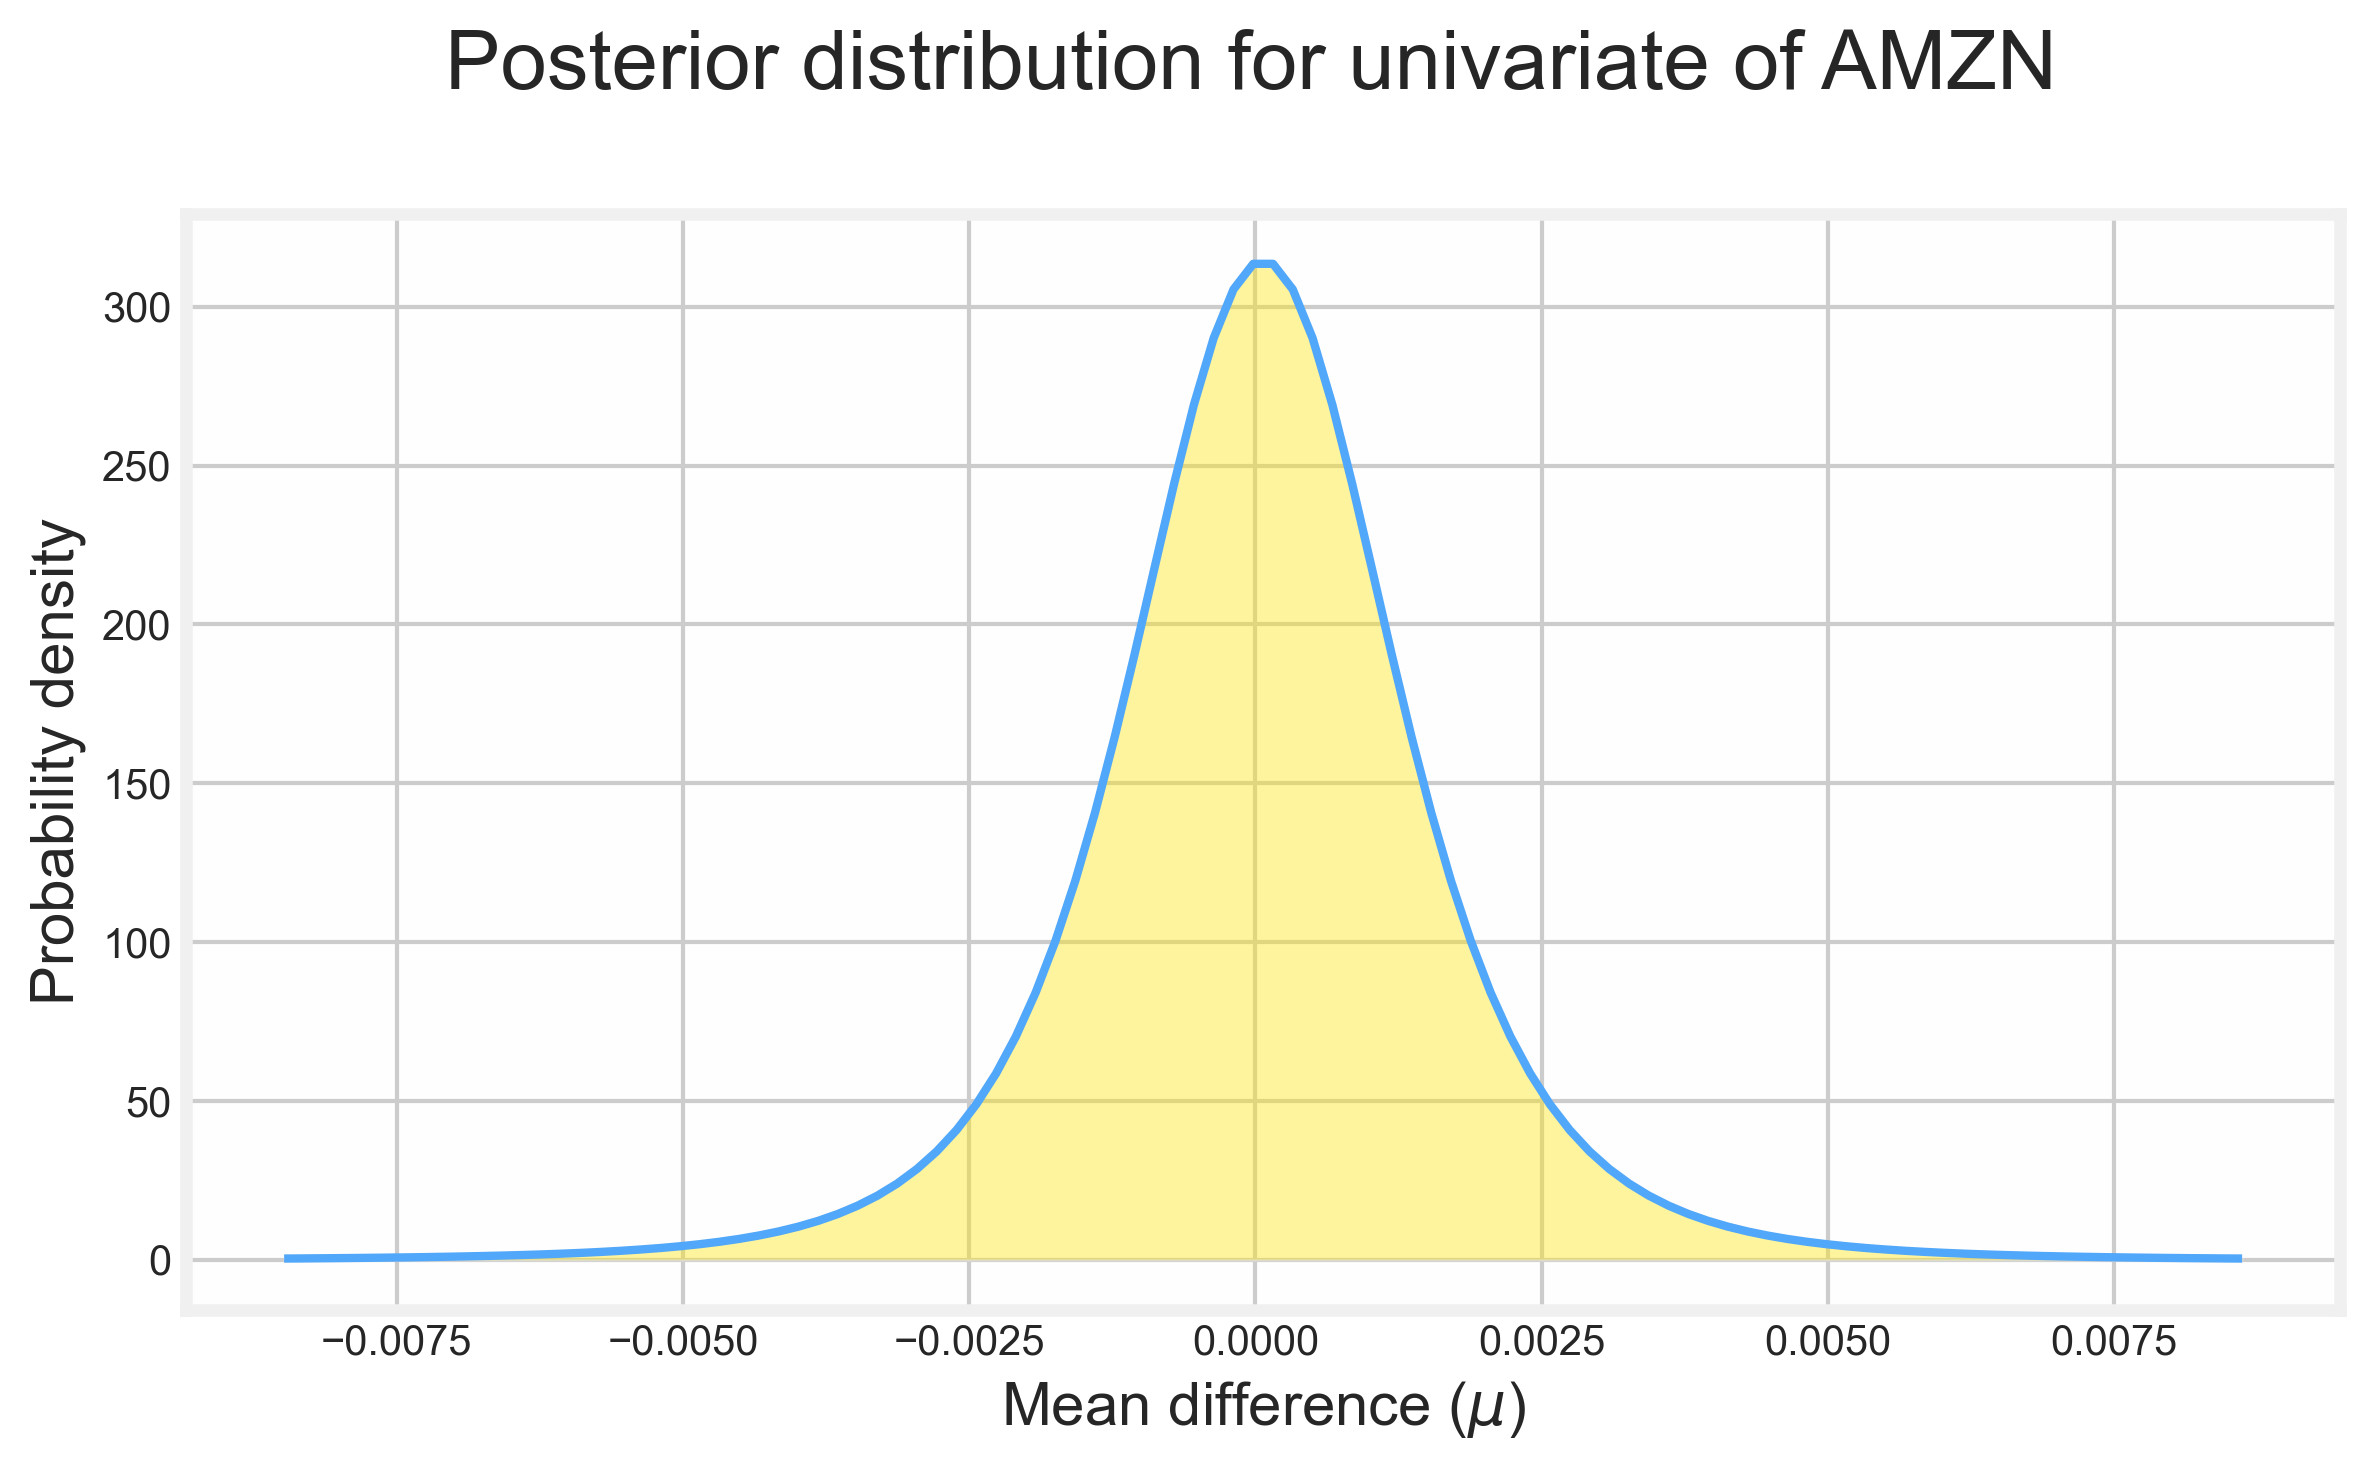

In [43]:
plotting.plot_post_distribution(t_post, ticker, n_steps, n_steps_ahead)

In [44]:
better_prob = 1 - t_post.cdf(0)

print(f"Probability of model {model_scores.index[0]} being more accurate than "
      f"{model_scores.index[1]}: {better_prob:.3f}")
print(f"Probability of model {model_scores.index[1]} being more accurate than "
      f"{model_scores.index[0]}: {1 - better_prob:.3f}")

Probability of model 0 being more accurate than 1: 0.521
Probability of model 1 being more accurate than 0: 0.479


Saving figure:  Histogramm_plot_price_AMZN_n_steps_21_n_steps_ahead_1


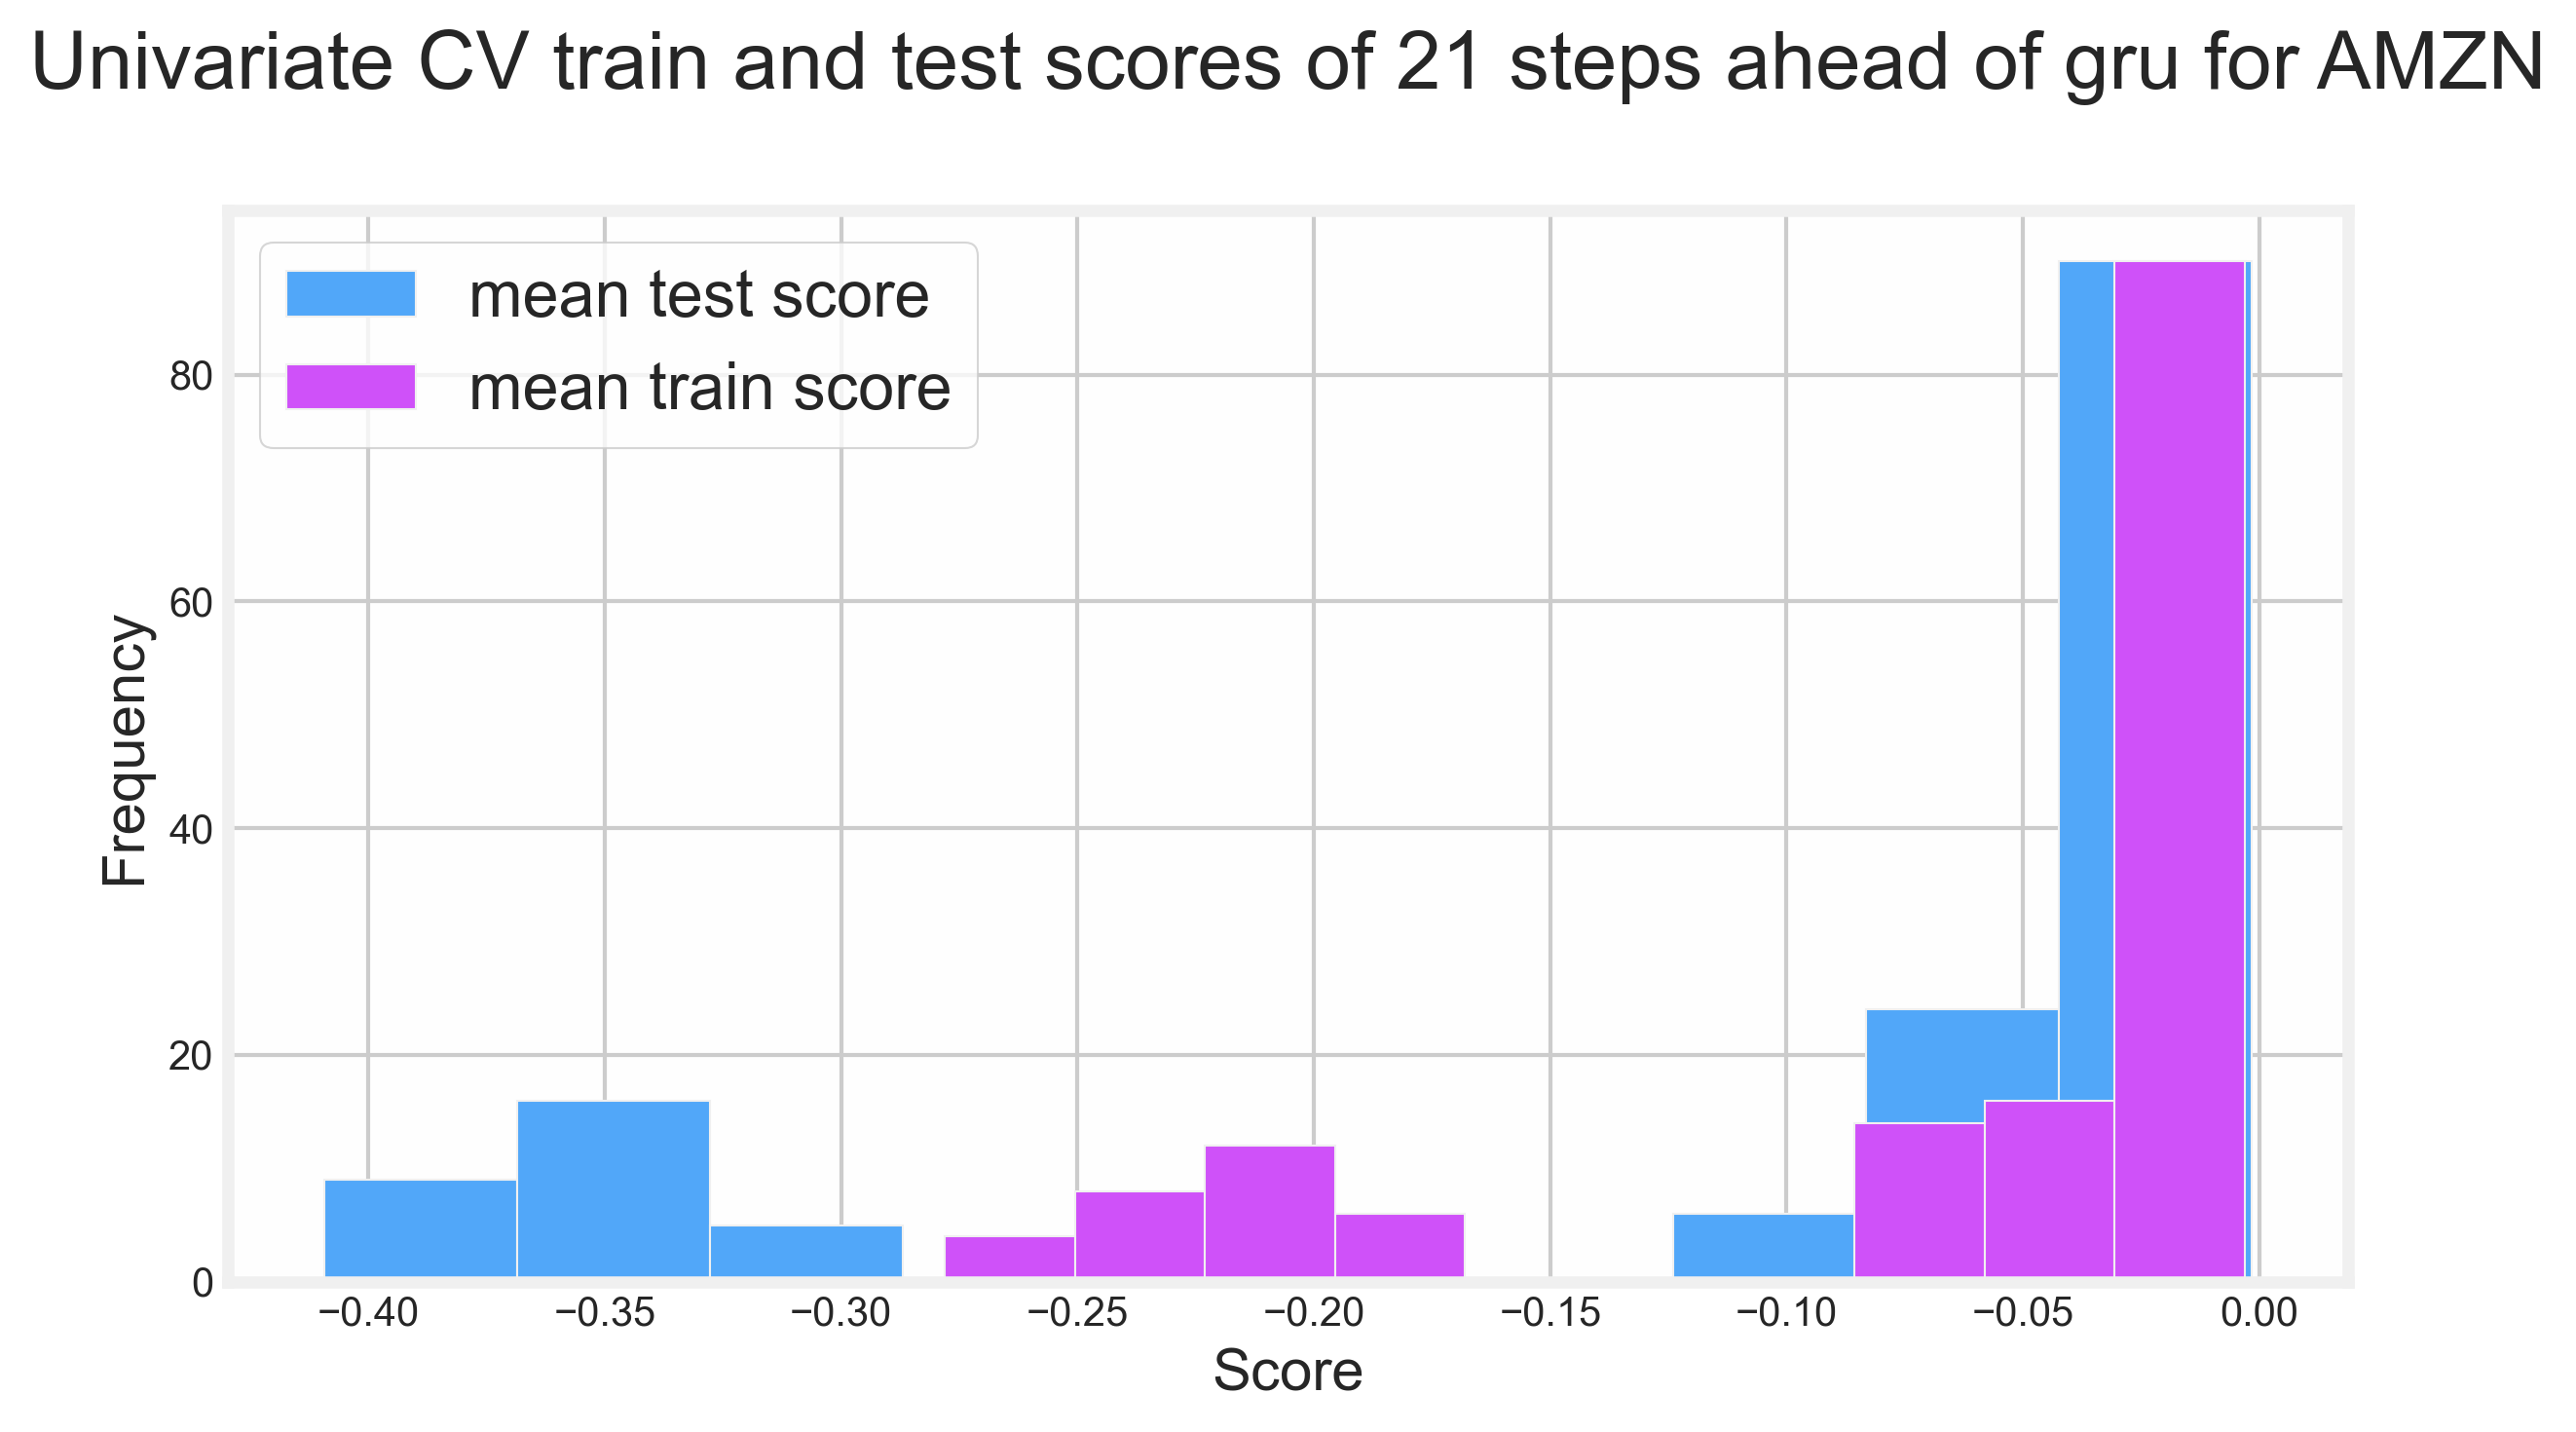

In [45]:
plotting.plot_CV_histogram(results_df, key, ticker, n_steps, n_steps_ahead)

## Rescaled model metrics 

In [46]:
predicted = params[key]['pred_test']

In [47]:
# get rescaled MAPE of 
metrics_df = ma.get_rescaled_mape_r2(y_test, predicted, mu, sigma, n_steps_ahead)
metrics_df

,MAPE,$R^2$
lag,,
1,30.0067,-1.1938


In [48]:
analysis_path = '../../model_analysis/'
analysis_folder = '{}/'.format(ticker)

analysis_file_name = '_metrics_df-price-{}-{}-n_steps.csv'.format(
    ticker, n_steps)

metrics_df.to_csv(analysis_path + analysis_folder + key + analysis_file_name)

# Plot observed vs. predicted

Saving figure:  gru_stock_price_plot_price_AMZN_n_steps_21_n_steps_ahead_1


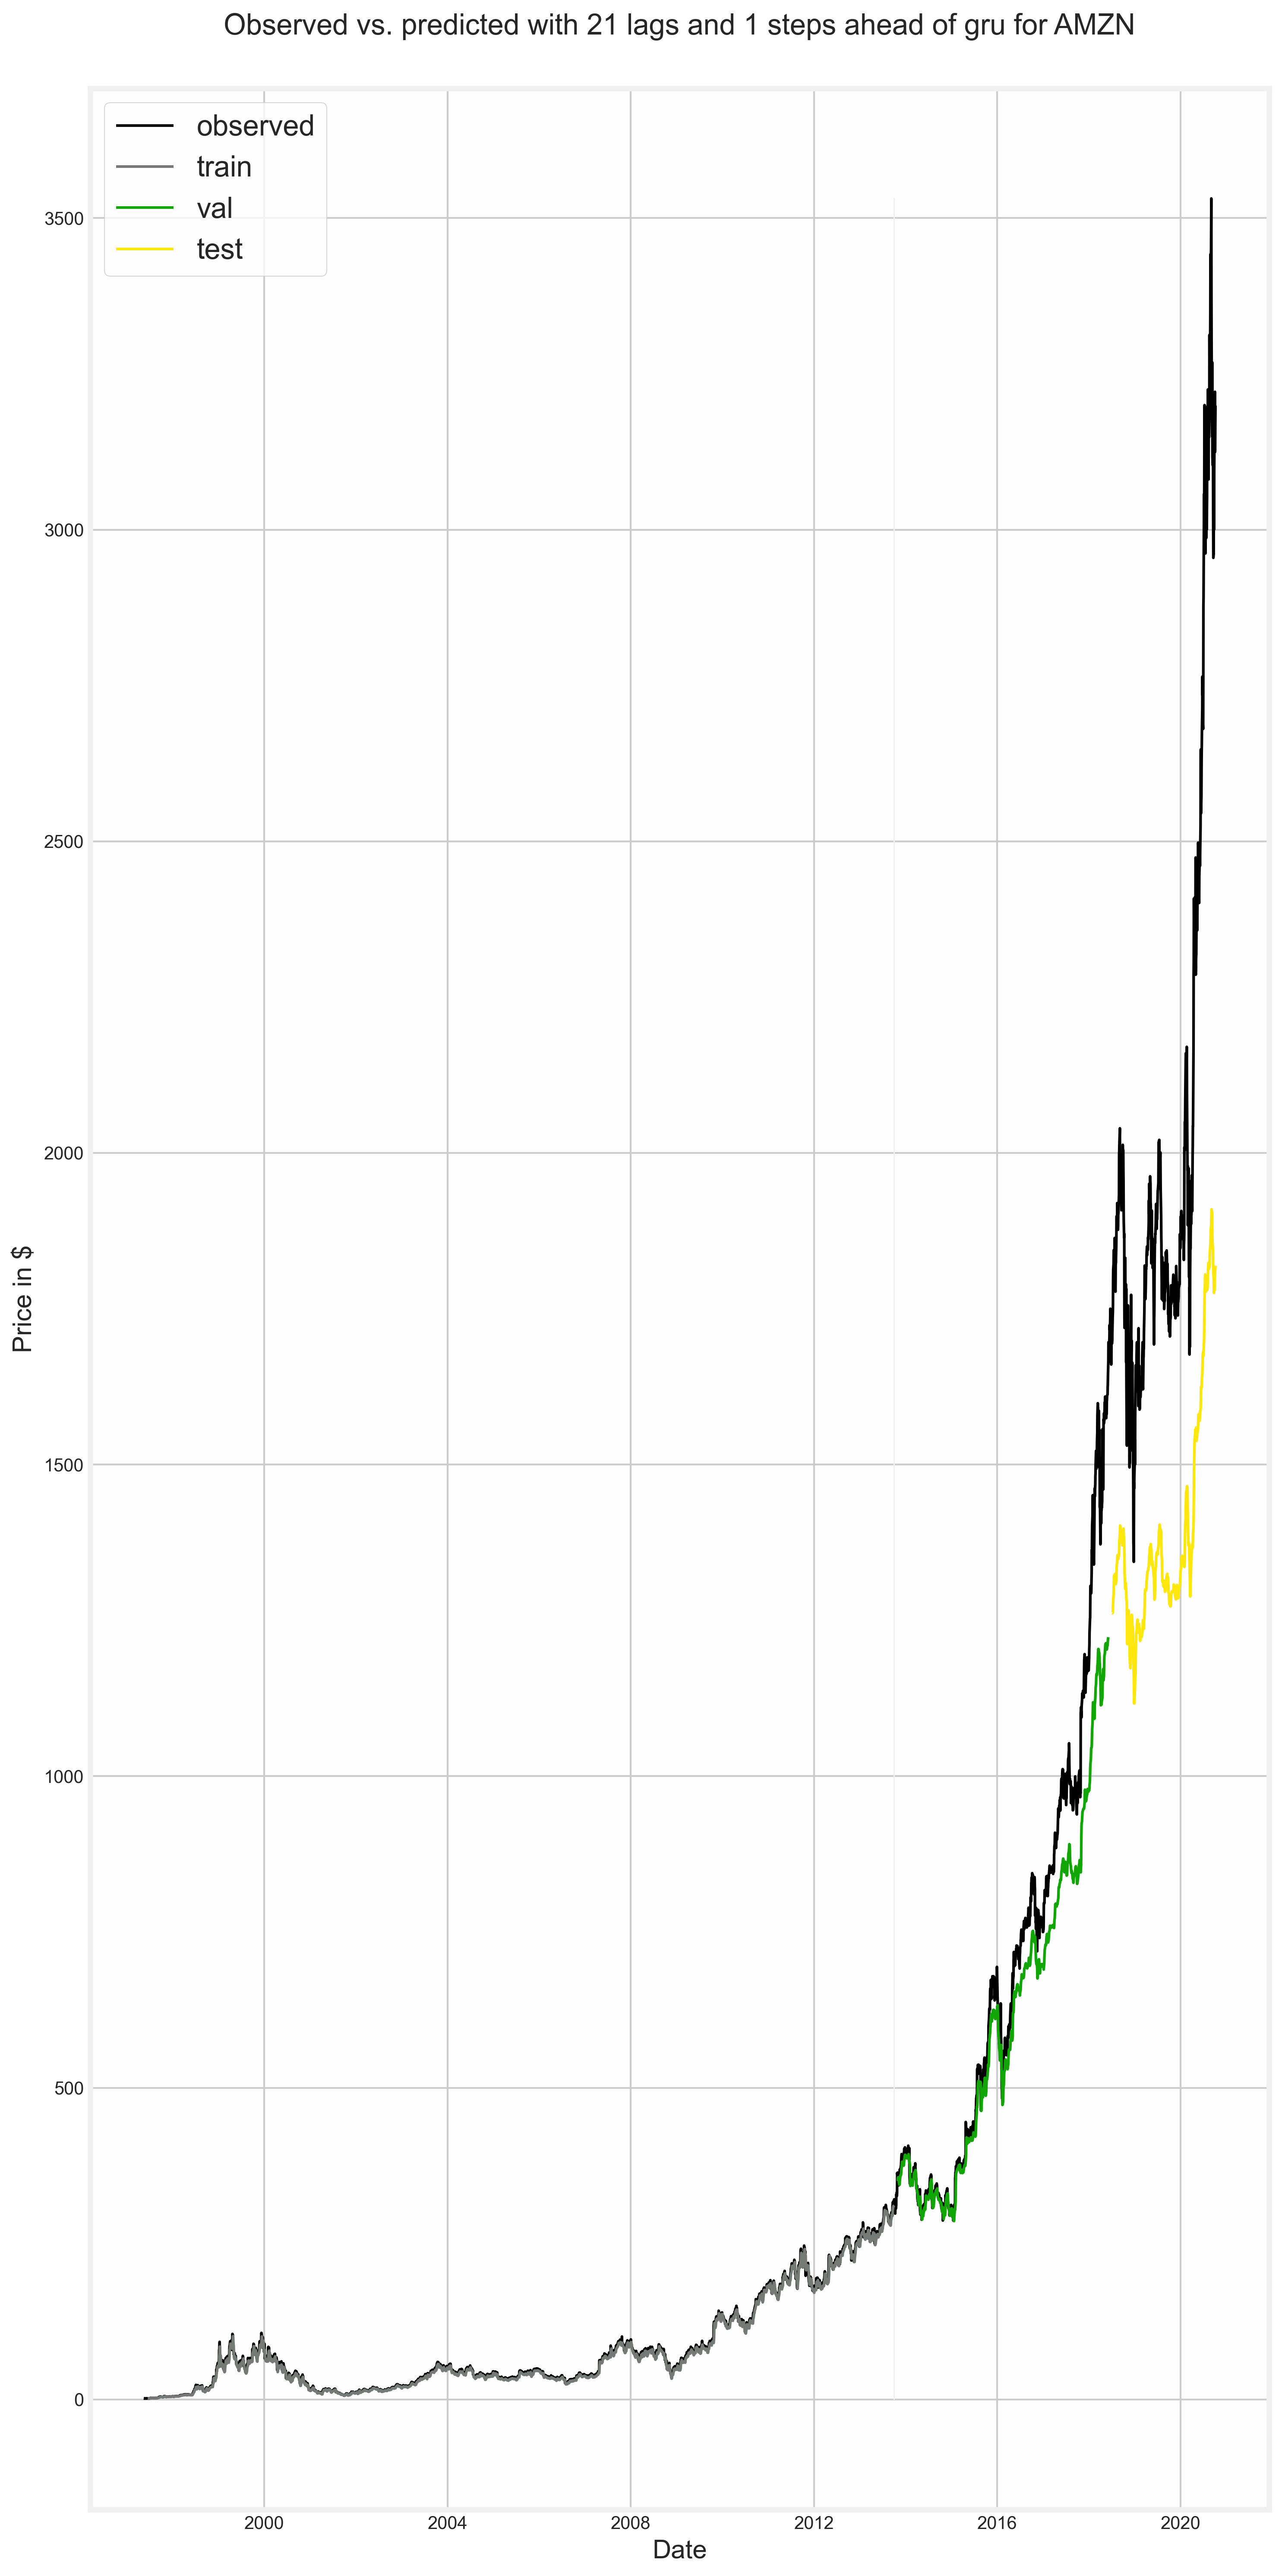

In [49]:
# rescale observed and predicted to compare
plotting.scaled_observed_vs_predicted_plot(data, key, ticker, data_train, data_val,
                                           data_test, mu, sigma, params, n_steps, n_steps_ahead)

# Tensorboard

In [50]:
str_path = '../../logs/fit/'+ ticker +'_' + lags + '_uni_'+ key

path = Path(str_path)

In [51]:
path

PosixPath('../../logs/fit/AMZN_21_uni_gru')

In [52]:
%reload_ext tensorboard

# uncomment the function below to gain more insight of the models behavior
%tensorboard --logdir ../../logs/fit/AMZN_21_uni_gru